In [2]:
from temple.session import TUSession
from dotenv import load_dotenv
from os import getenv

load_dotenv(override=True)


session = TUSession()
session.login(username=getenv("USERNAME"), password=getenv("PASSWORD"))

In [3]:
from typing_extensions import Annotated
from pydantic import BaseModel, StringConstraints
from typing import Optional, Union, Tuple, Literal
from school.courses import CourseSection
from util.print import pprint

CourseConstraint = Annotated[str, StringConstraints(pattern=r"^[A-Z]+\d+$")]
SectionConstraint = Annotated[str, StringConstraints(pattern=r"^\d+$")]
TeacherConstraint = Annotated[str, StringConstraints(strip_whitespace=True, to_lower=True)]


class CourseSelect(BaseModel, frozen=True):
    course: CourseConstraint
    section: Optional[SectionConstraint] = None


class CourseIgnore(BaseModel, frozen=True):
    course: CourseConstraint
    section: Optional[Union[Tuple[SectionConstraint], SectionConstraint]] = None
    teacher: Optional[Union[Tuple[TeacherConstraint], TeacherConstraint]] = None
    instructional_method: Optional[Literal["CLAS", "OLL"]] = None
    waitlist: Optional[bool] = None

    def should_ignore(self, _course_section: CourseSection) -> bool:
        """
        Determine if the course section should be ignored based on section, teacher, or instructional method.
        """

        # Check section constraint
        if self.section:
            section_numbers = self.section if isinstance(self.section, list) else [self.section]
            if _course_section.sequenceNumber in section_numbers:
                return True

        # Check teacher constraint
        if self.teacher:
            faculty_names = {faculty.get_name().lower() for faculty in _course_section.faculty}
            teacher_names = set(self.teacher) if isinstance(self.teacher, list) else {self.teacher}
            if faculty_names & teacher_names:
                return True

        # Check instructional method constraint
        if self.instructional_method == _course_section.instructionalMethod:
            return True

        # Check waitlist method constraint
        if self.waitlist is not None:
            if self.waitlist:
                if _course_section.seatsAvailable == 0:
                    return True
            else:
                if _course_section.seatsAvailable > 0:
                    return True

        return False


In [74]:
from school.session import SchoolSession
from school.courses import CourseSection
from school.week_schedule import WeekSchedule
from functools import cache
from itertools import product
from typing import Dict, List, Set
from temple.session import TUSession


class CourseBuilder:
    _session: SchoolSession
    _term: int
    _courses_select: Set[CourseSelect]
    _courses_ignore: Dict[str, Set[CourseIgnore]]

    def __init__(self, _session: SchoolSession):
        self._session = _session
        self._courses_select = set()
        self._courses_ignore = {}
        self._term = -1

    def print_terms(self, _max: int):
        assert self._term > 0, "term not selected"
        terms = self._session.get_terms(_max)

        for term in terms:
            print(f"CODE: {term.code}, DESCRIPTION: {term.description}")

    def select_term(self, _term: int):
        self._term = _term

    def update(self, _course_options: List[Union[CourseSelect, CourseIgnore]]):
        for course_option in _course_options:
            if isinstance(course_option, CourseSelect):
                self._courses_select.add(course_option)
            elif isinstance(course_option, CourseIgnore):
                self._courses_ignore.setdefault(course_option.course, set()).add(course_option)

    def _section_ignore_filter(self, _section: CourseSection):
        # Make sure only main campus classes classes are allowed
        if _section.campusDescription != "Main":
            return False

        # Make sure only in-person clasess and online classes are allowed
        if _section.instructionalMethod != "CLAS" and _section.instructionalMethod != "OLL":
            return False

        # Make sure all unwanted courses are ignored
        if _section.subjectCourse in self._courses_ignore:
            return not any(course.should_ignore(_section) for course in self._courses_ignore[_section.subjectCourse])

        # All checks passed
        return True

    def _section_overlap_filter(self, _sections: List[CourseSection]) -> bool:
        # Dictionary to store occupied time slots for each day
        occupied_times = {
            "monday": set(),
            "tuesday": set(),
            "wednesday": set(),
            "thursday": set(),
            "friday": set(),
            "saturday": set(),
            "sunday": set(),
        }

        # Check each section for time conflicts
        for section in _sections:
            for meeting in section.meetingsFaculty:
                mt = meeting.meetingTime

                # Calculate time slot range based on start and end times
                if mt.beginTime and mt.endTime:
                    time_range = (mt.beginTime, mt.endTime)

                    # Check and add occupied time slots for each relevant day
                    for day in ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]:
                        if getattr(mt, day):
                            # Check for conflicts on this day
                            if any(start < time_range[1] and end > time_range[0] for start, end in occupied_times[day]):
                                return False  # Overlap detected

                            # Add this time range to the occupied times for this day
                            occupied_times[day].add(time_range)
        # No overlaps found
        return True

    def get_combinations(self) -> List[List[CourseSection]]:
        assert self._term > 0, "term not selected"

        all_sections: List[List[CourseSection]] = []

        for selected_course in self._courses_select:
            try:
                course_sections = self._session.get_course_sections(selected_course.course, term=self._term)
            except Exception:
                raise AssertionError(f"{selected_course.course} is not a valid course")

            # Course already registered
            if selected_course.section:
                course_sections = list(filter(lambda c: c.sequenceNumber == selected_course.section, course_sections))
                assert course_sections, f"{selected_course.course} has no section numbered {selected_course.section}"
            else:
                course_sections = list(filter(self._section_ignore_filter, course_sections))
                assert course_sections, f"{selected_course.course} has no available sections"

            # Append list of sections for each course so that we can get the cartesian product
            all_sections.append(course_sections)

        # Get the cartesian product of all sections
        return list(filter(self._section_overlap_filter, product(*all_sections)))


# pprint(session.get_course_sections)

builder = CourseBuilder(session)
builder.select_term(202503)

builder.update(
    [
        CourseSelect(course="MATH2043"),
        CourseSelect(course="MATH2101"),
        CourseSelect(course="CIS1068"),
        CourseSelect(course="IH0851"),
        CourseSelect(course="CIS1057", section="001"),
        # CourseIgnore(course="IH0851", teacher="Patricia Moore-Martinez"),
    ]
)

course_combos = builder.get_combinations()
# pprint(course_combos)


WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 705 | Michael Neff | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.215 avg


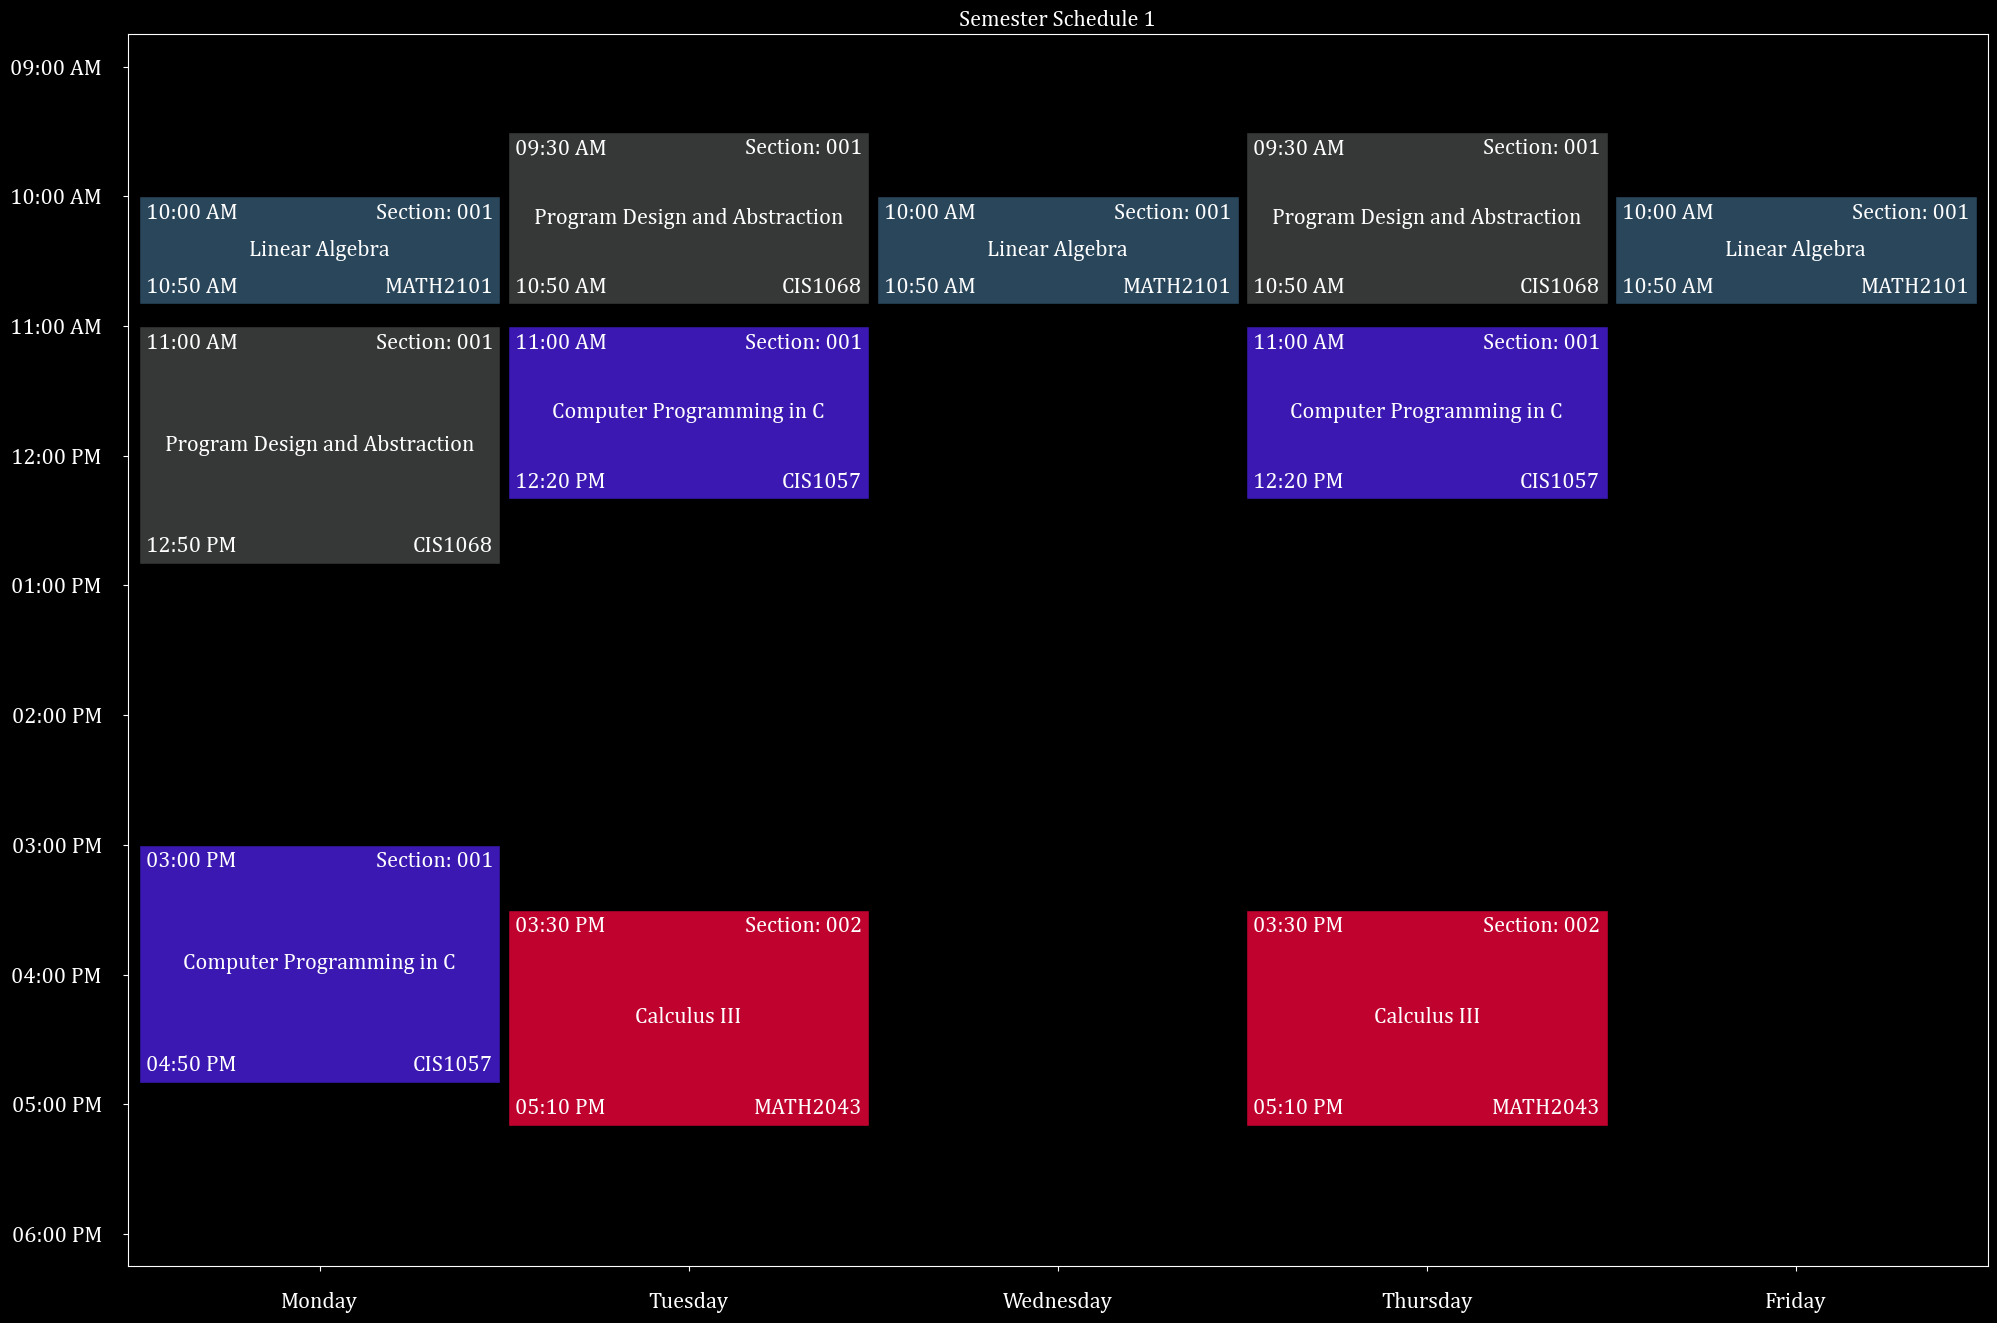

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 002 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 705 | Michael Neff | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.215 avg


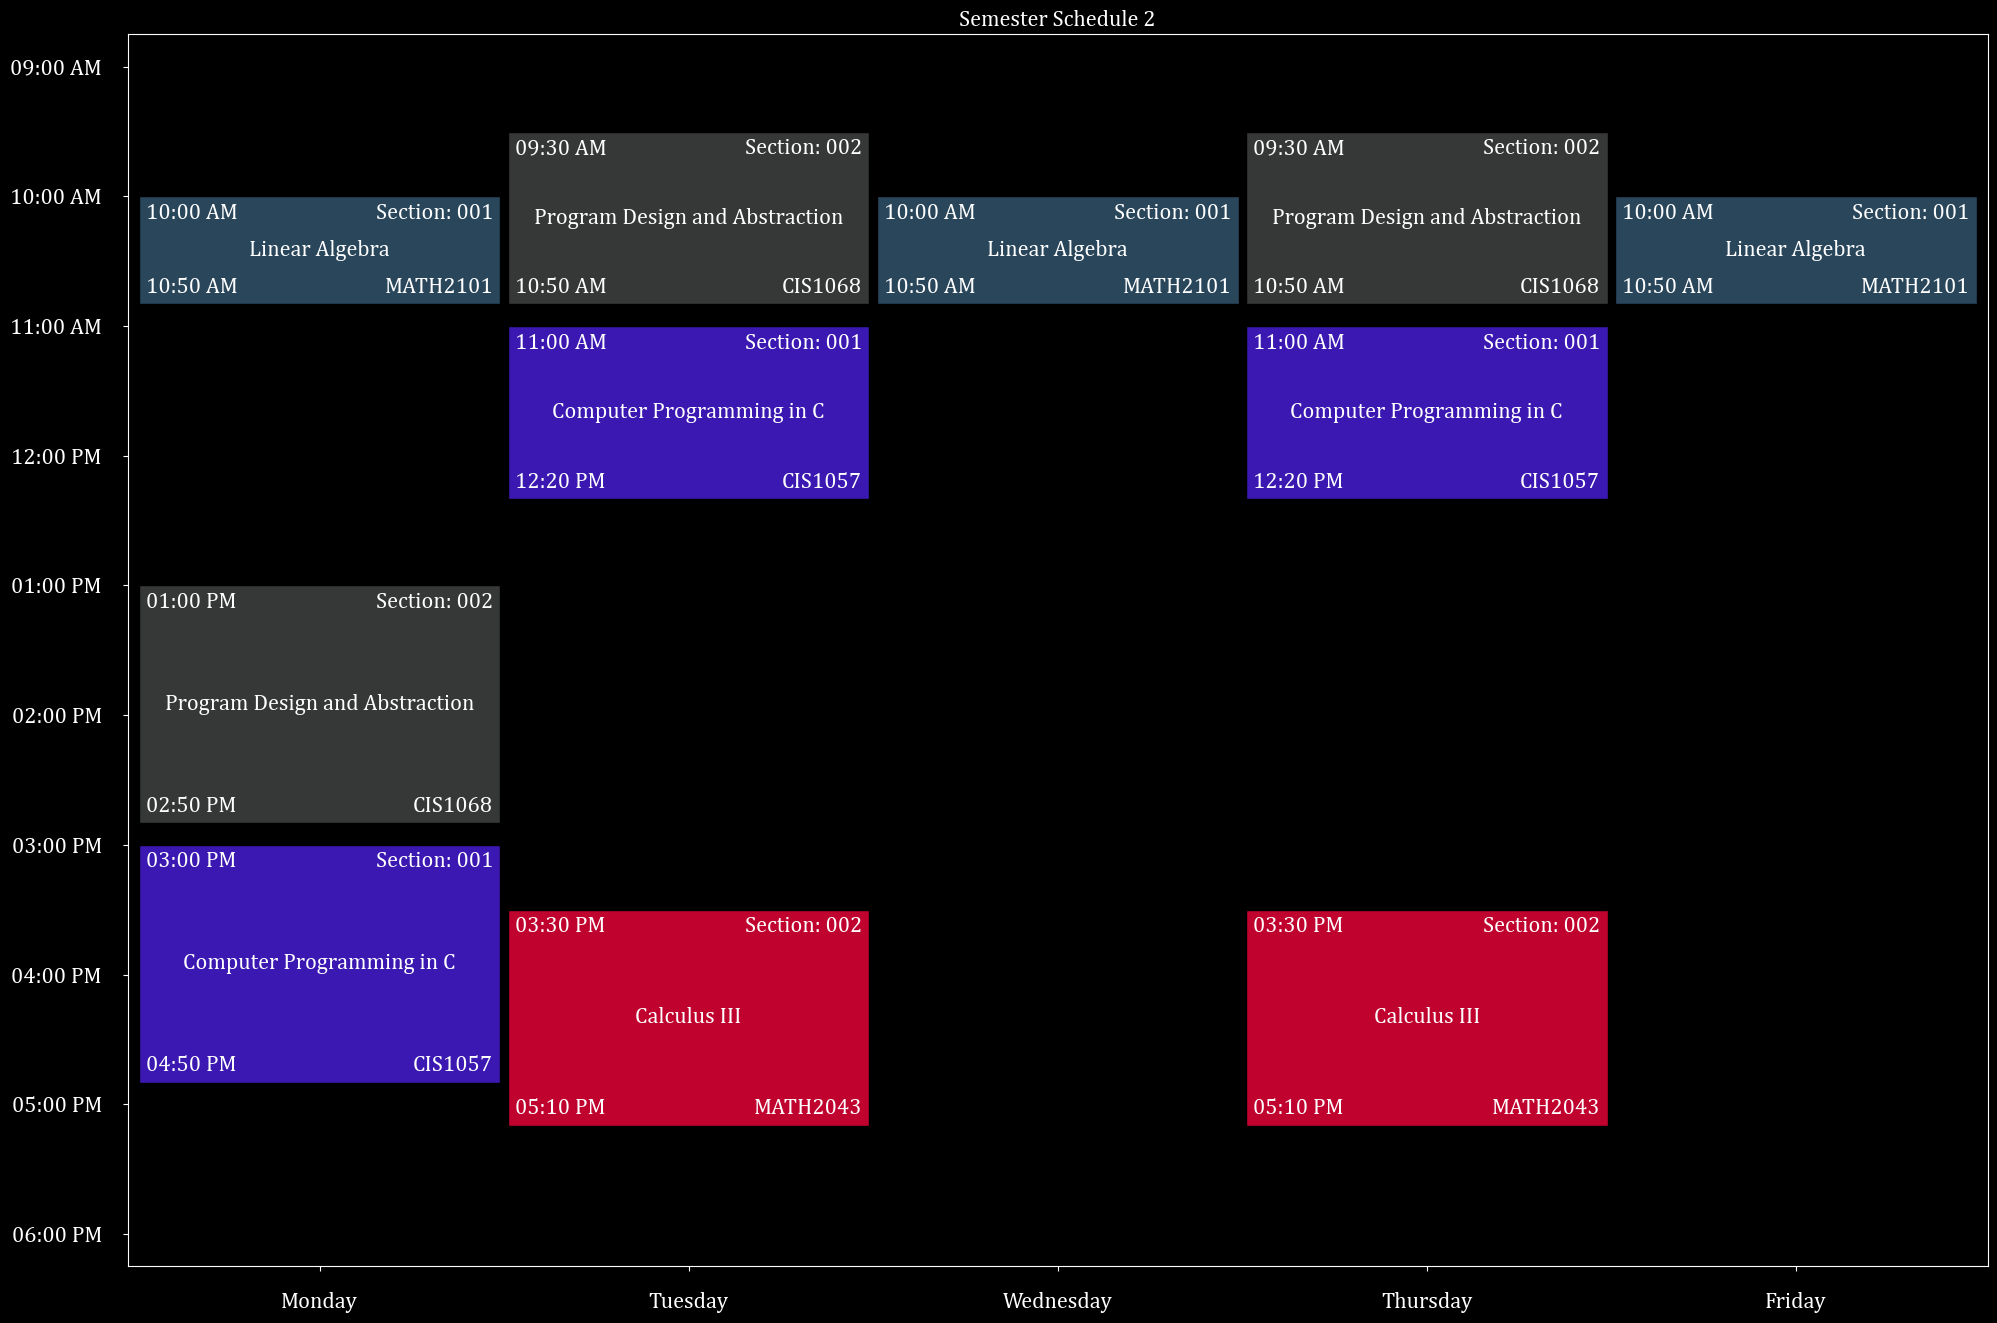

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 003 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 705 | Michael Neff | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.215 avg


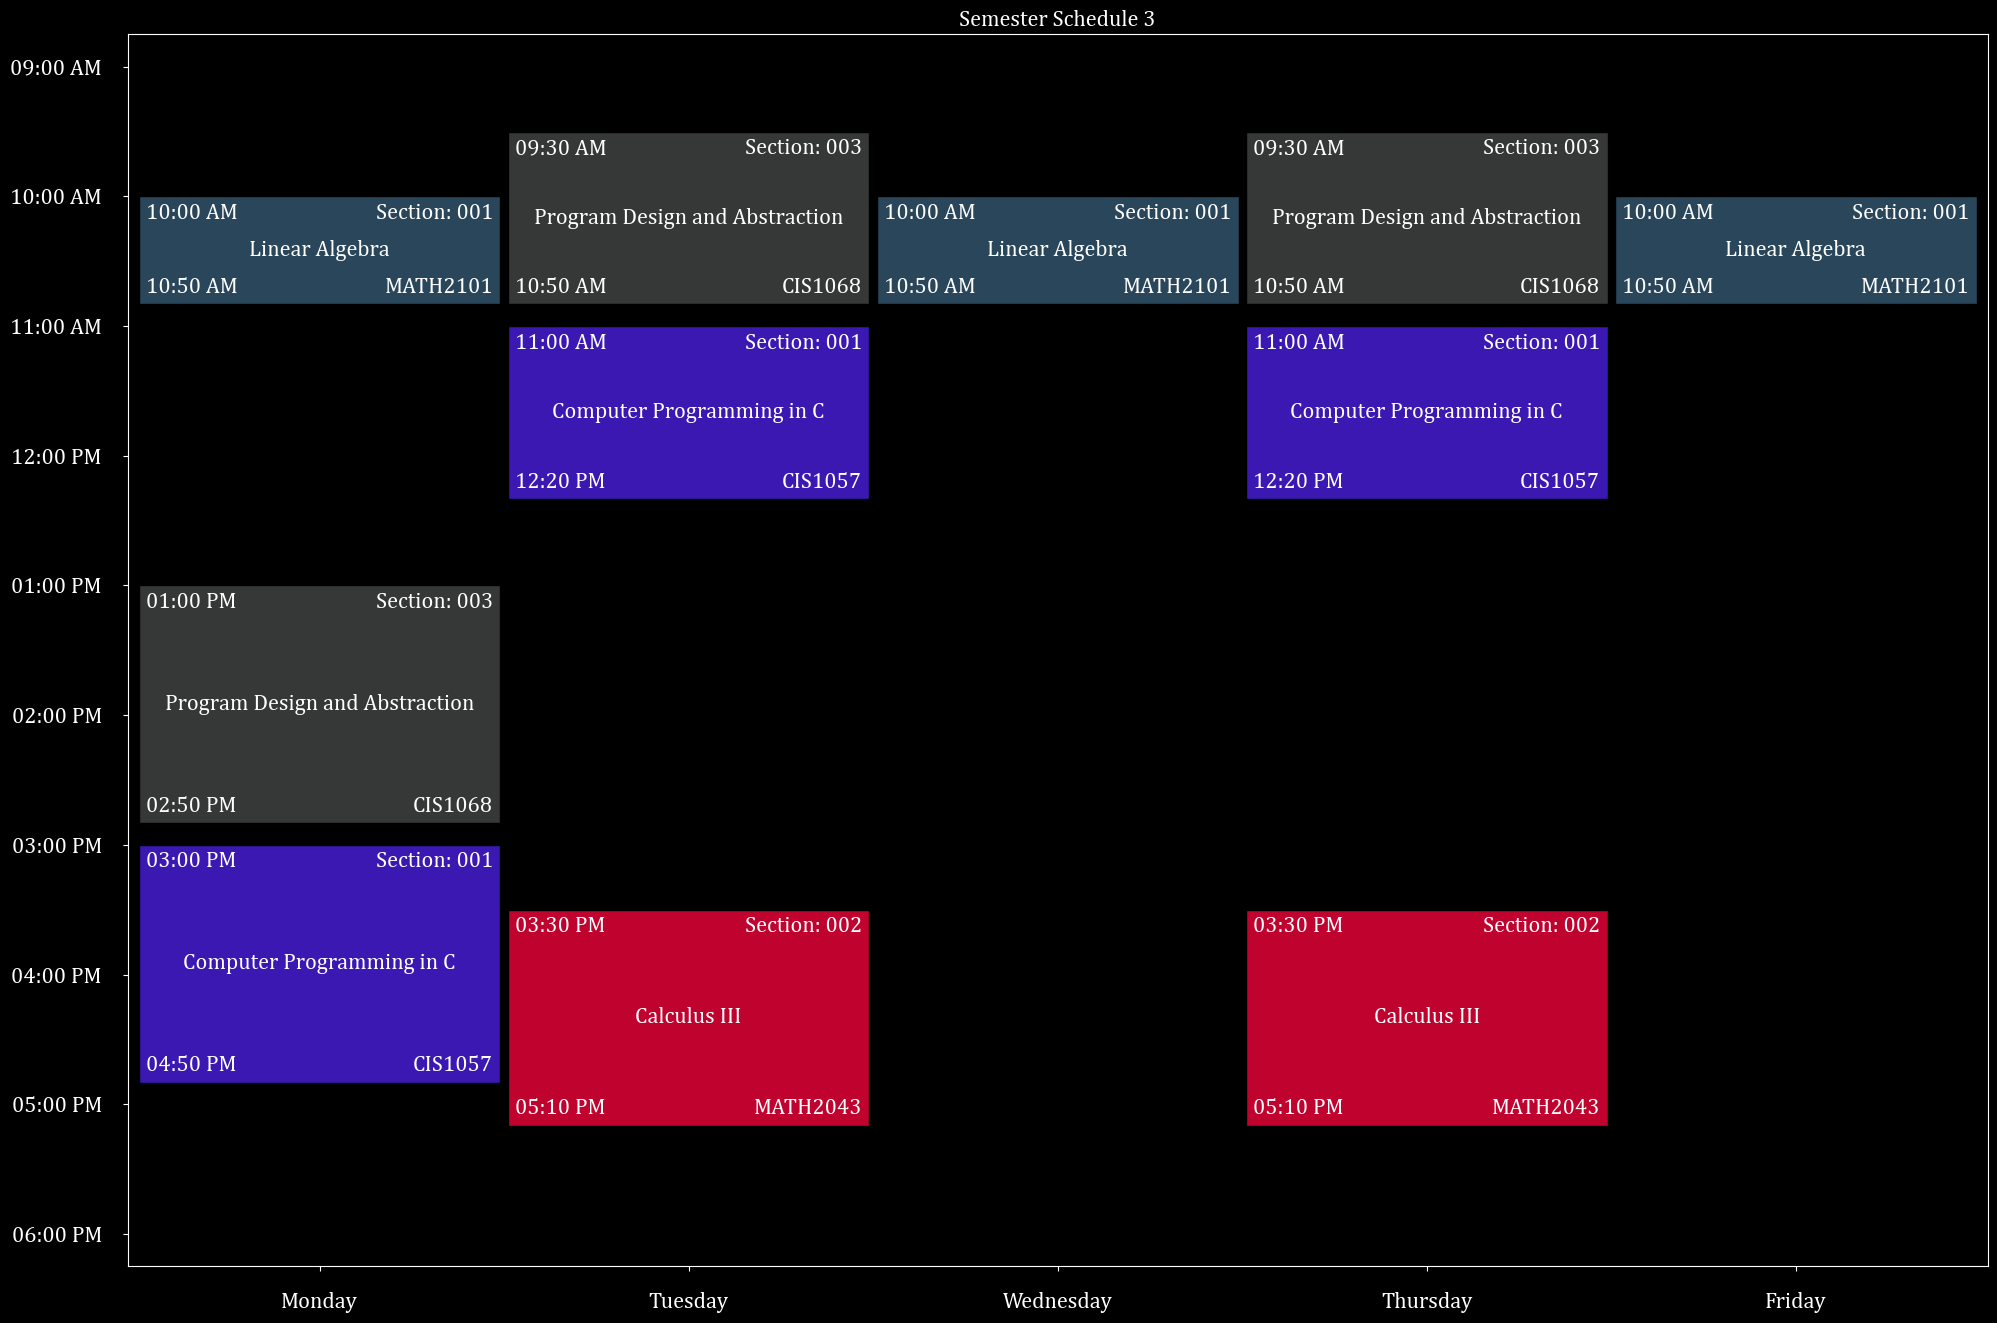

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 004 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 705 | Michael Neff | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.215 avg


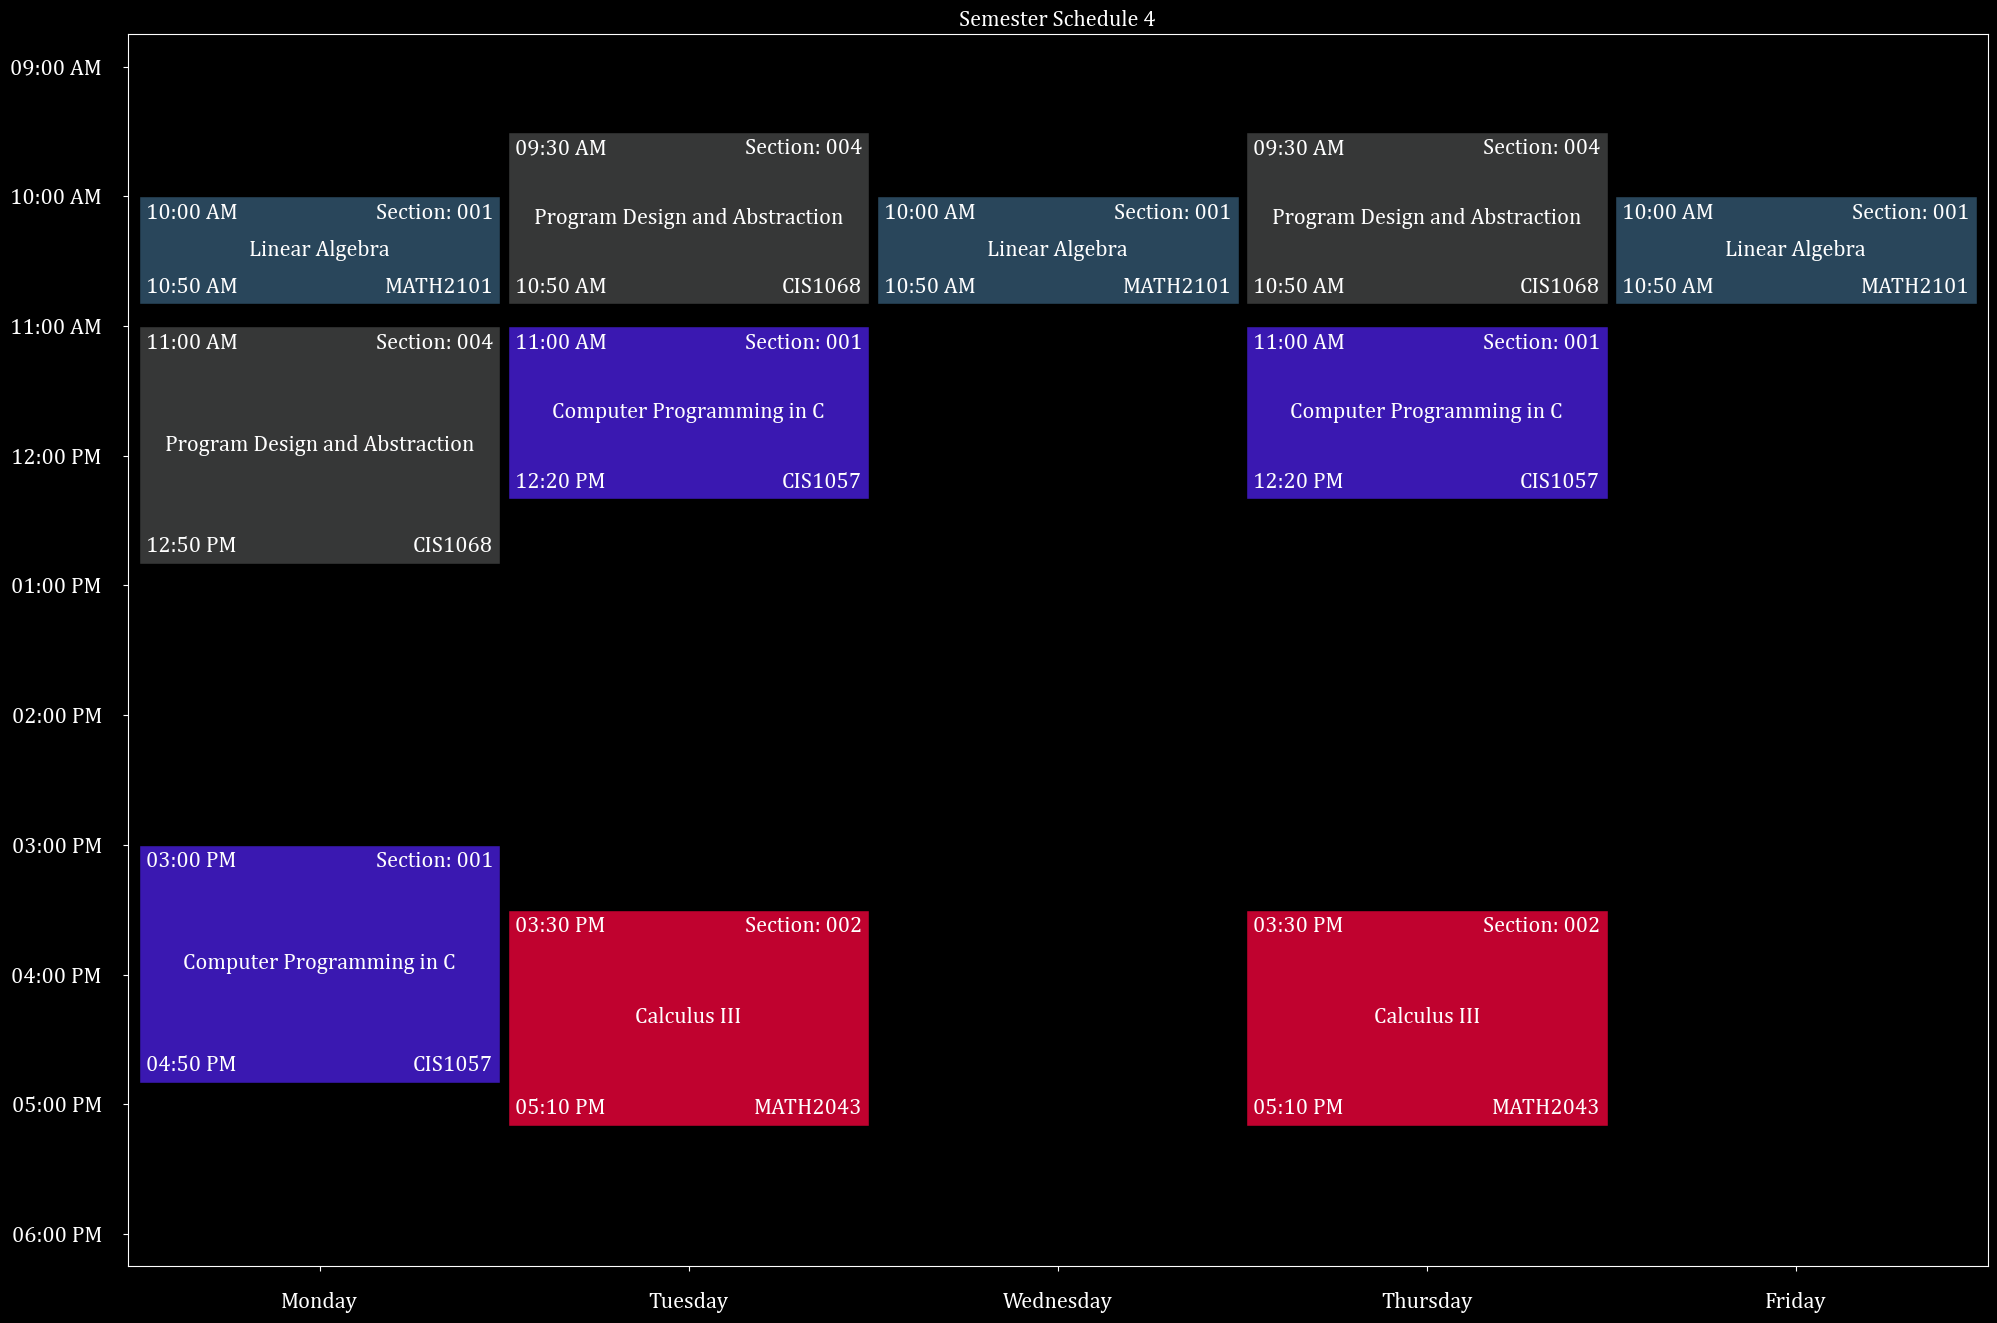

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 005 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 705 | Michael Neff | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.215 avg


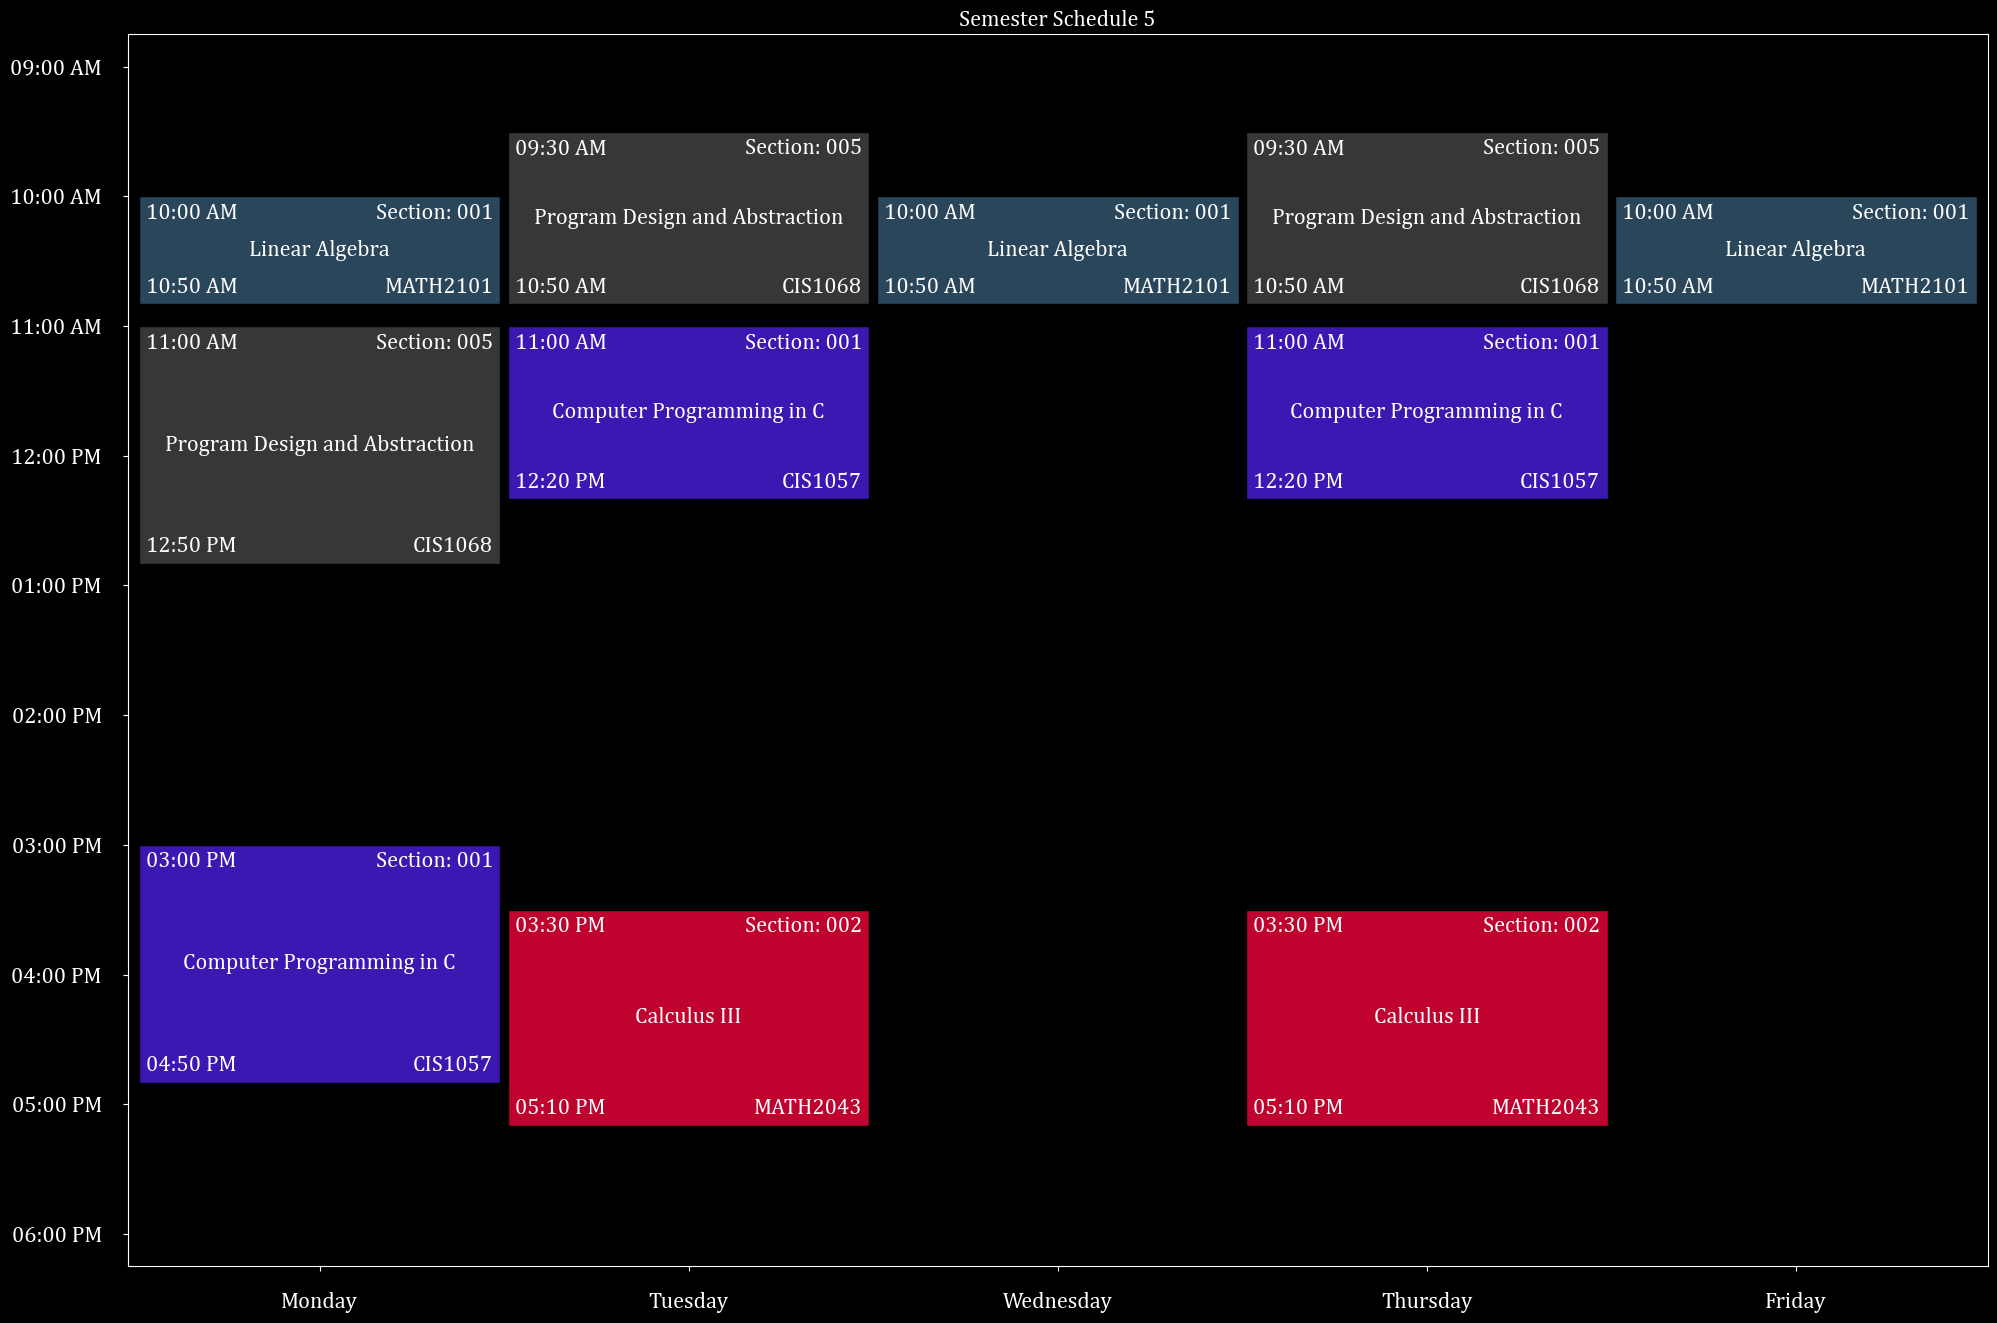

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 006 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 705 | Michael Neff | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.215 avg


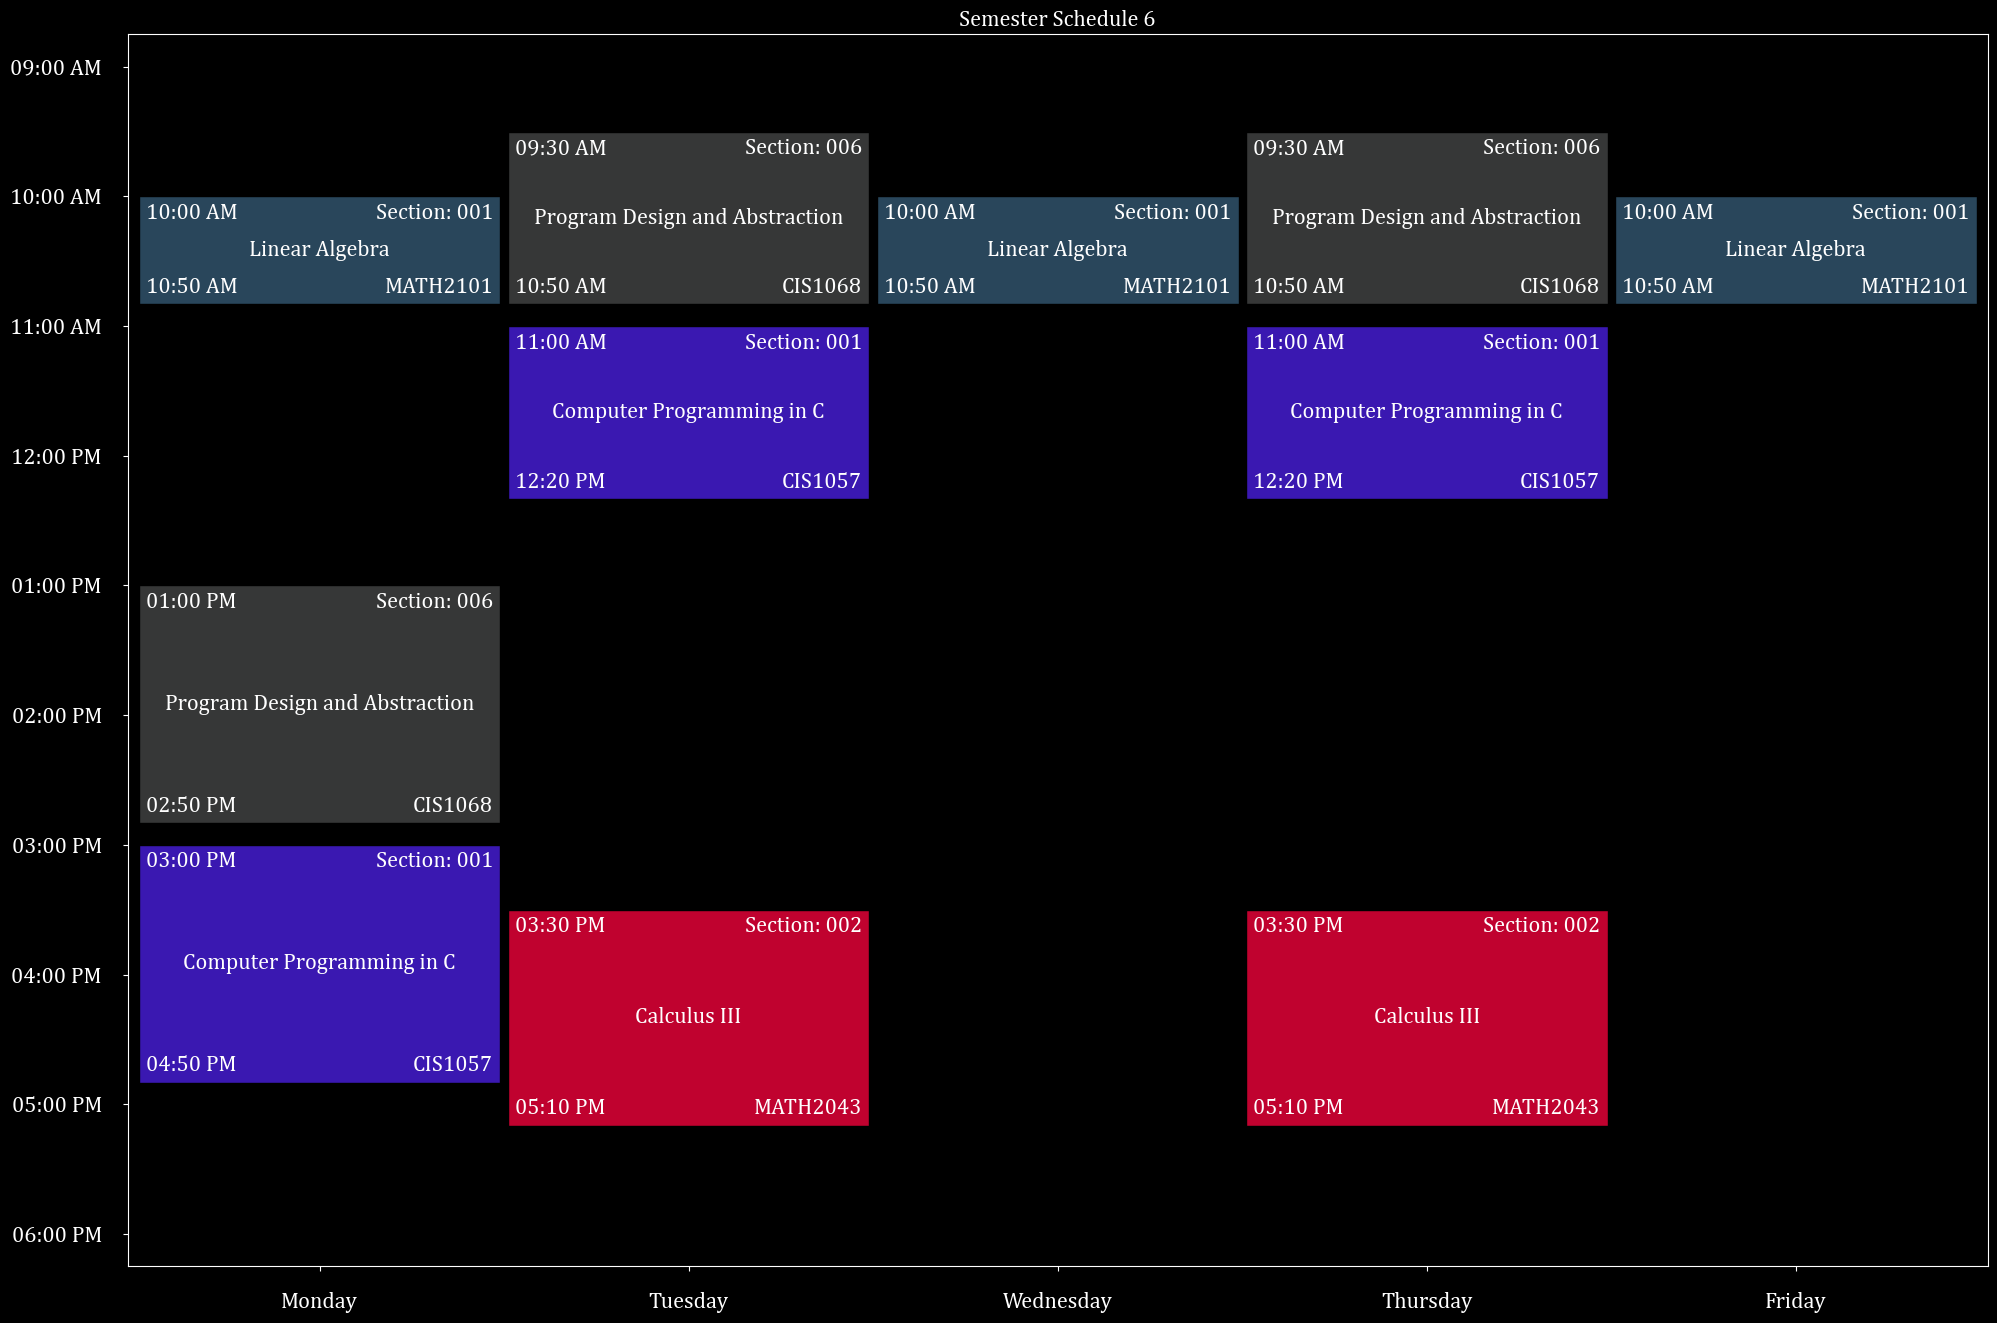

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(11 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 007 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 705 | Michael Neff | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.215 avg


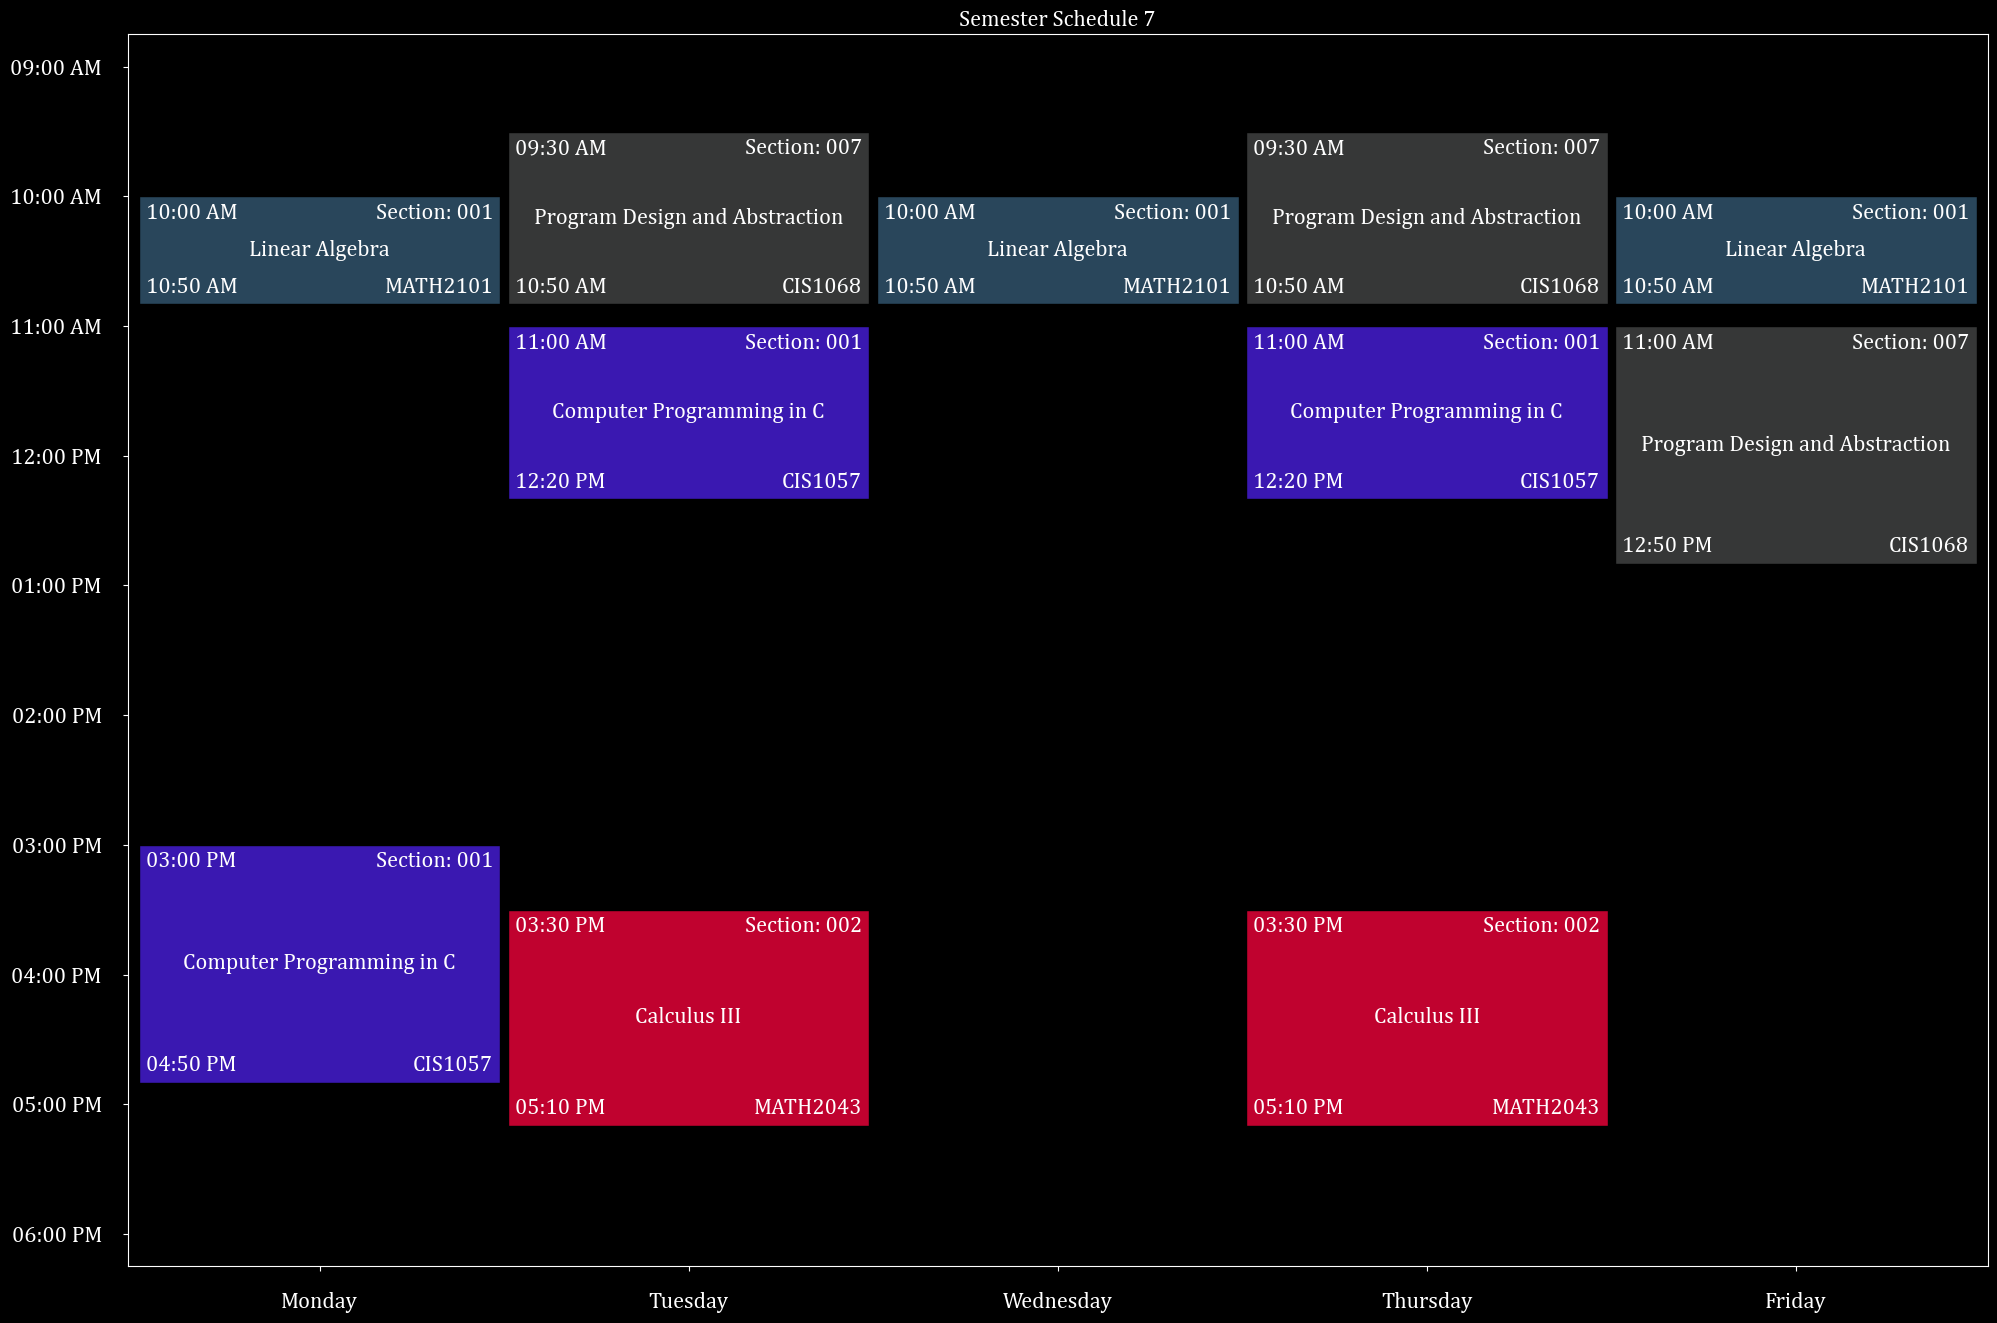

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 004 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


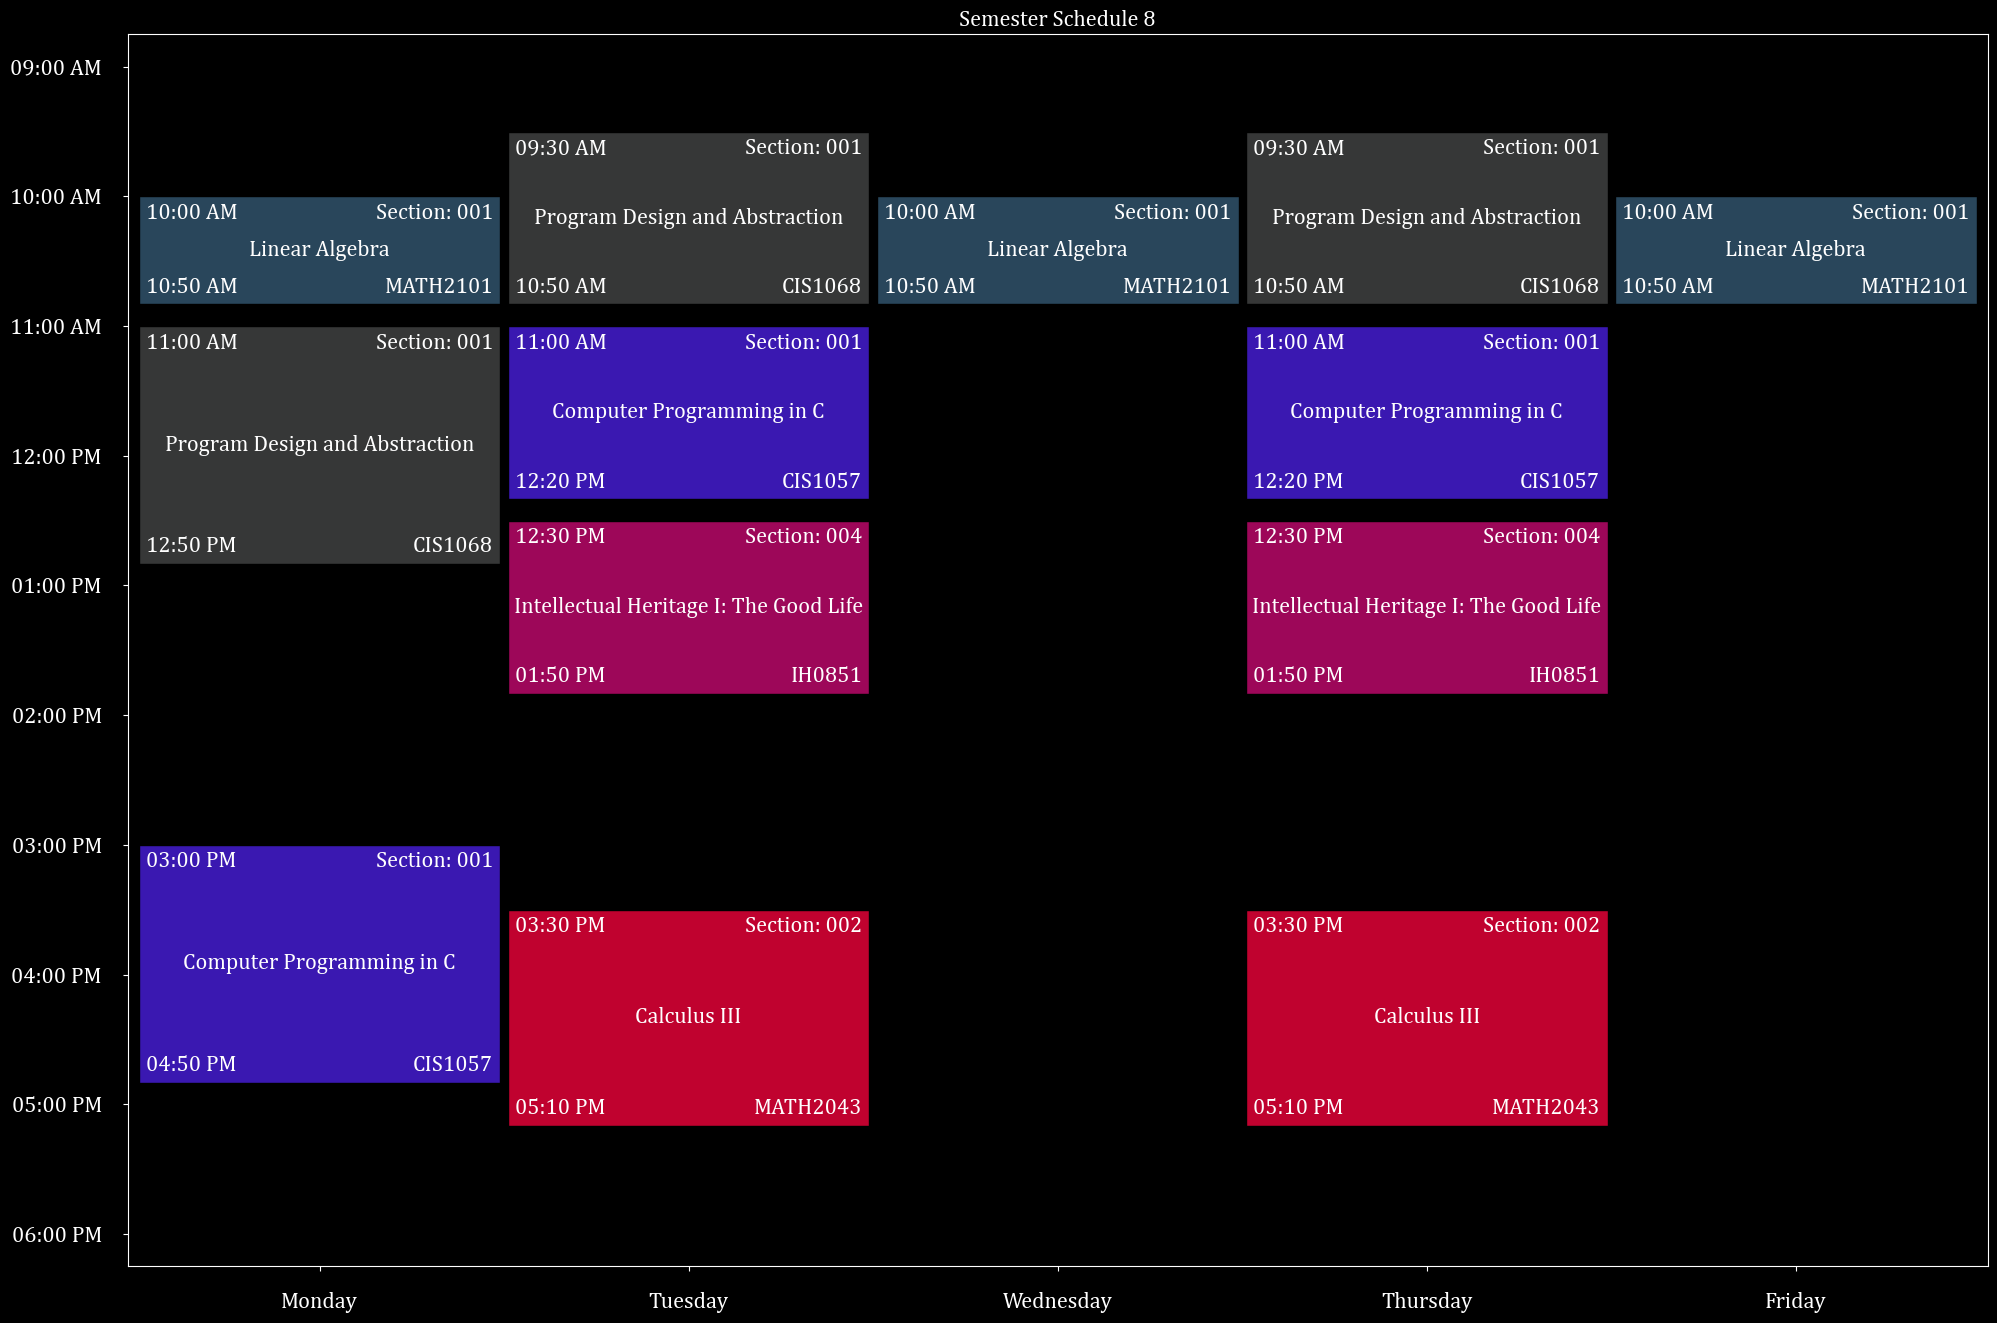

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 010 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


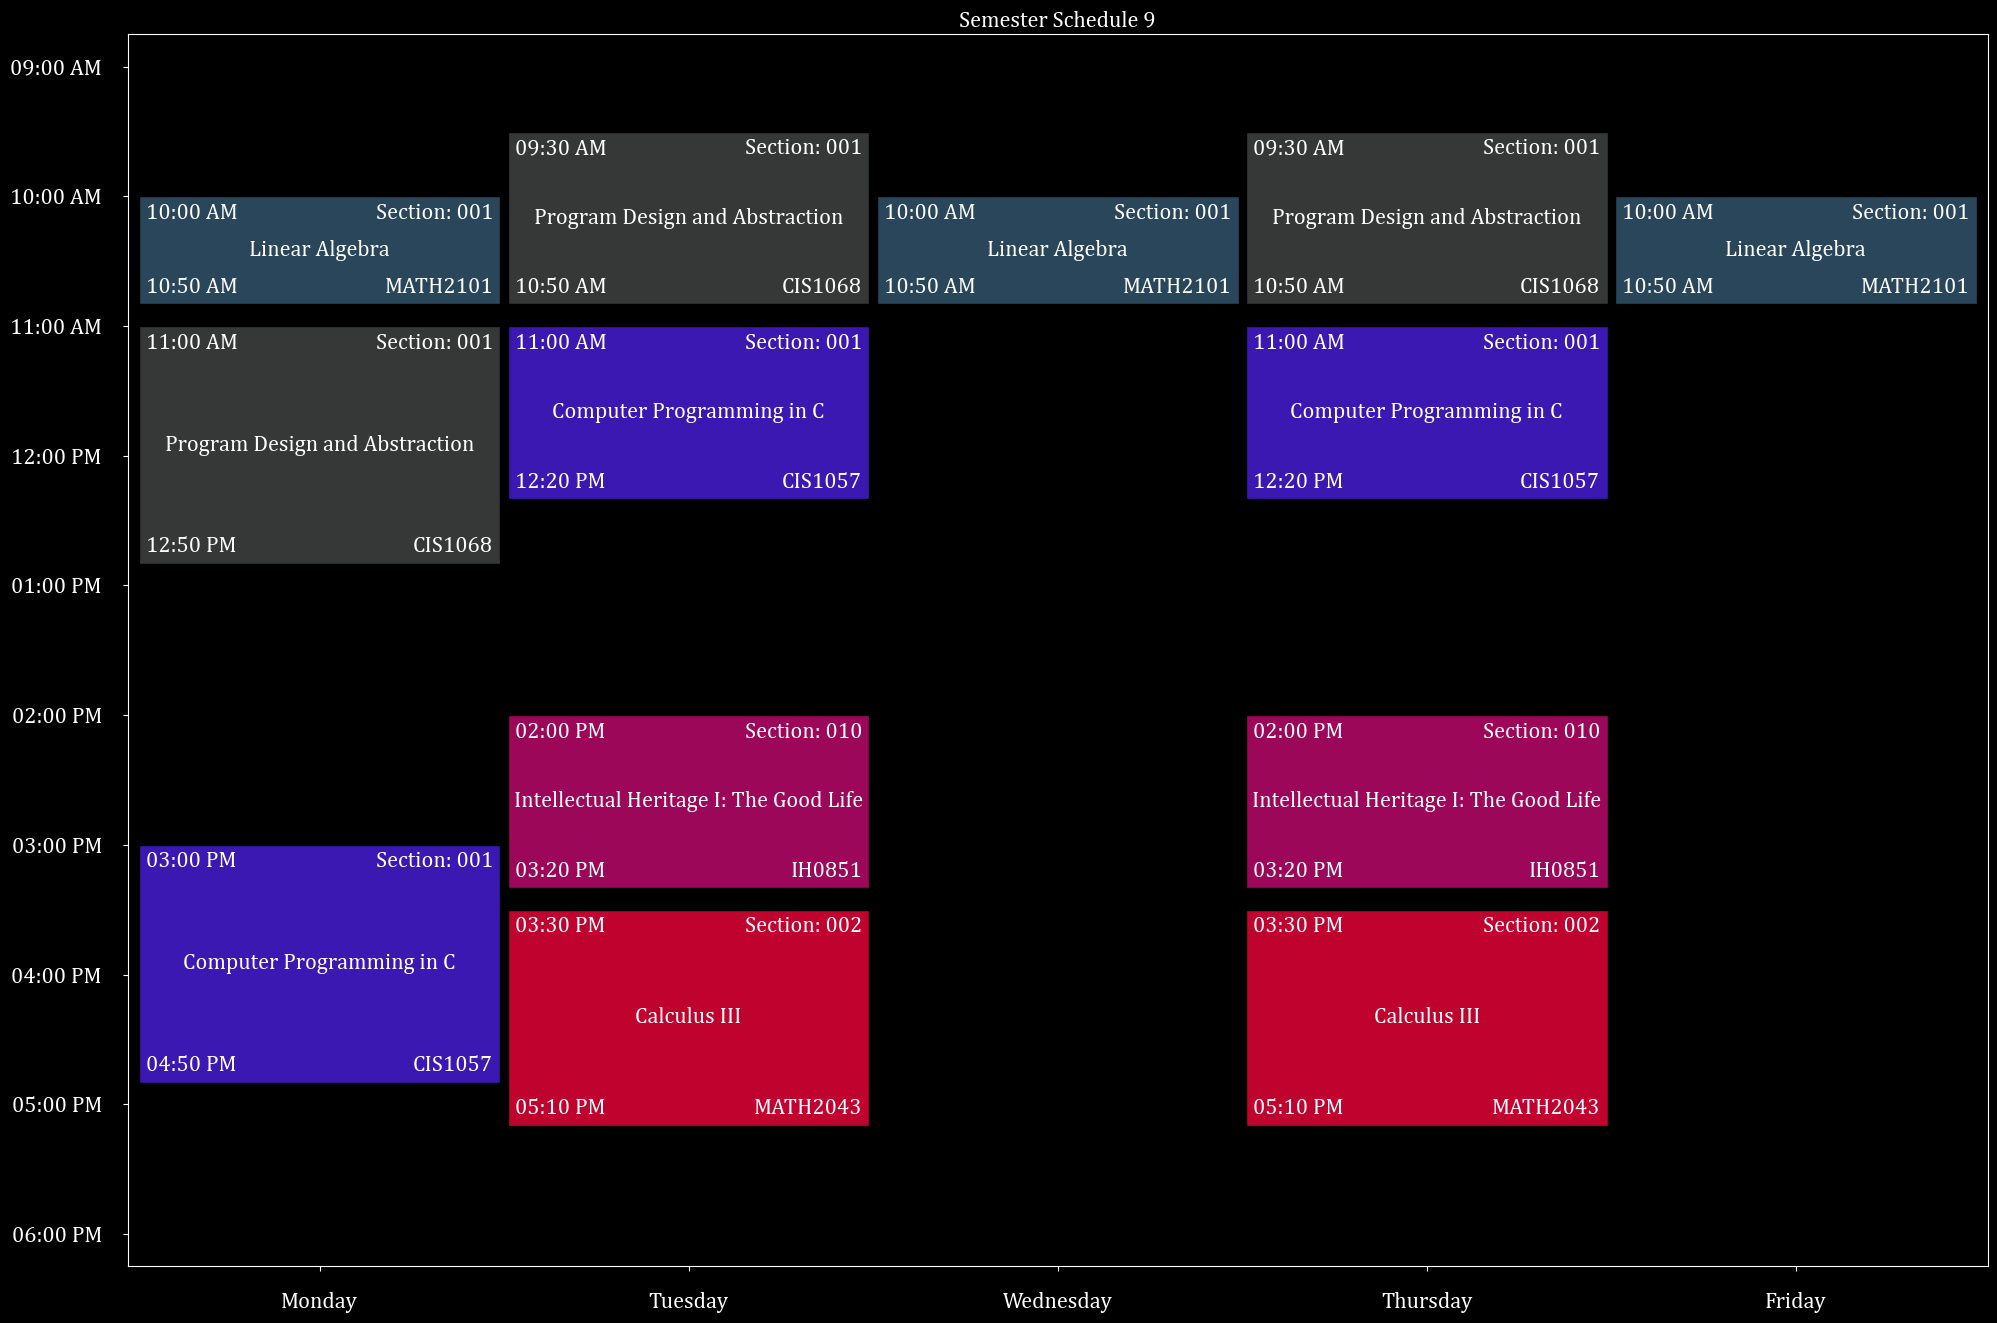

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 002 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 004 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


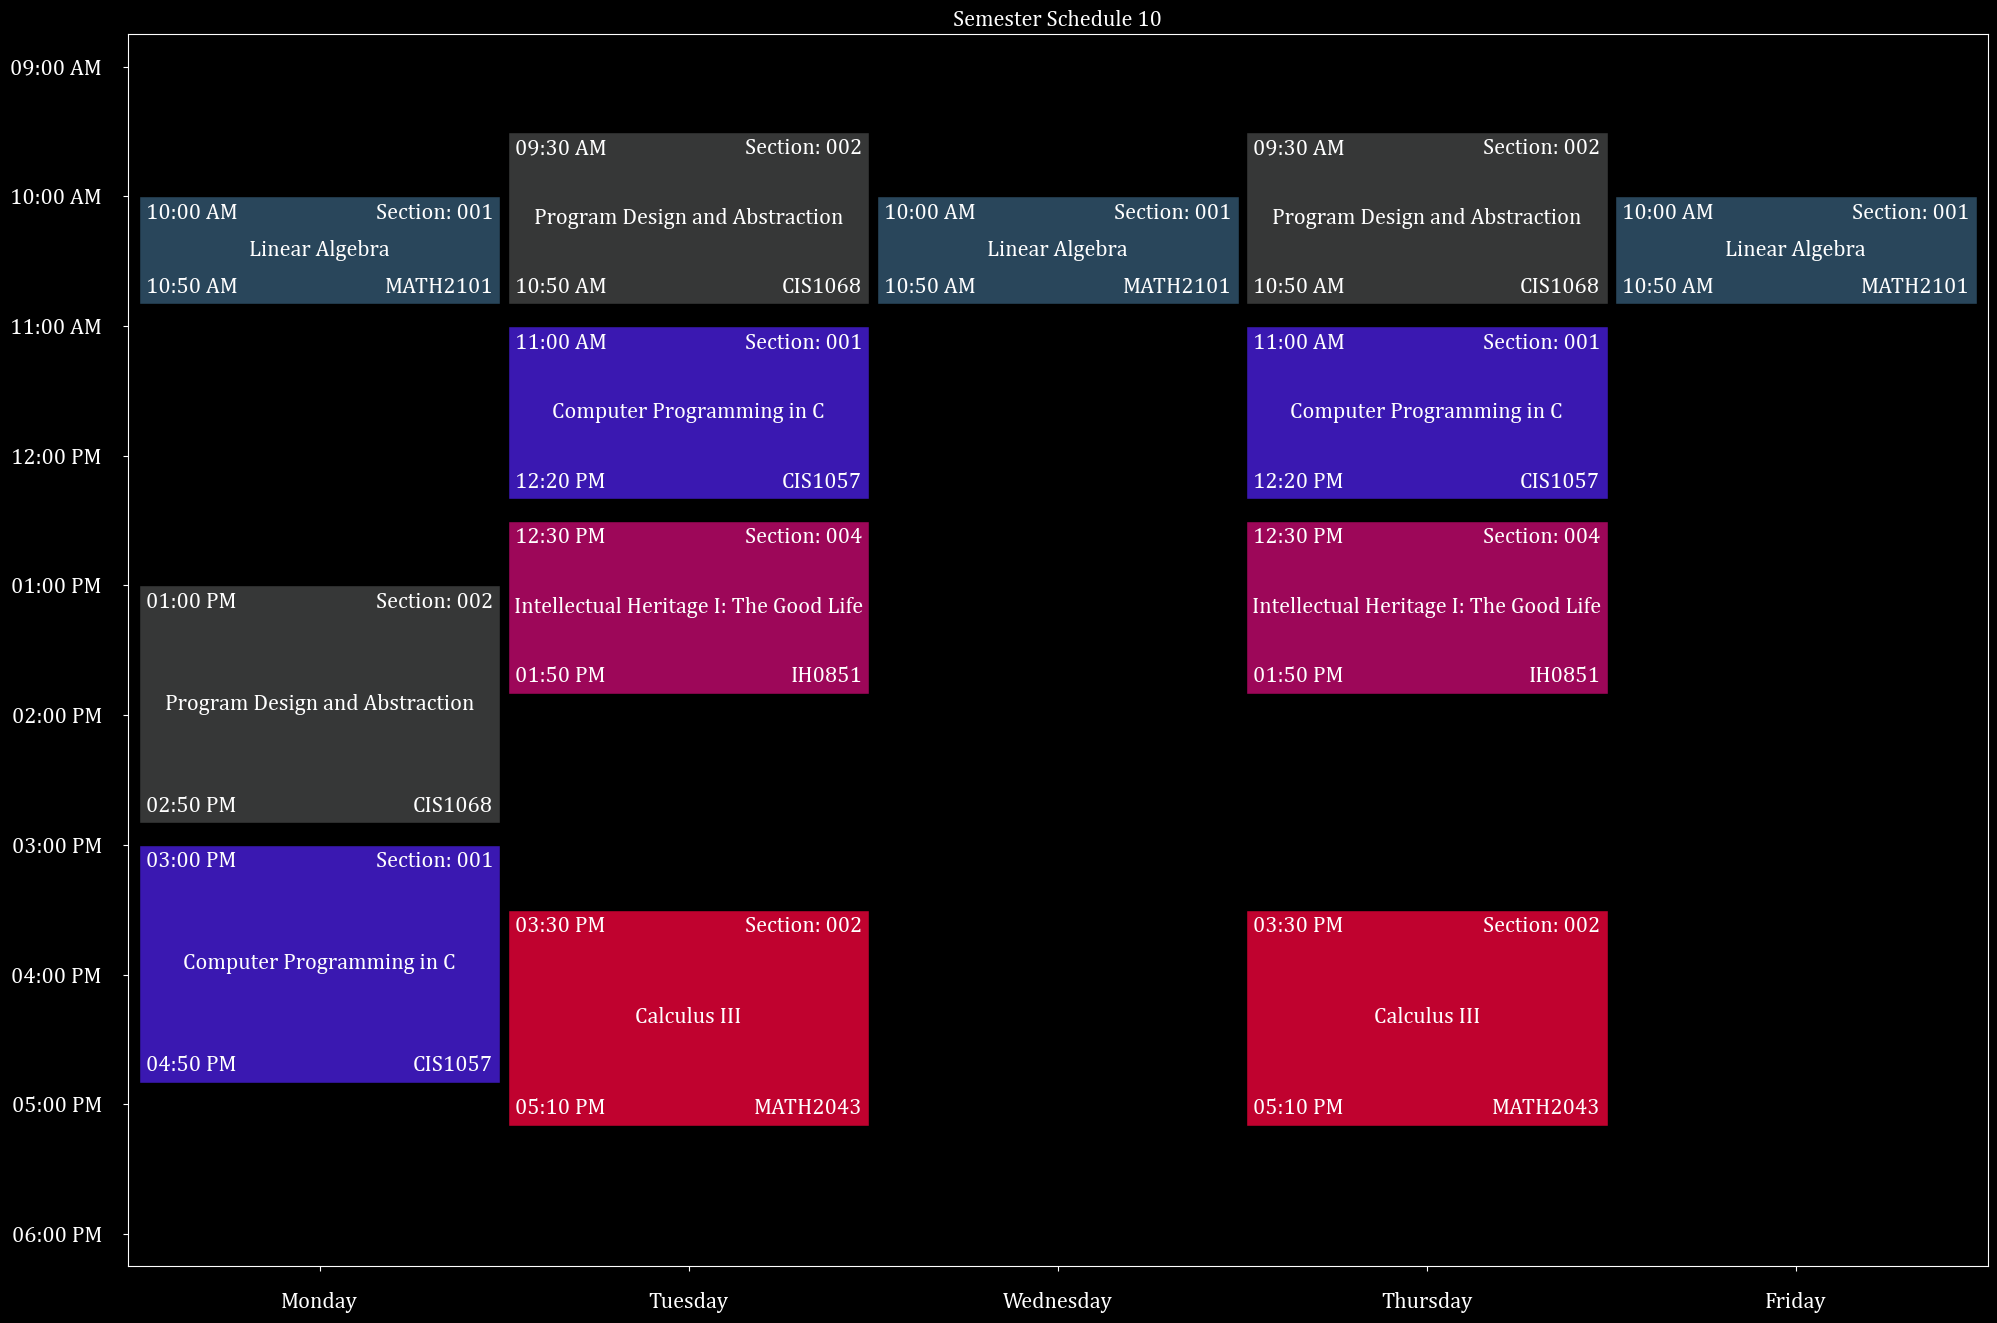

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 002 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 010 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


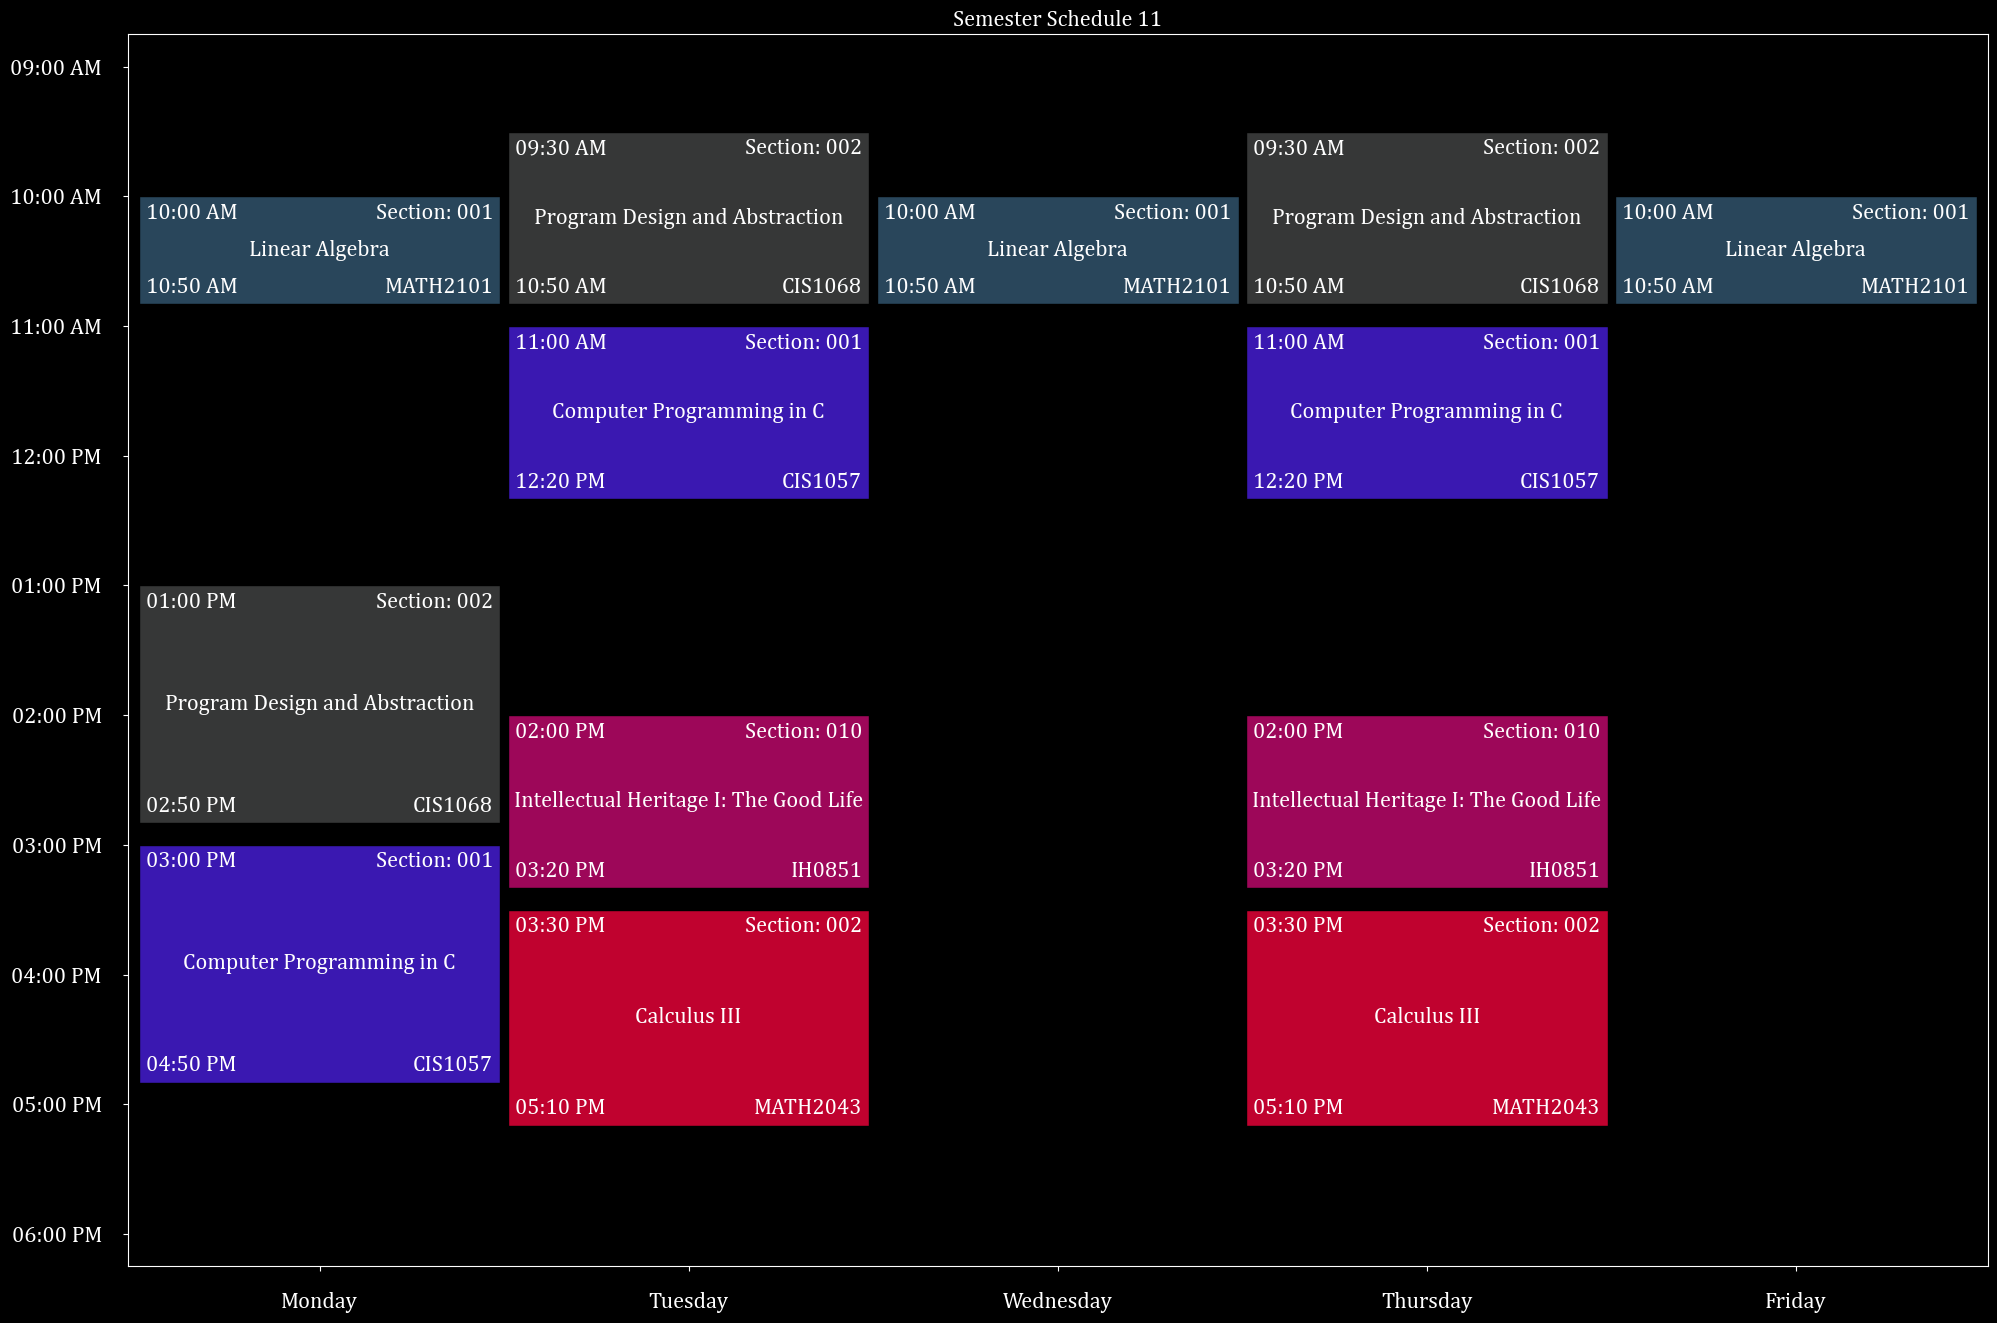

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 003 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 004 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


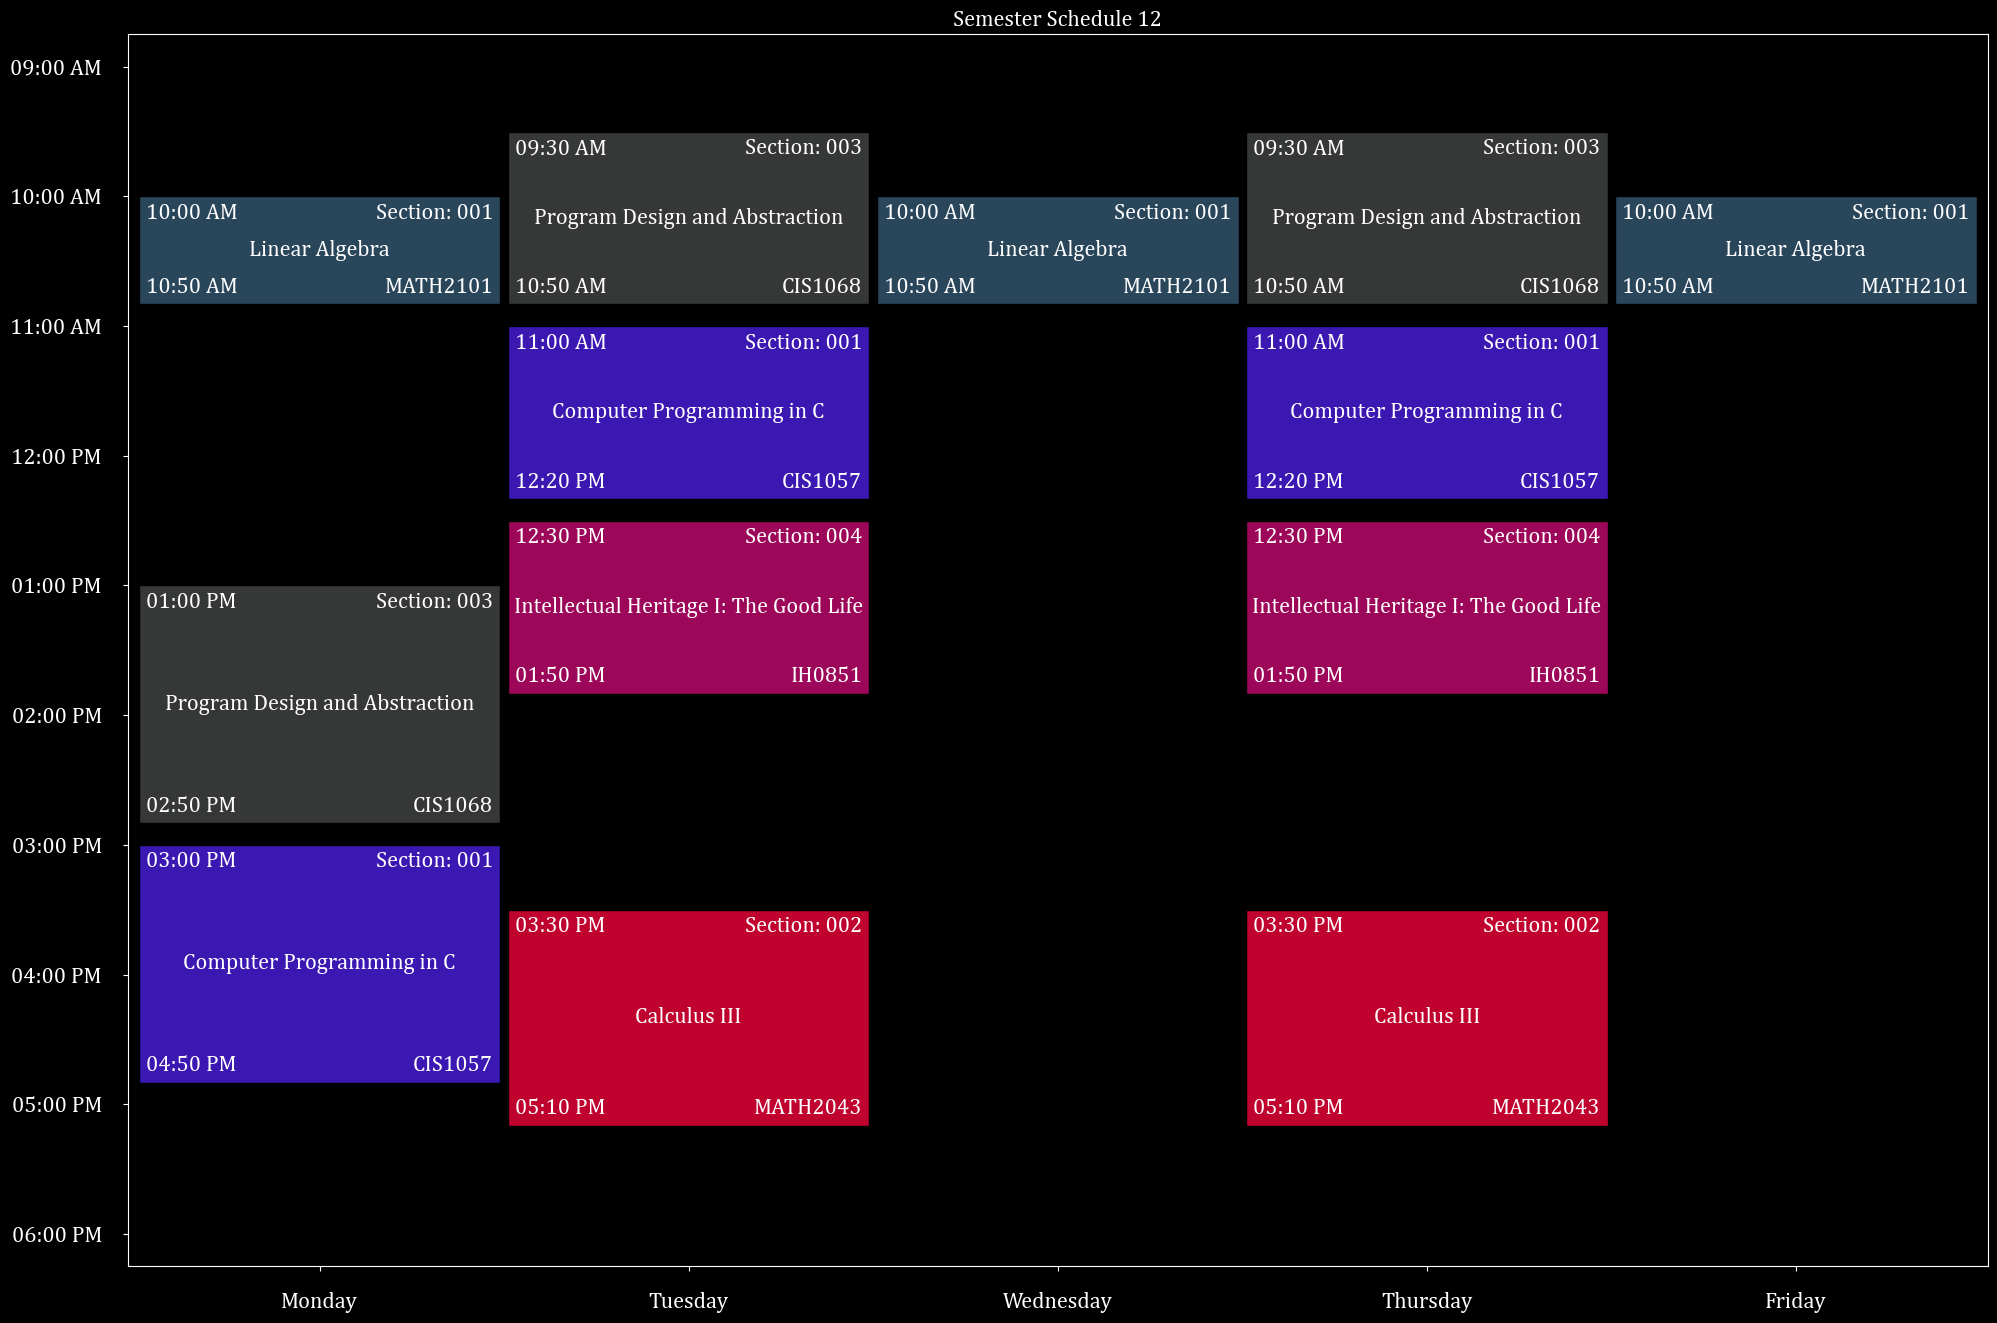

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 003 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 010 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


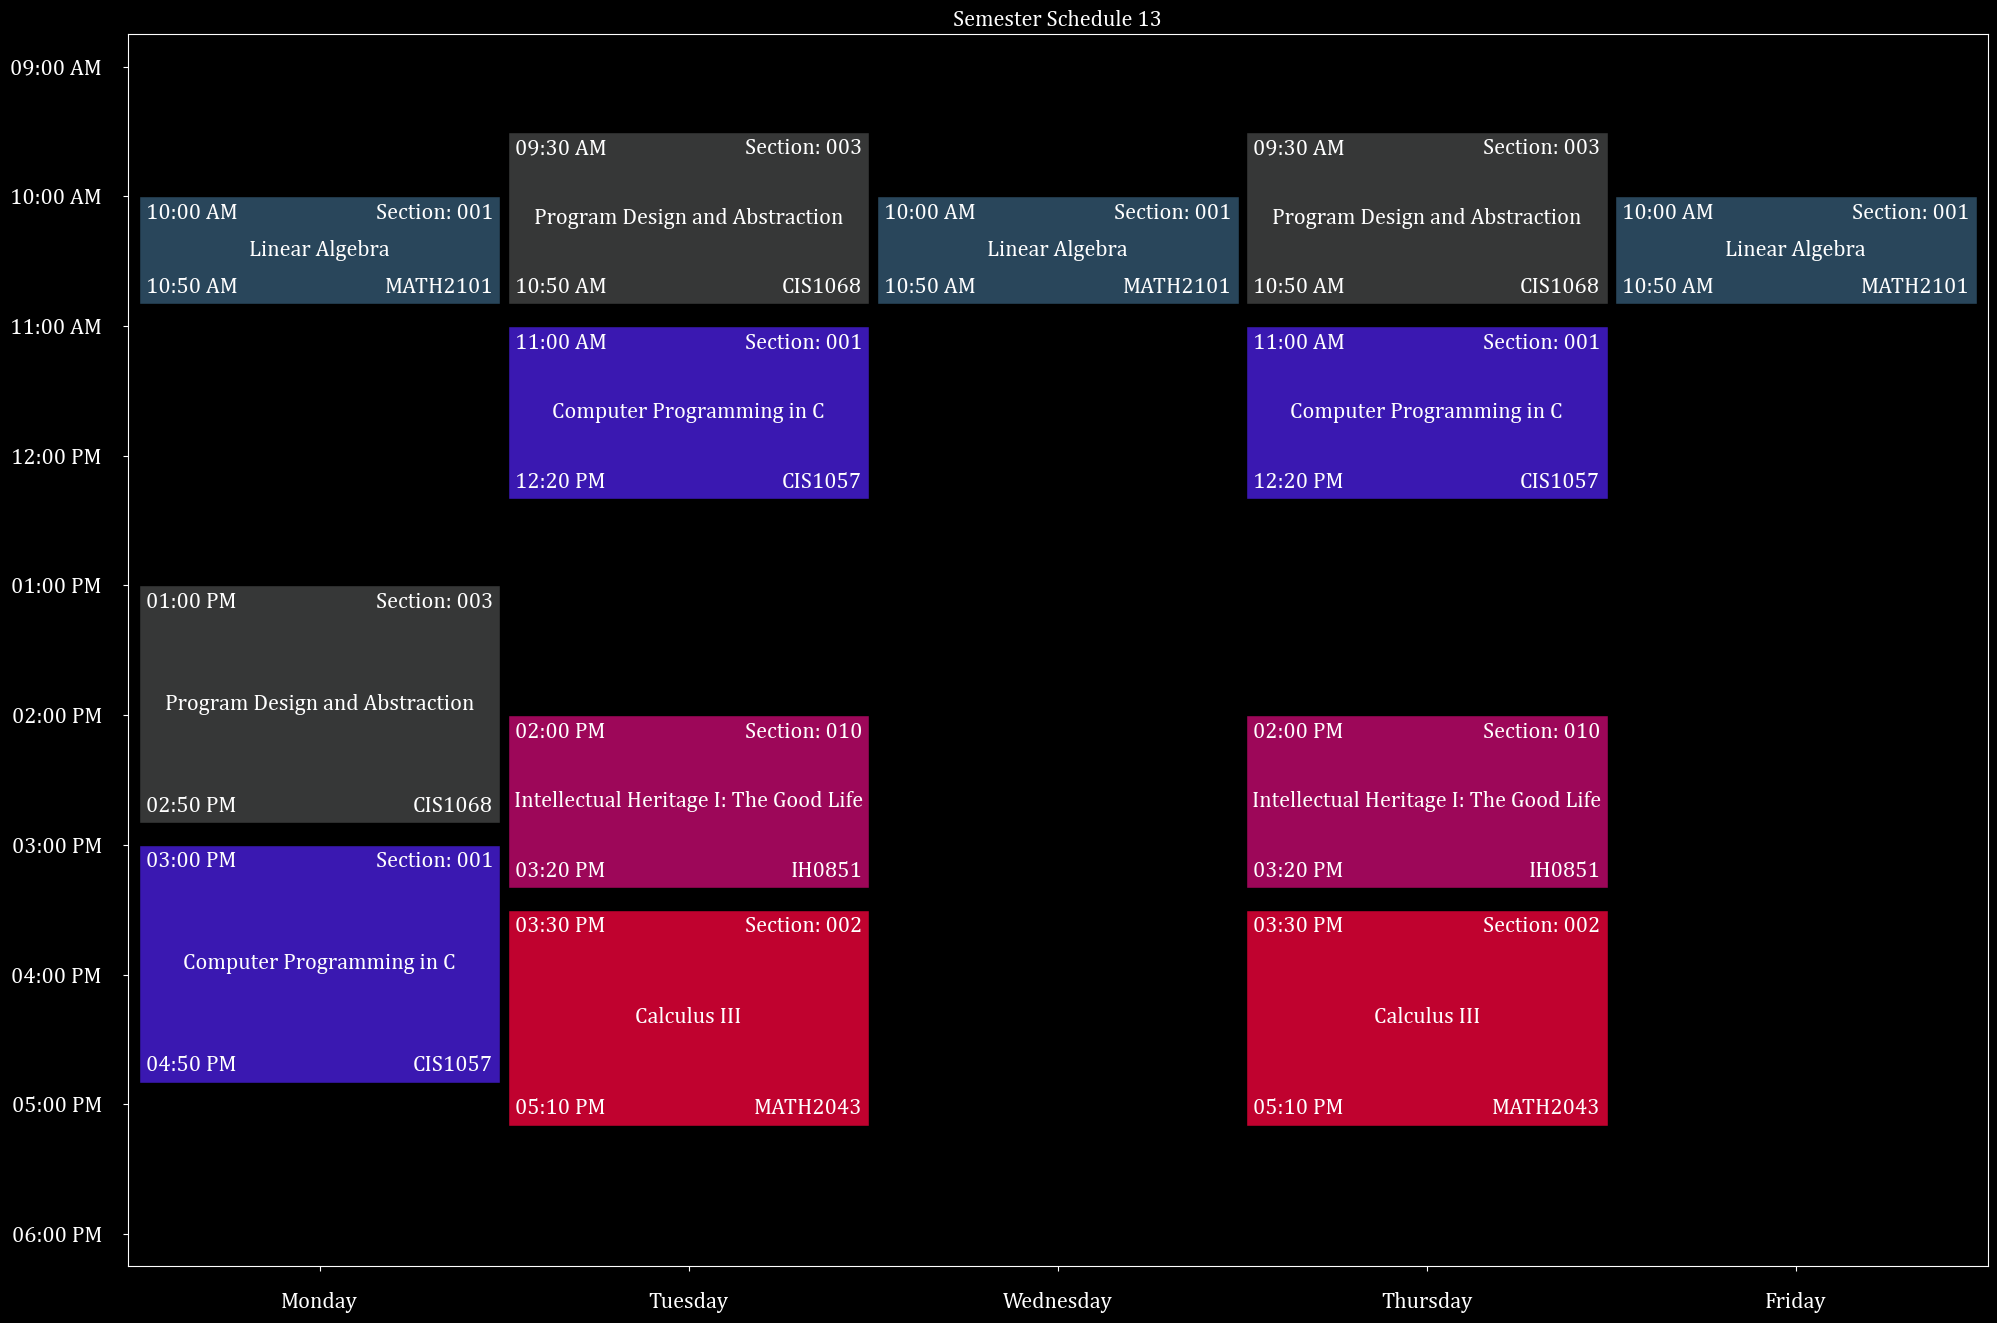

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 004 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 004 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


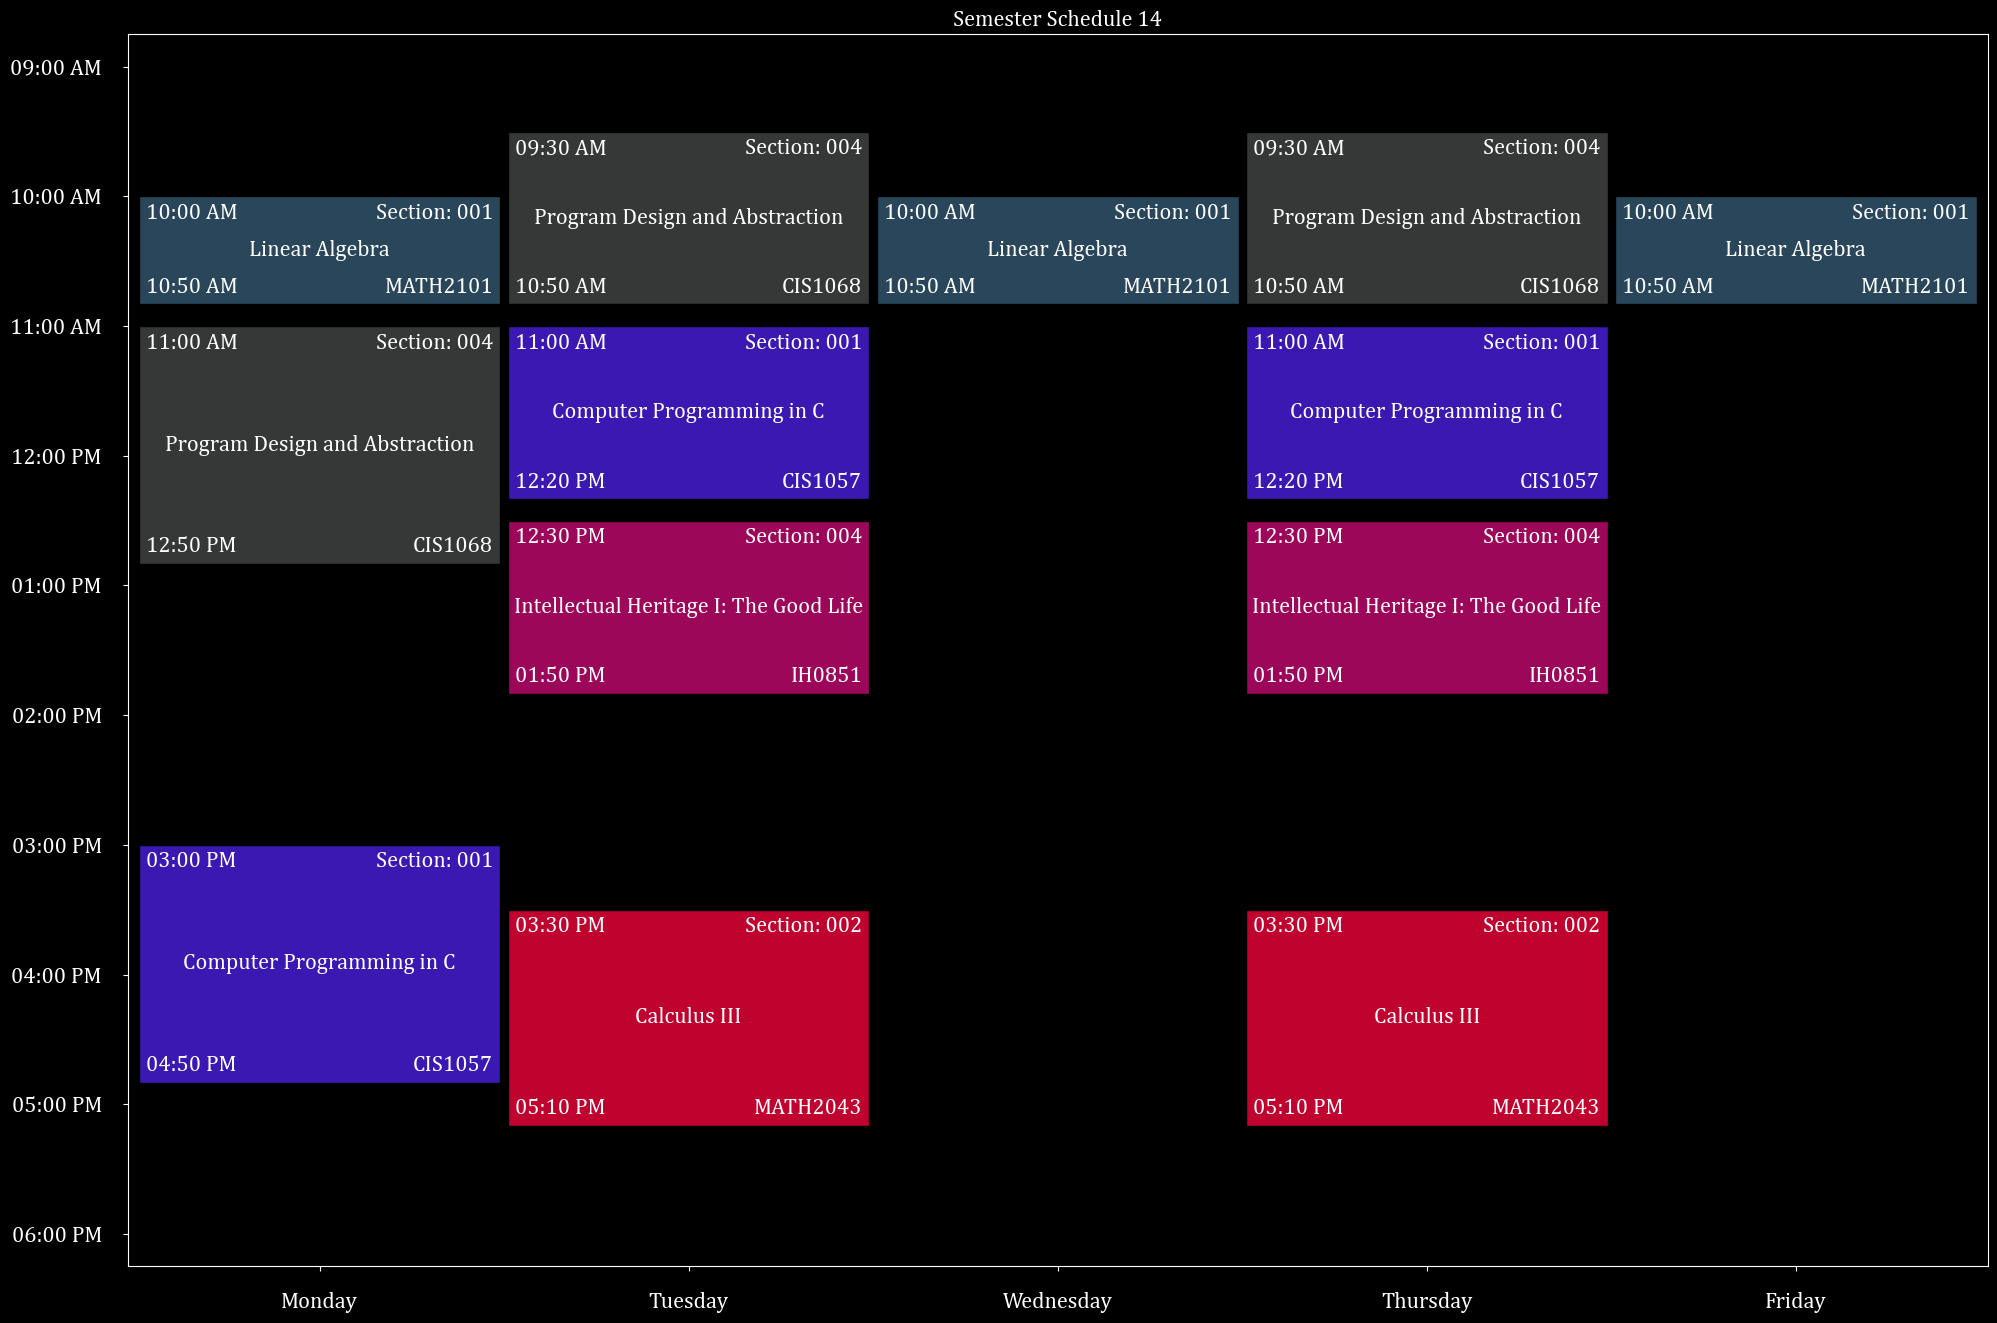

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 004 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 010 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


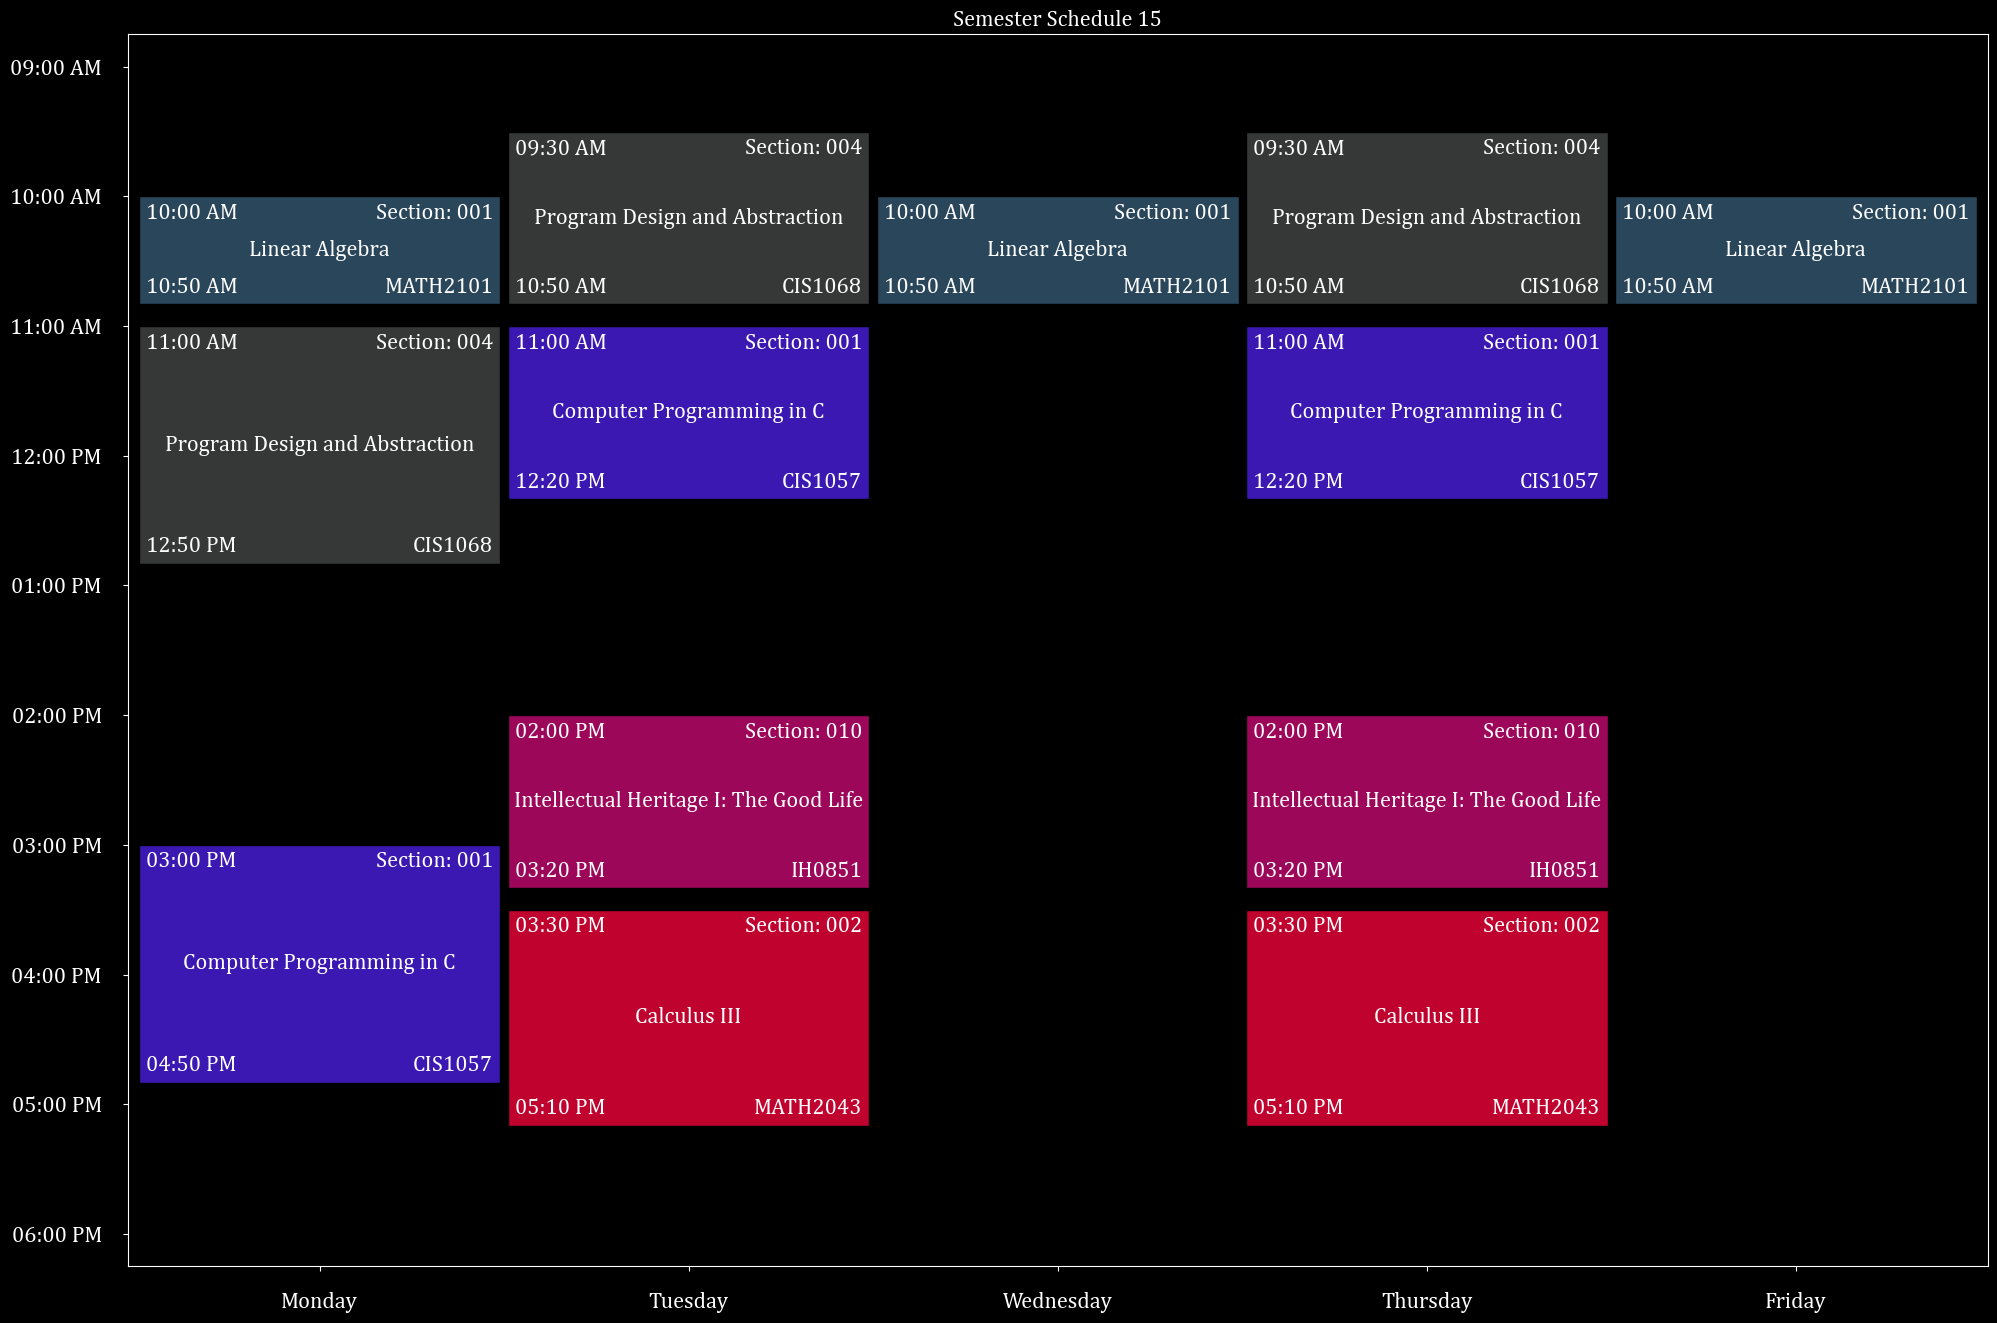

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 005 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 004 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


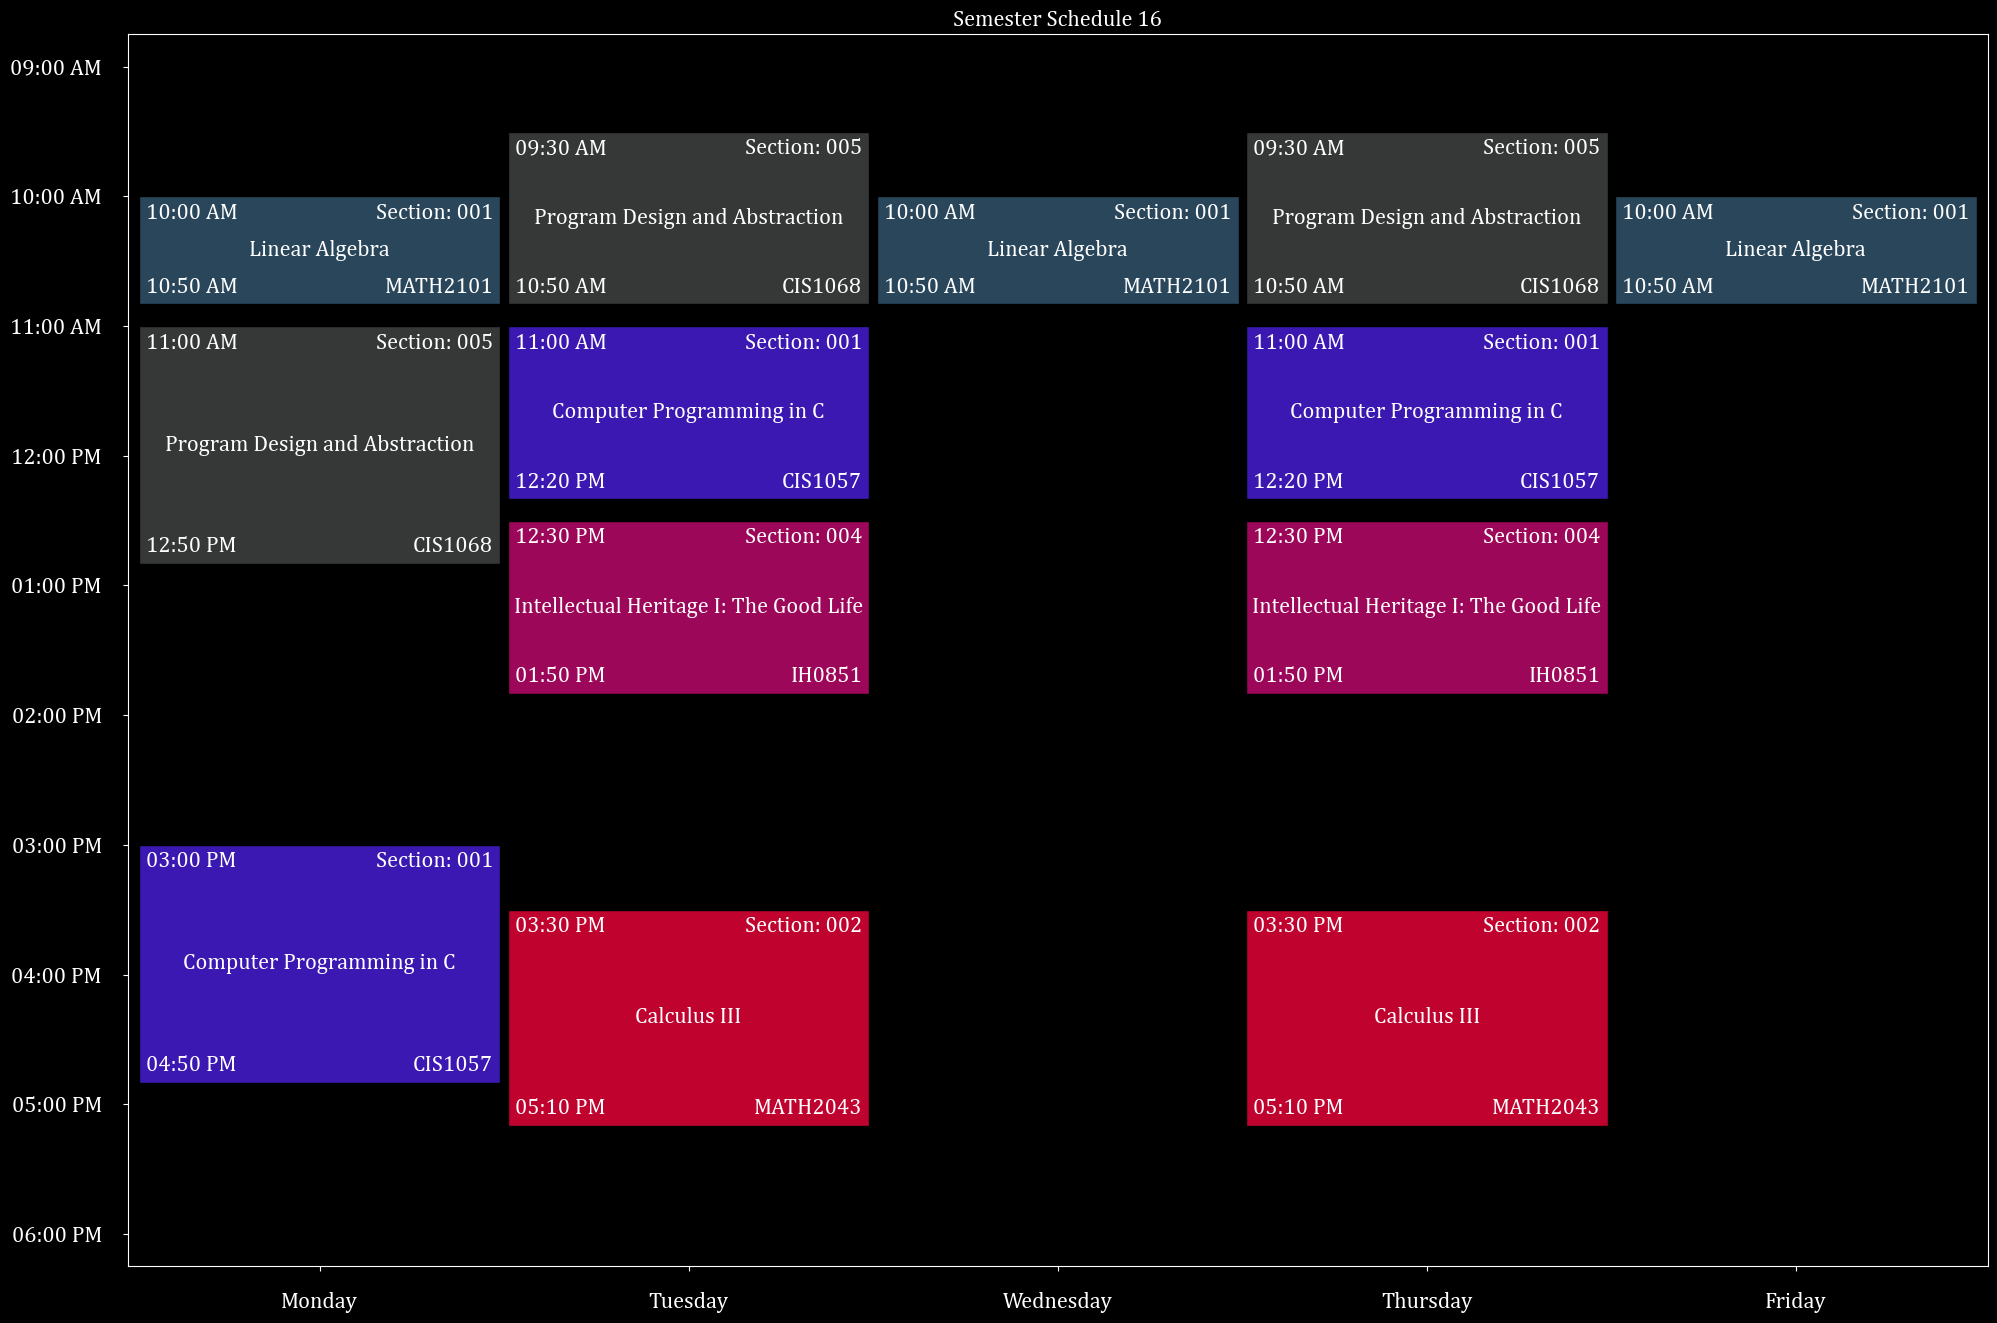

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 005 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 010 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


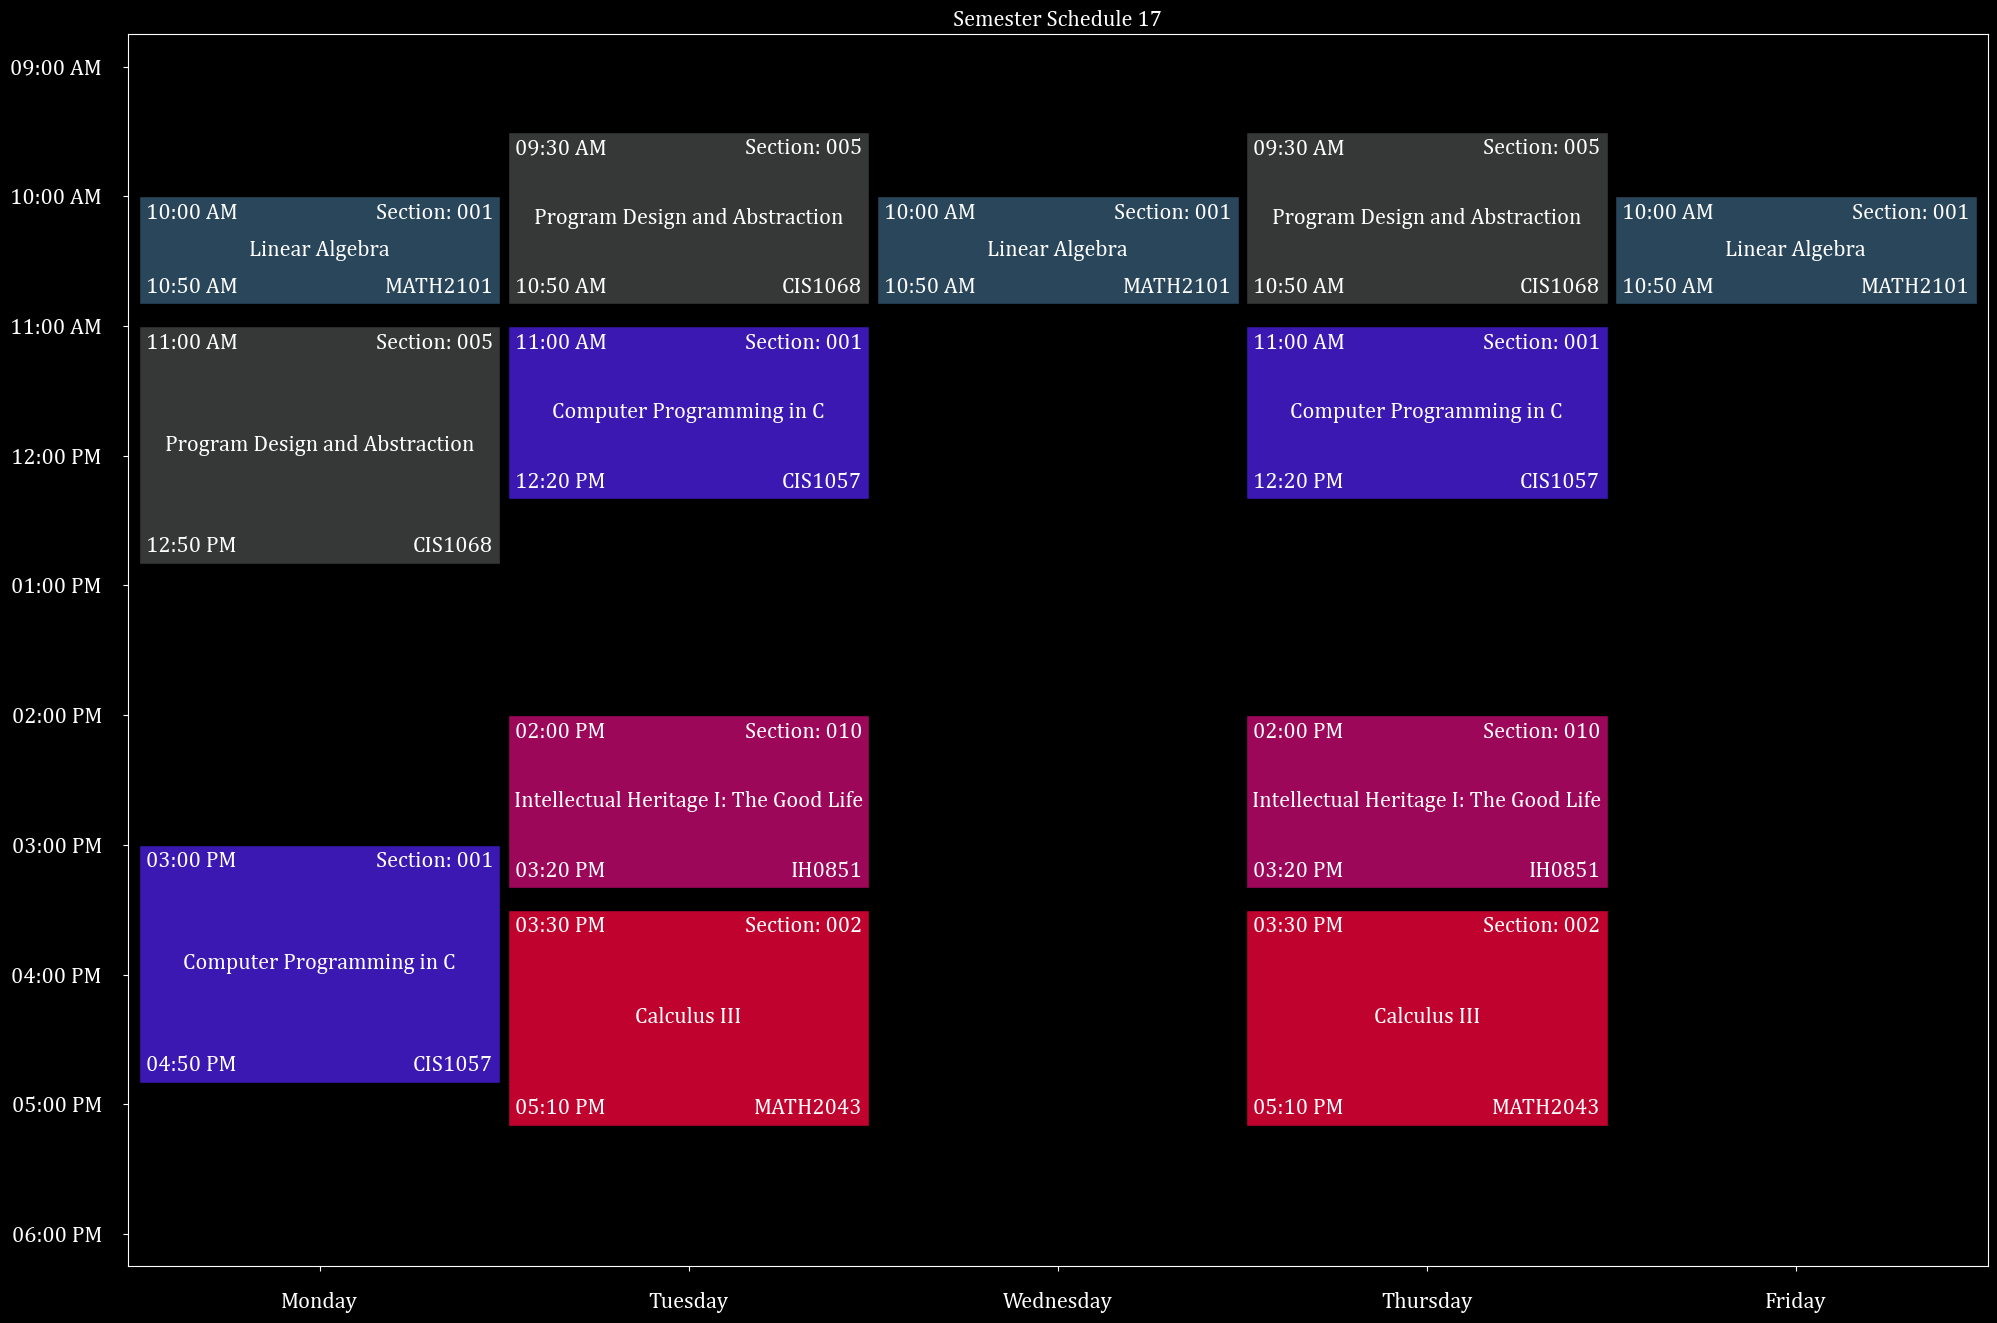

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 006 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 004 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


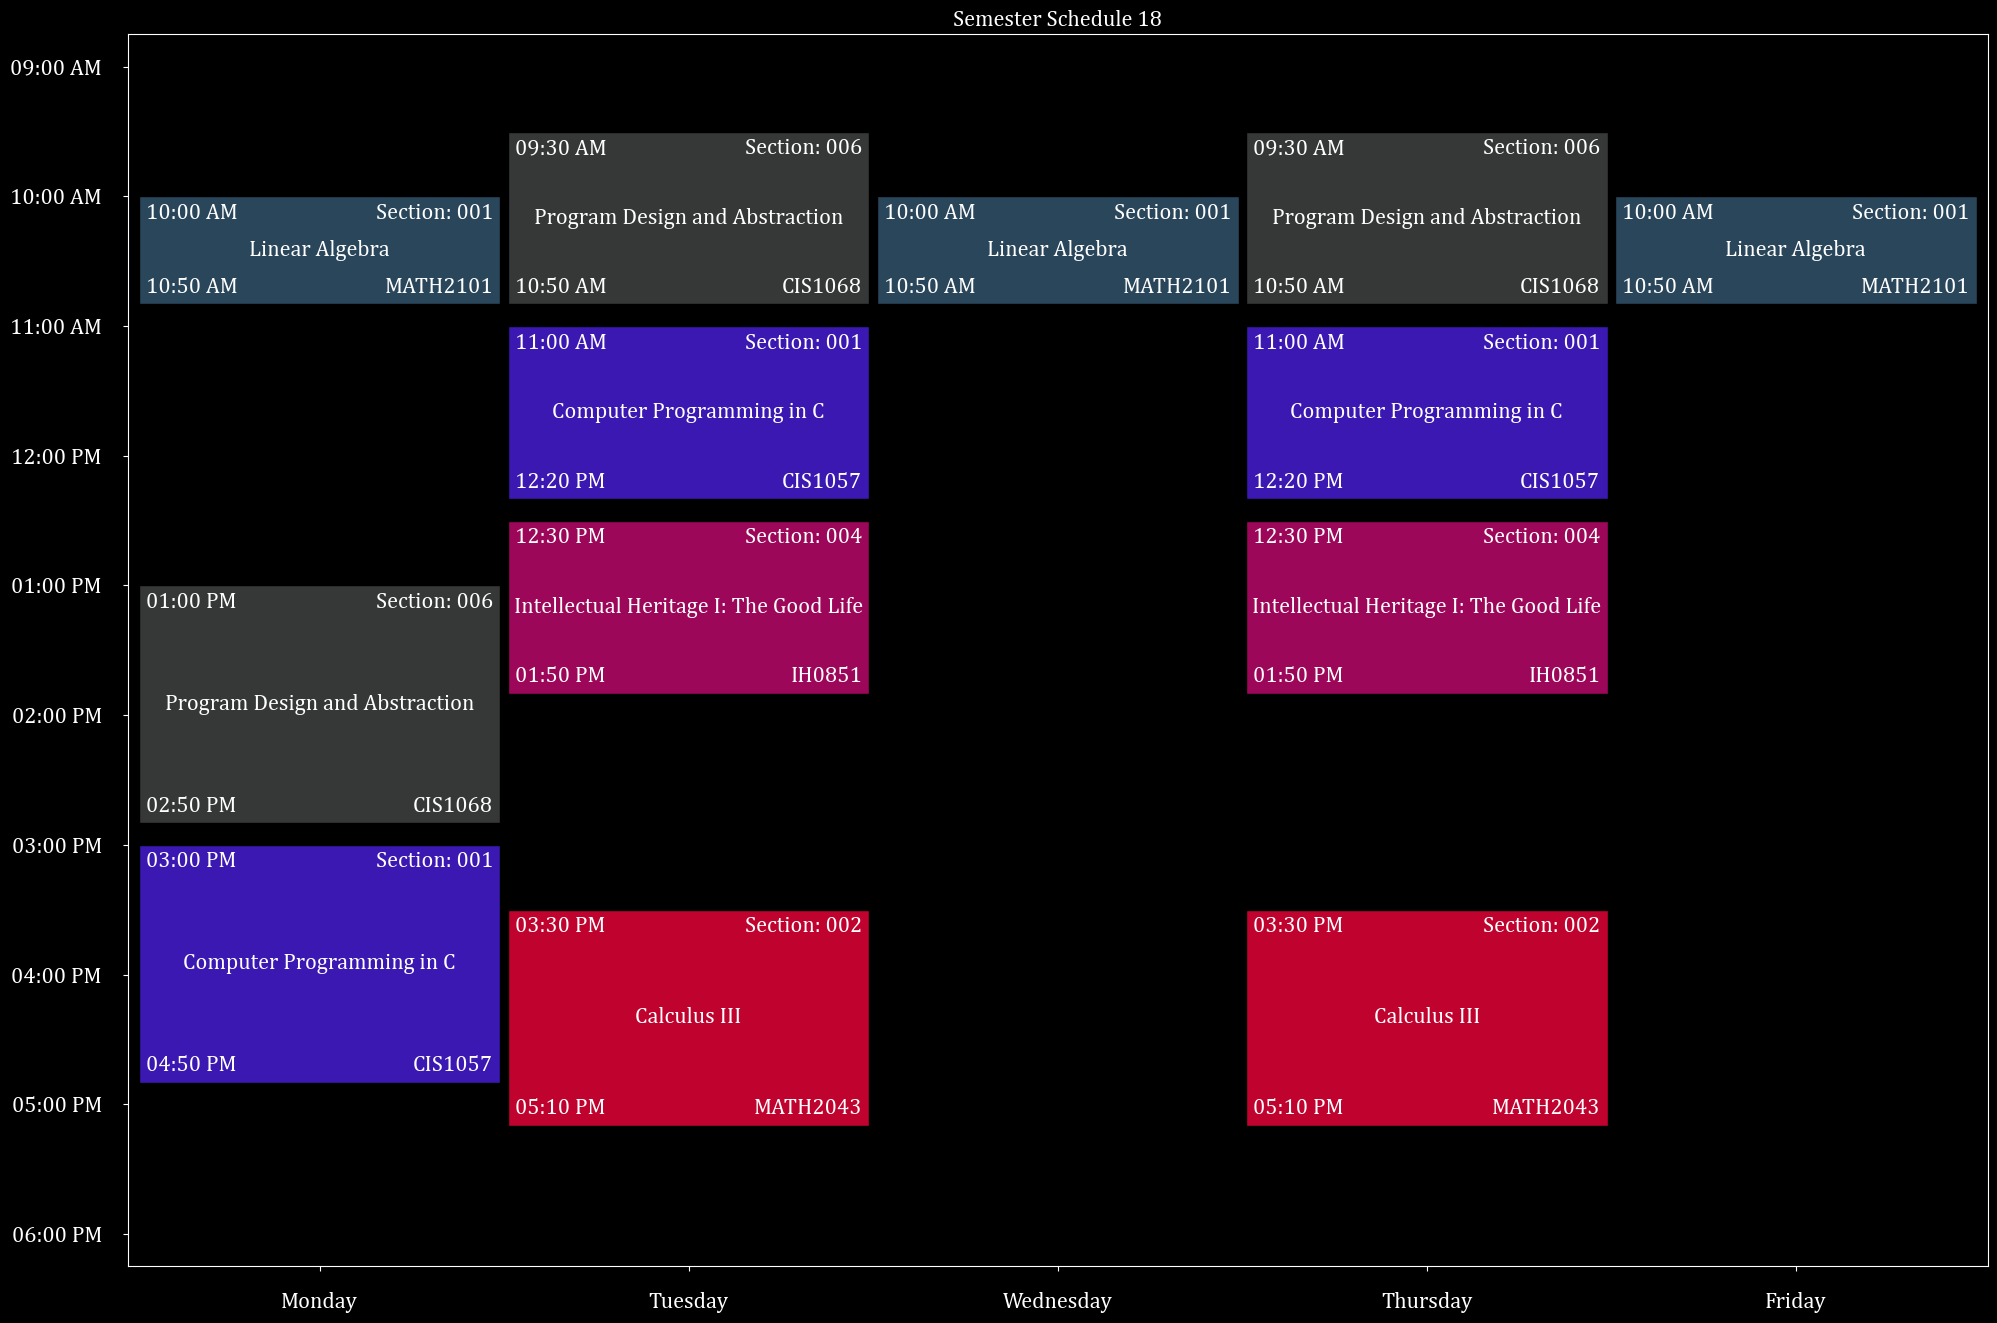

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 006 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 010 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


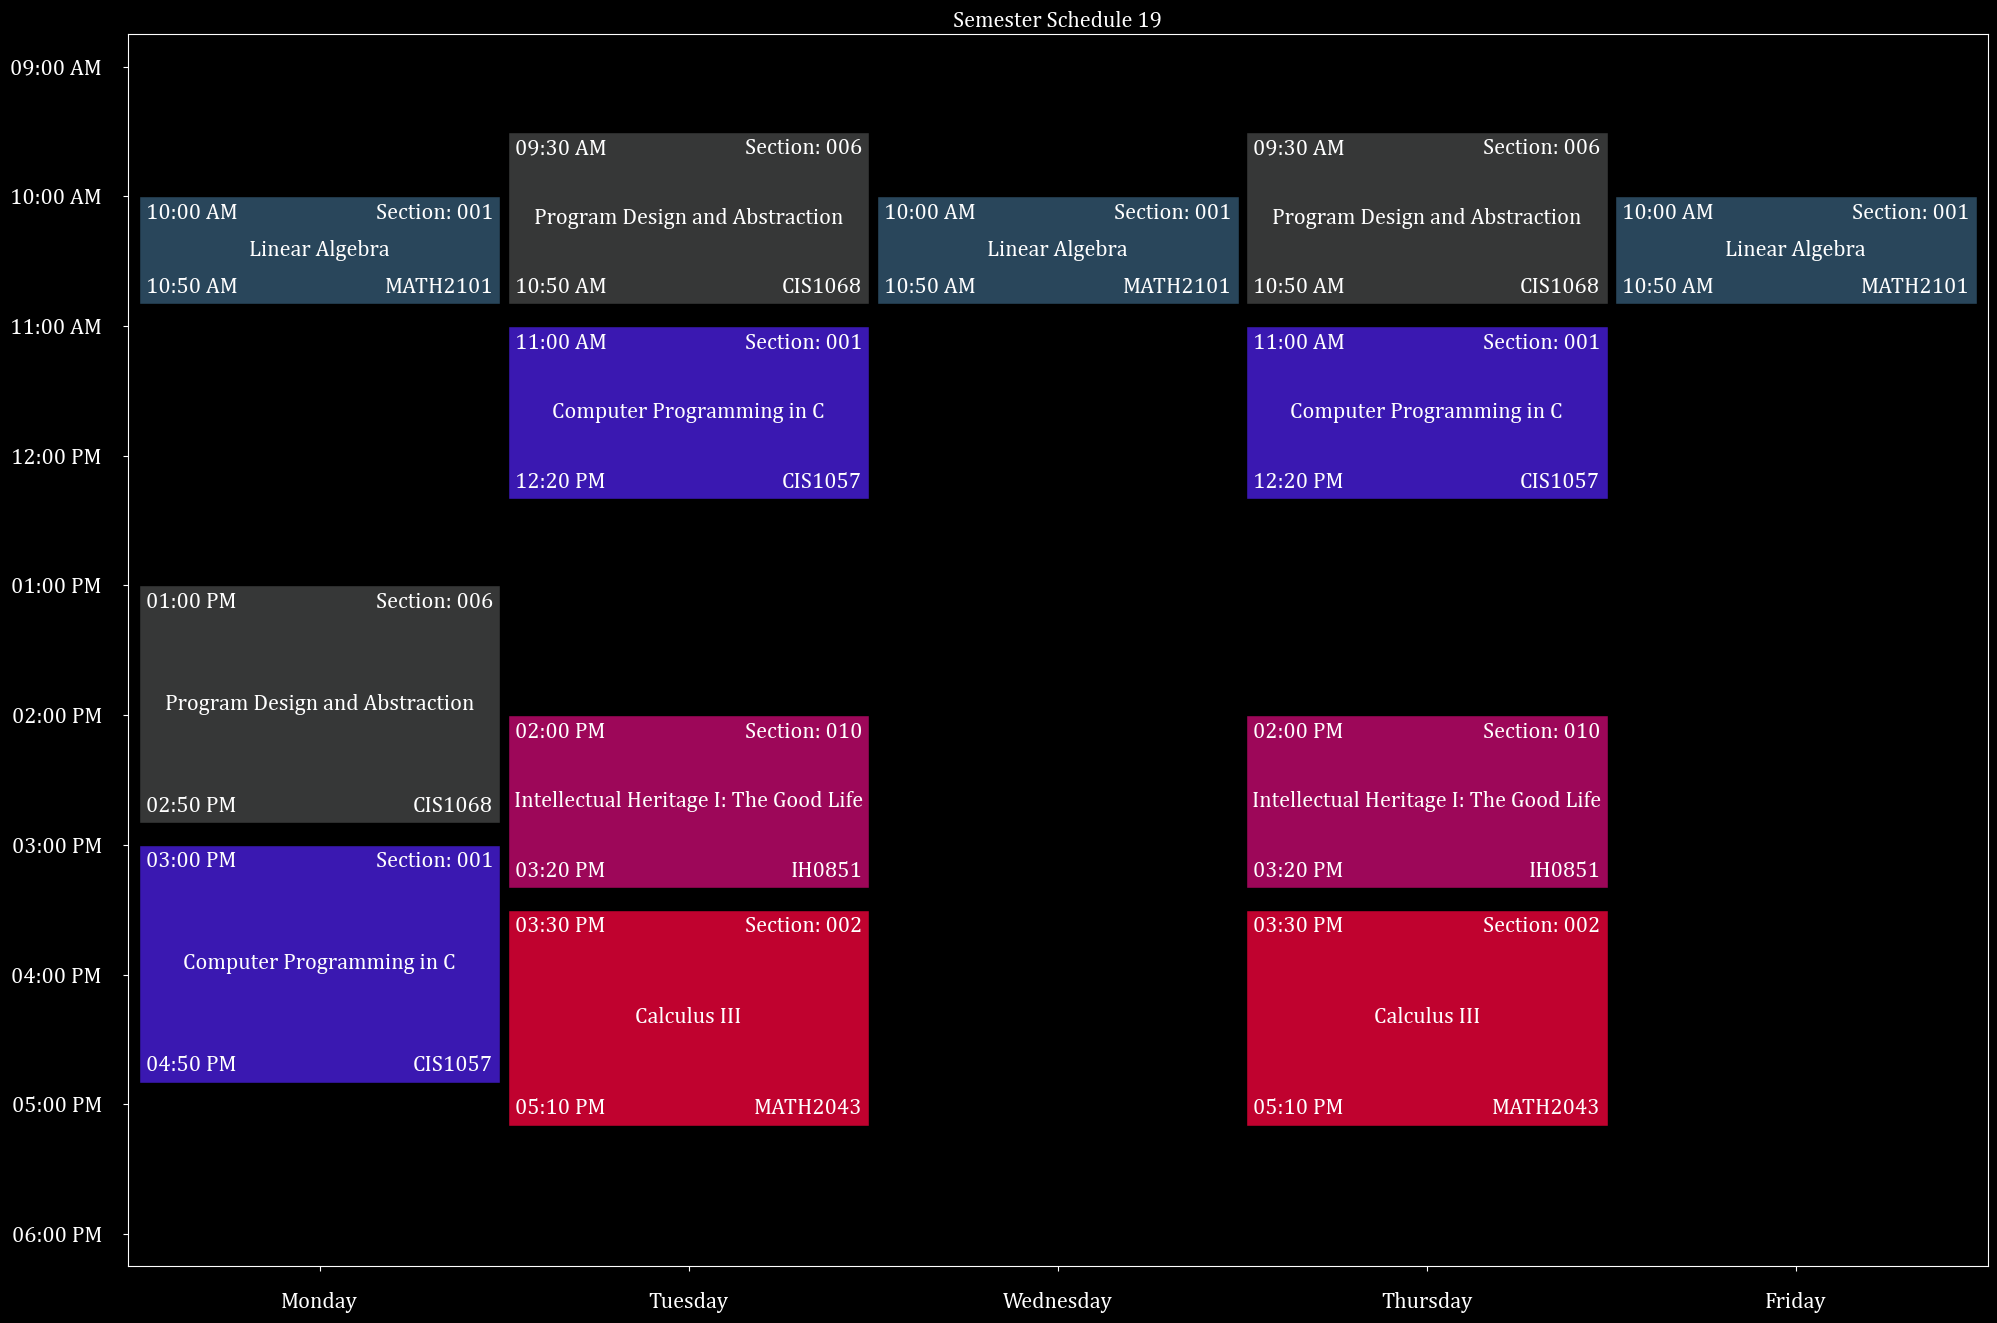

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(8 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 007 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 004 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


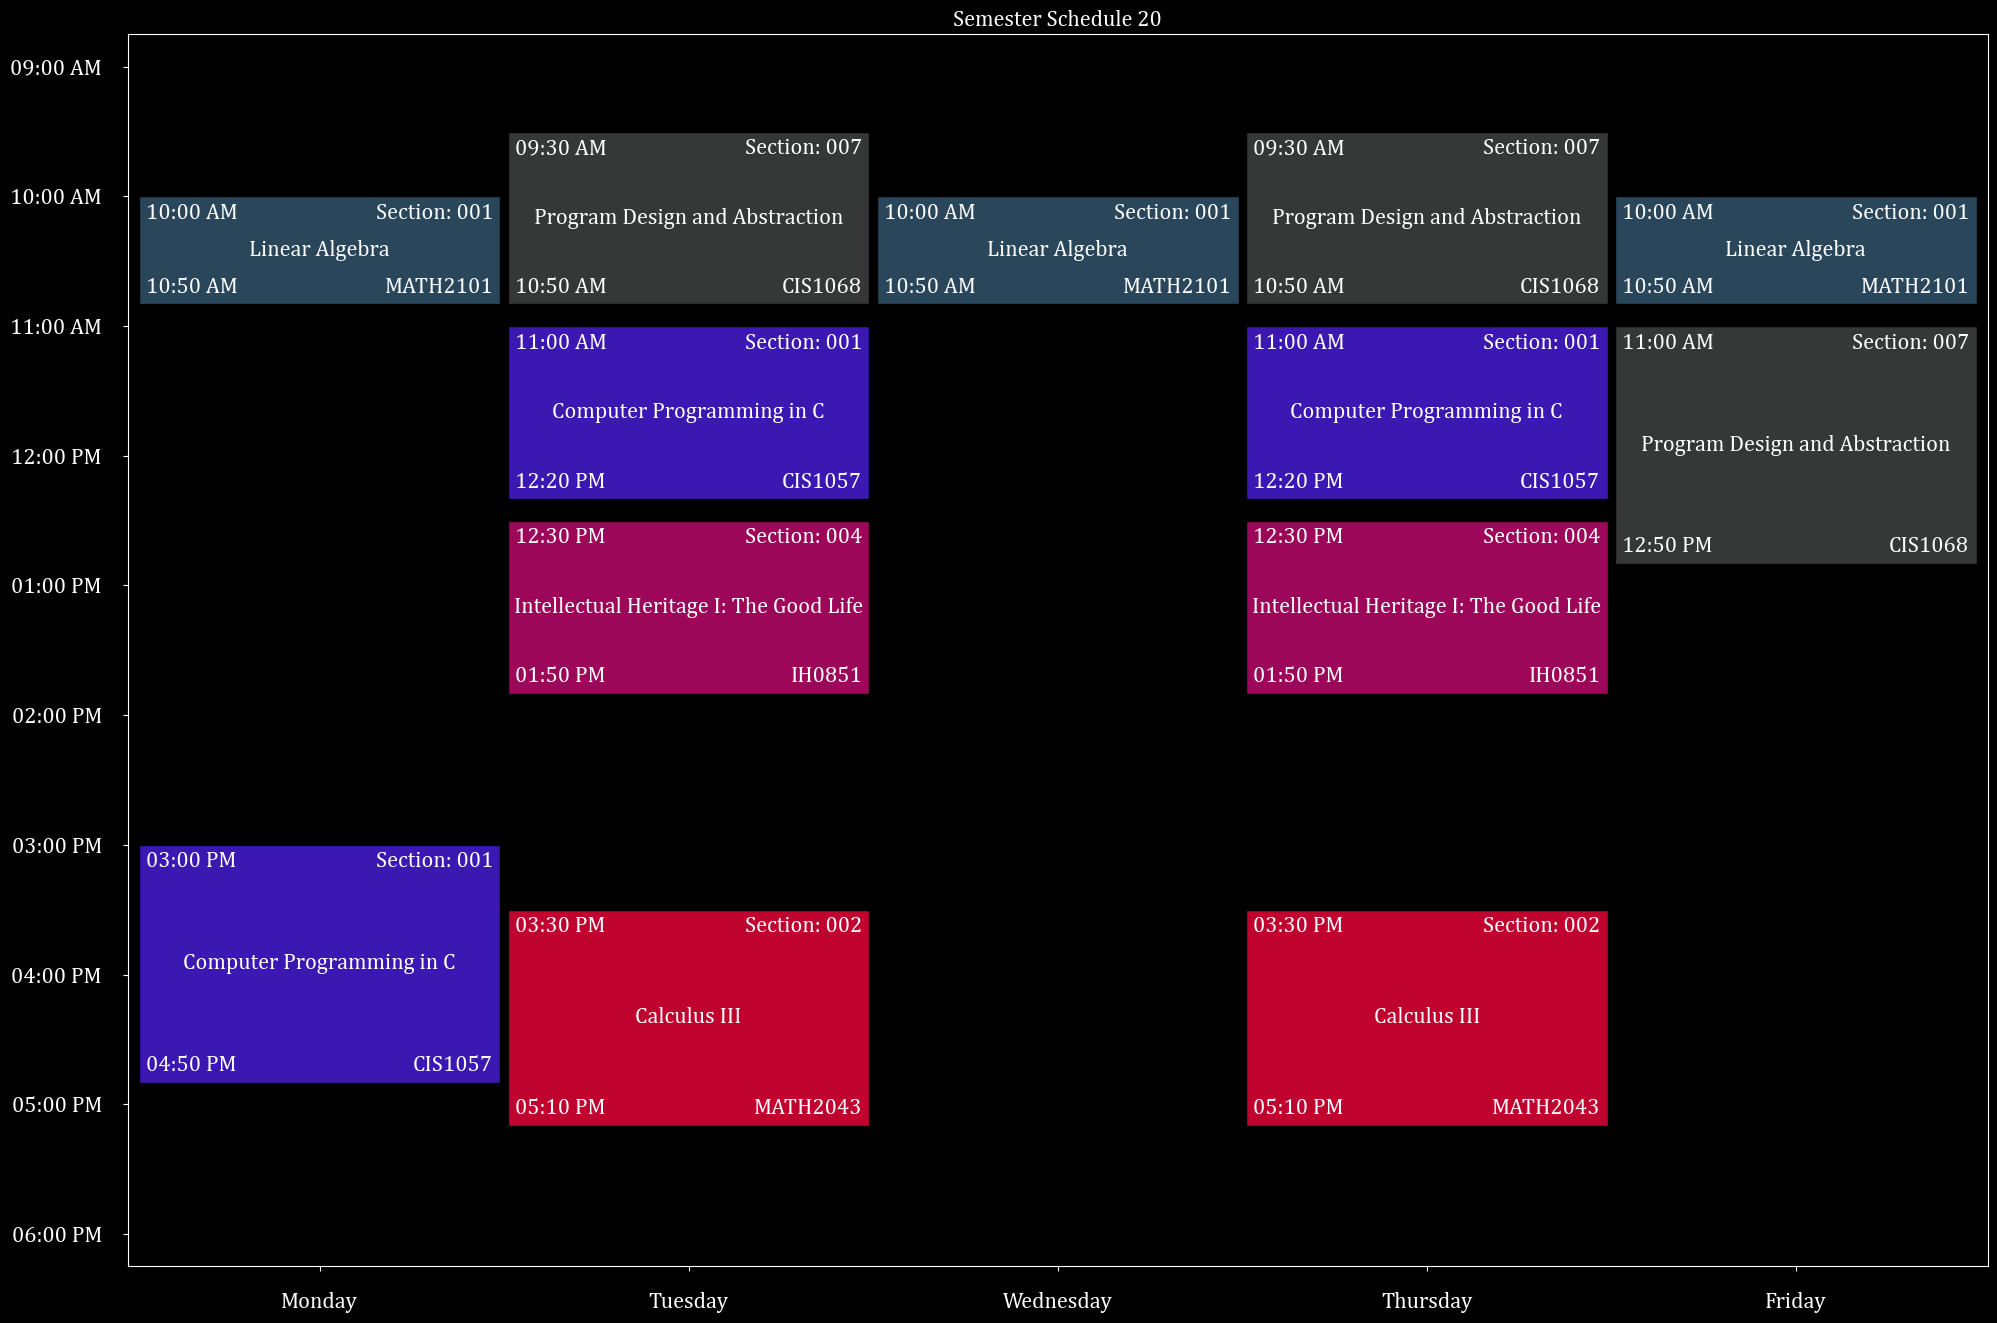

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(8 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 007 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 010 | Maurizio Giammarco | 3.90 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.188 avg


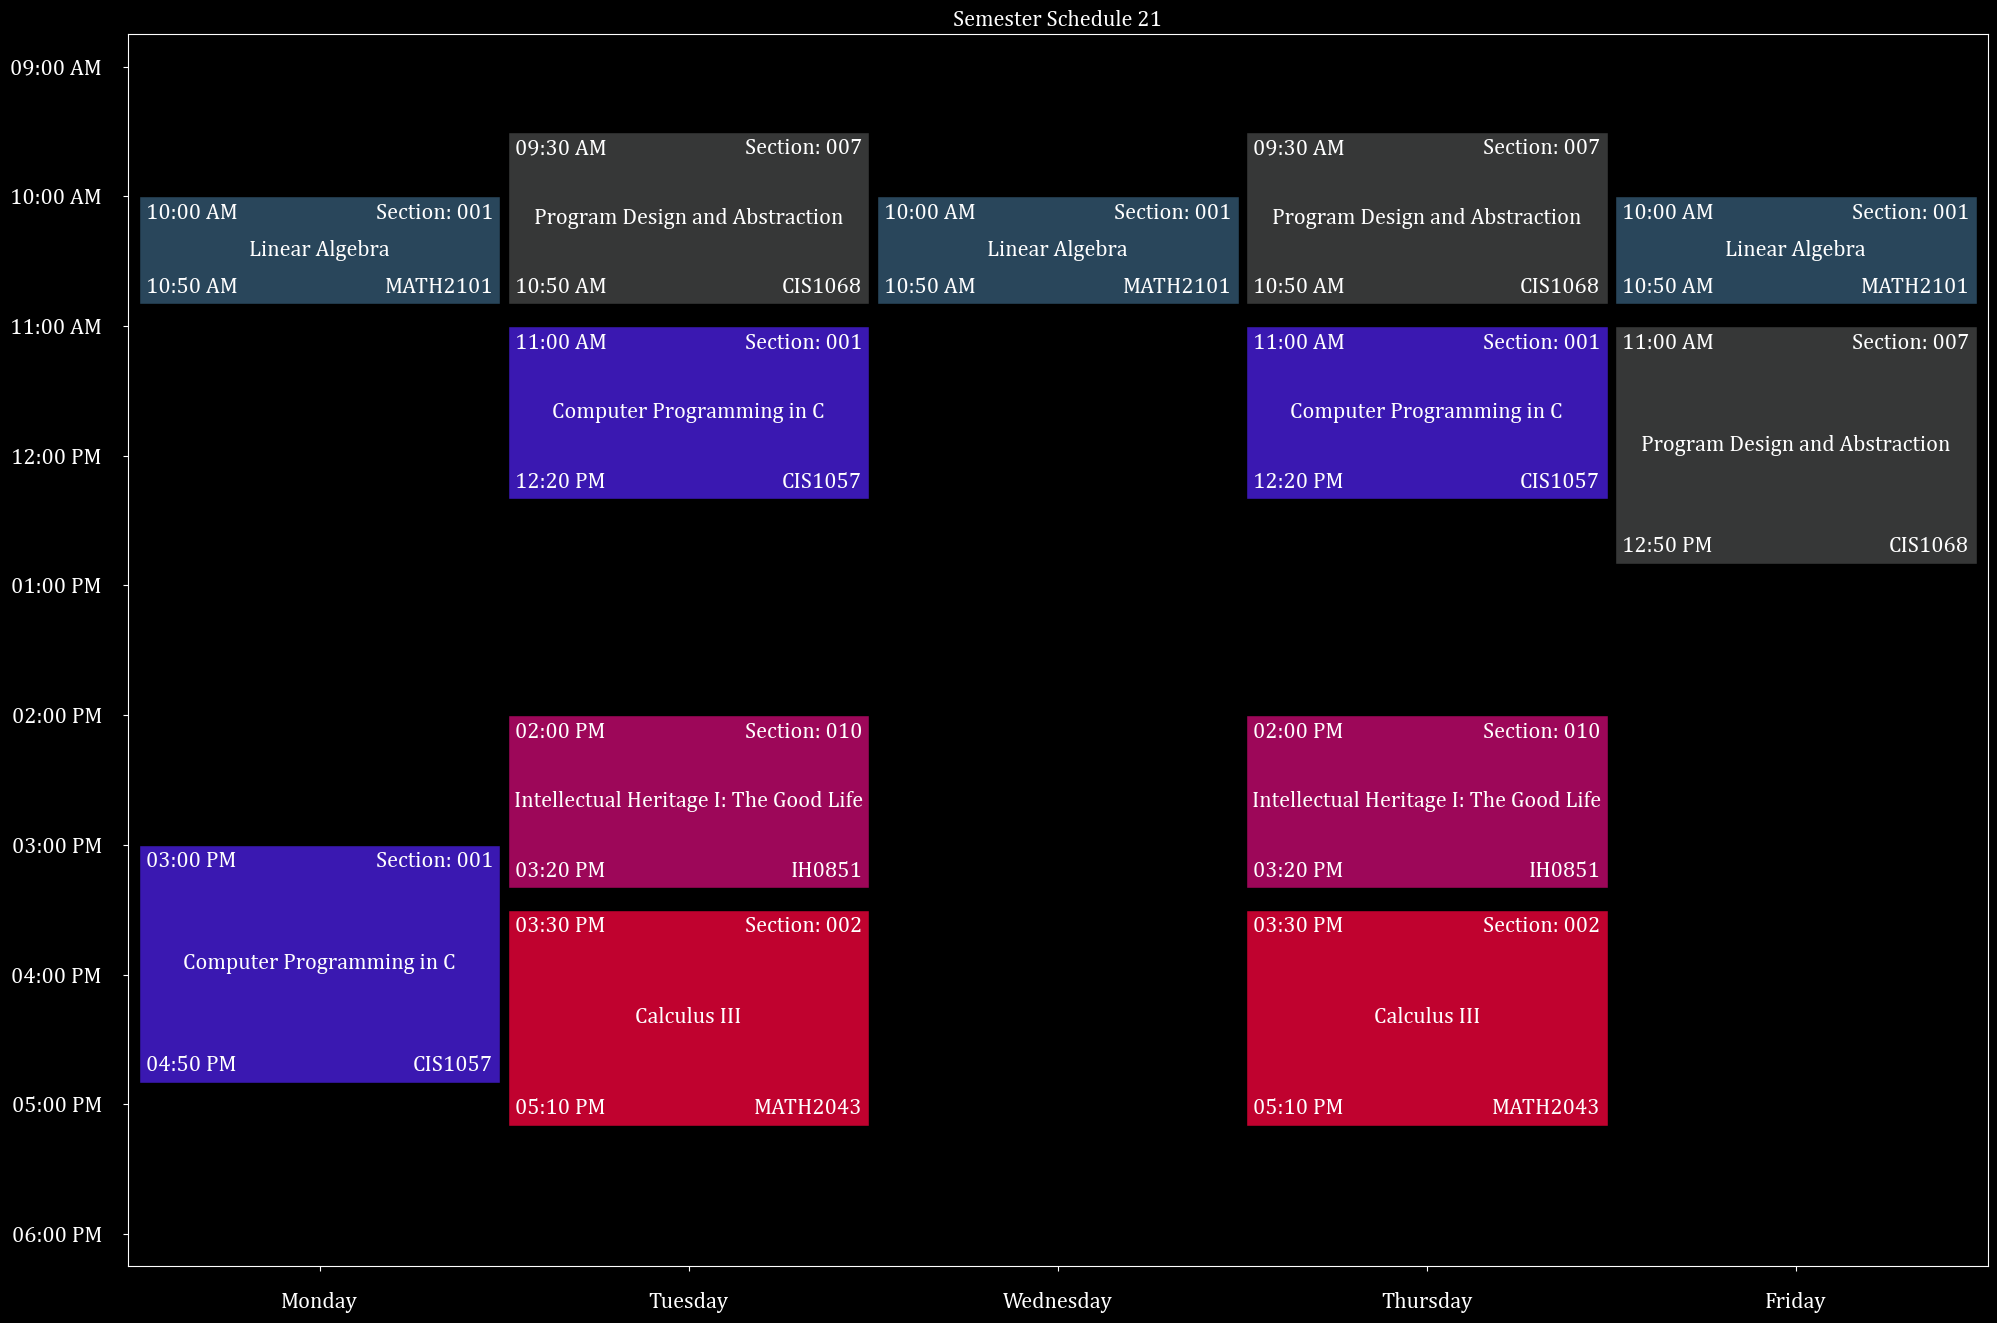

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 710 | Susan Bertolino | 4.70 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.179 avg


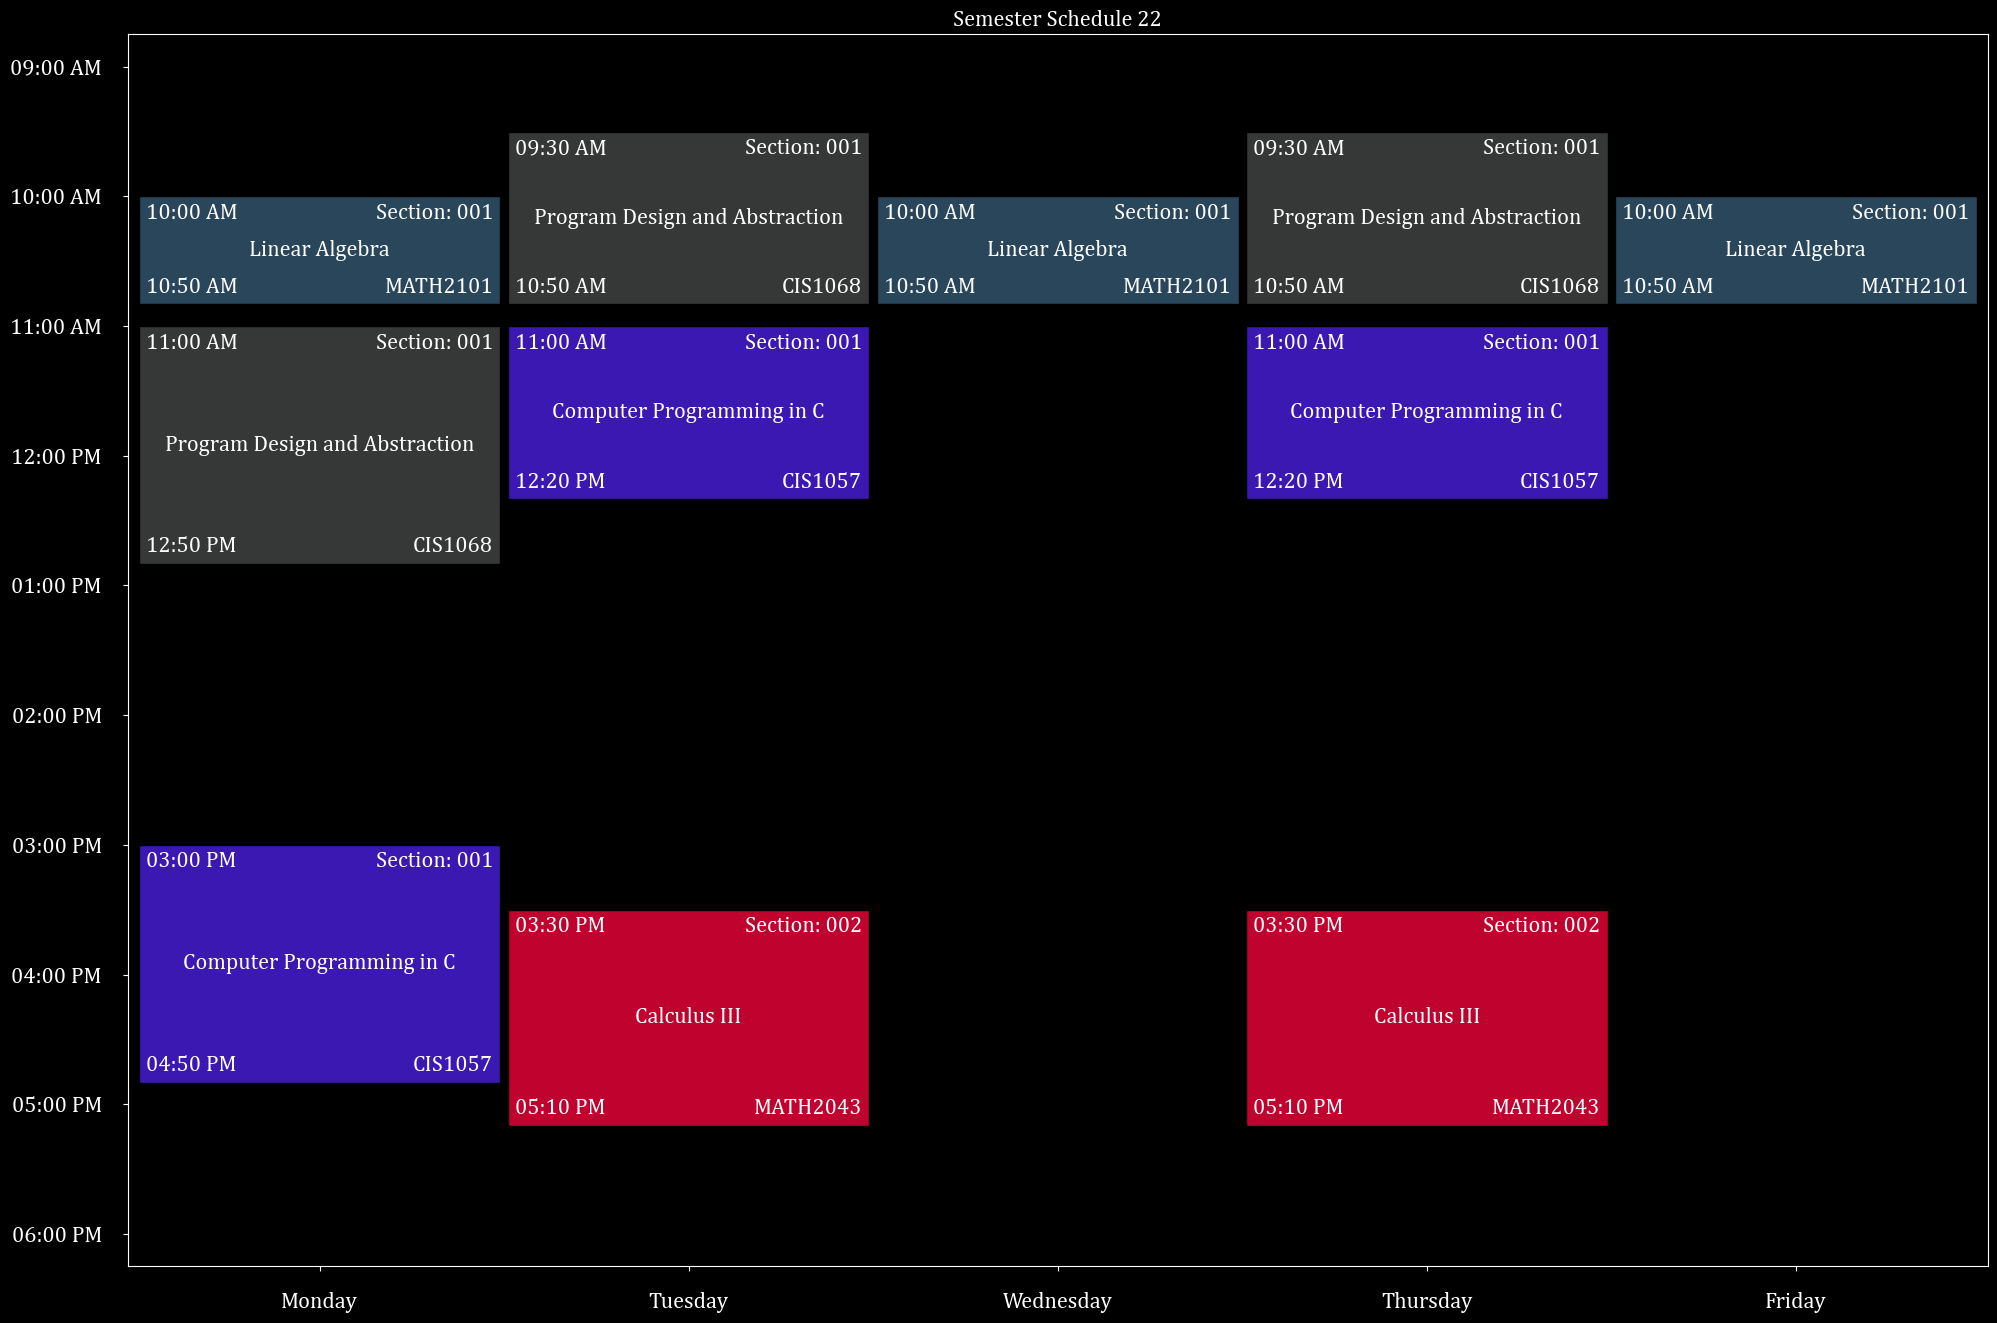

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 002 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 710 | Susan Bertolino | 4.70 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.179 avg


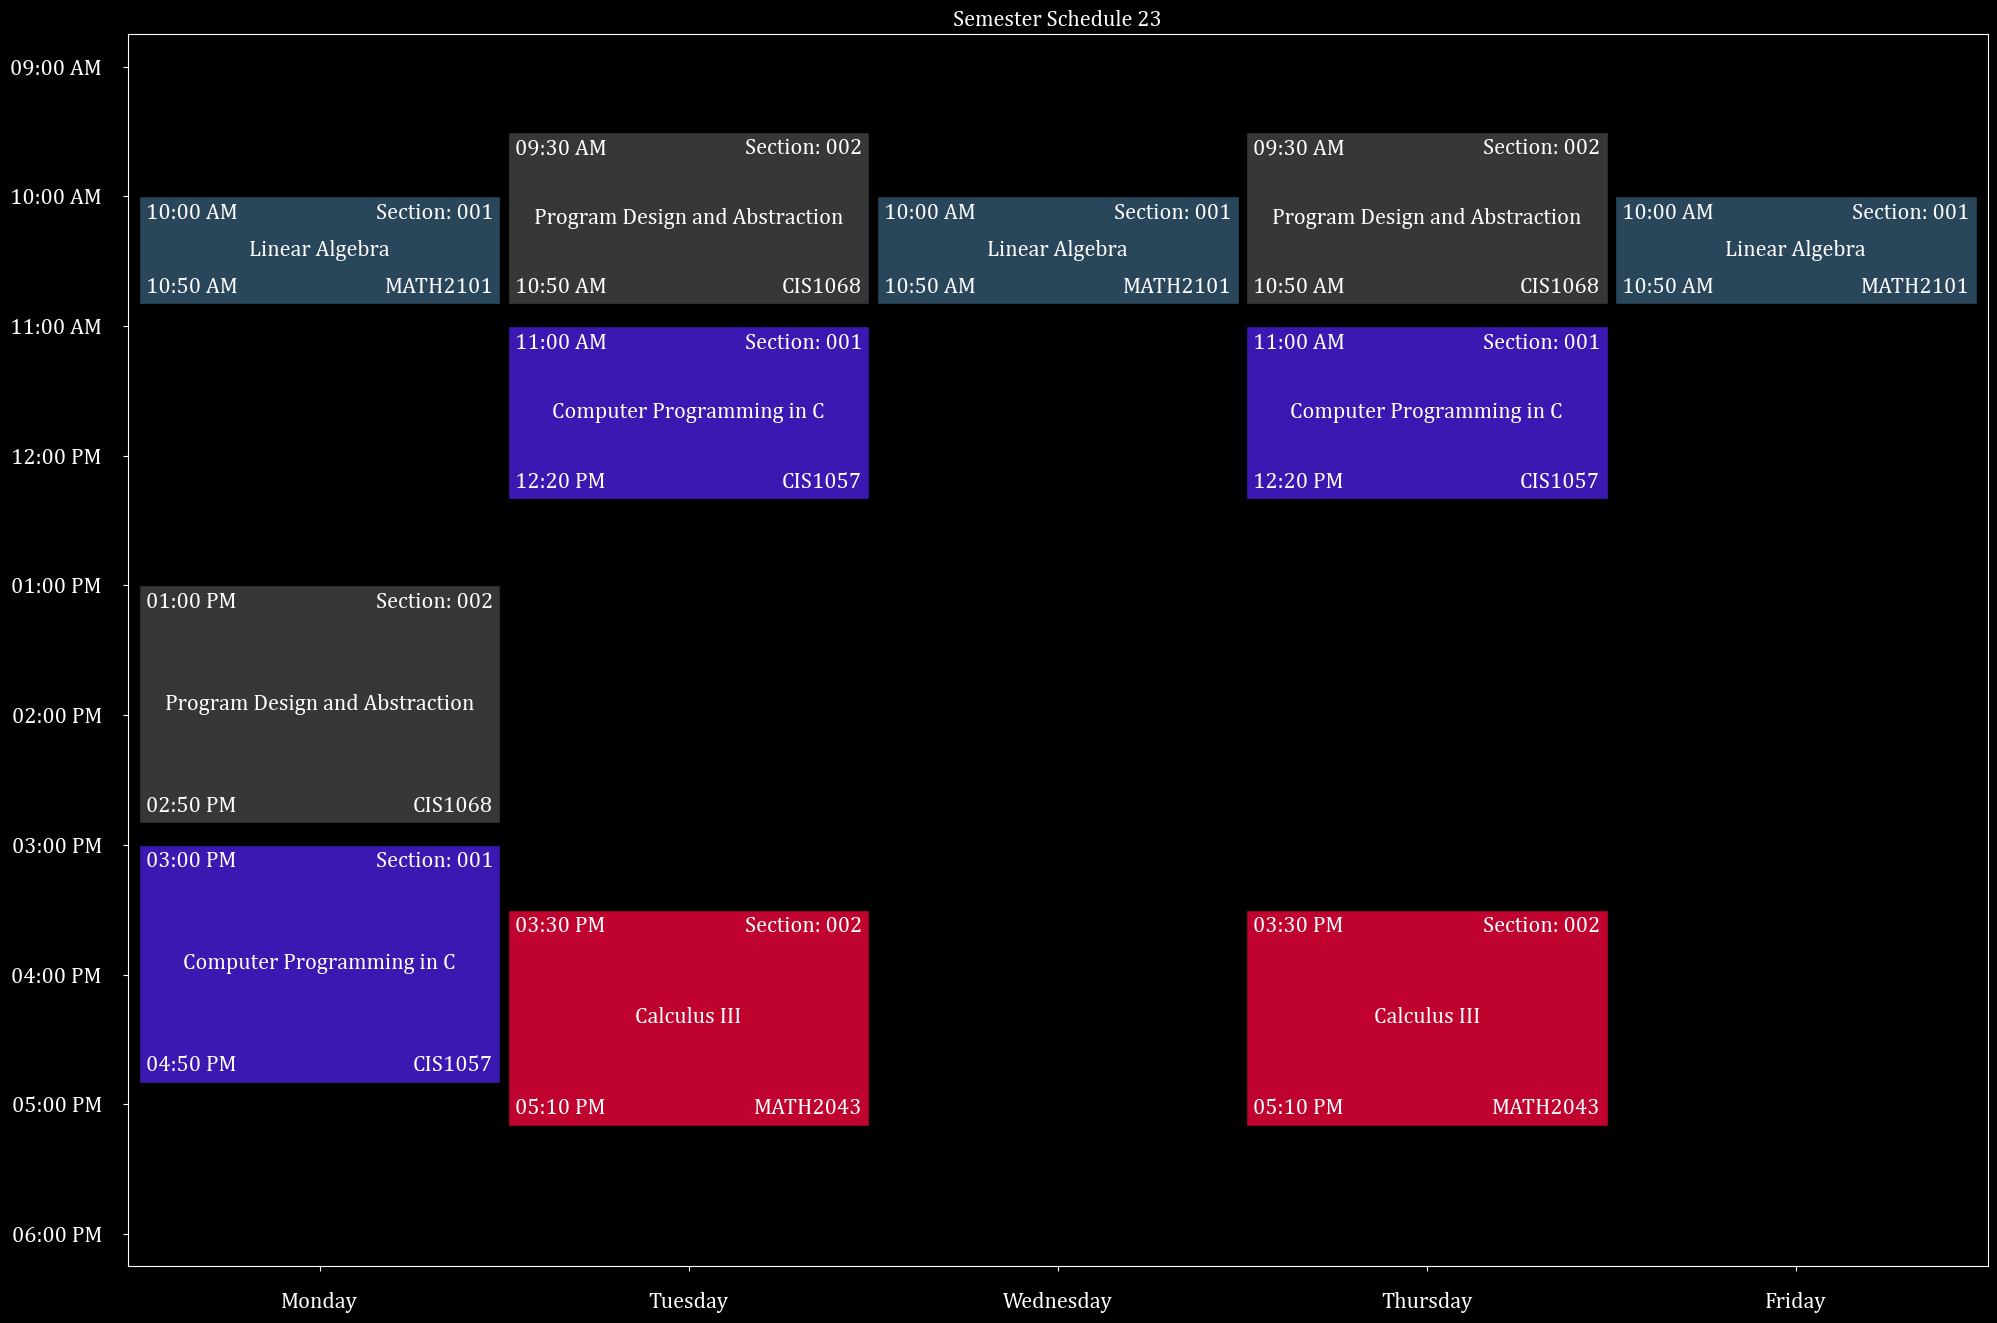

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 003 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 710 | Susan Bertolino | 4.70 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.179 avg


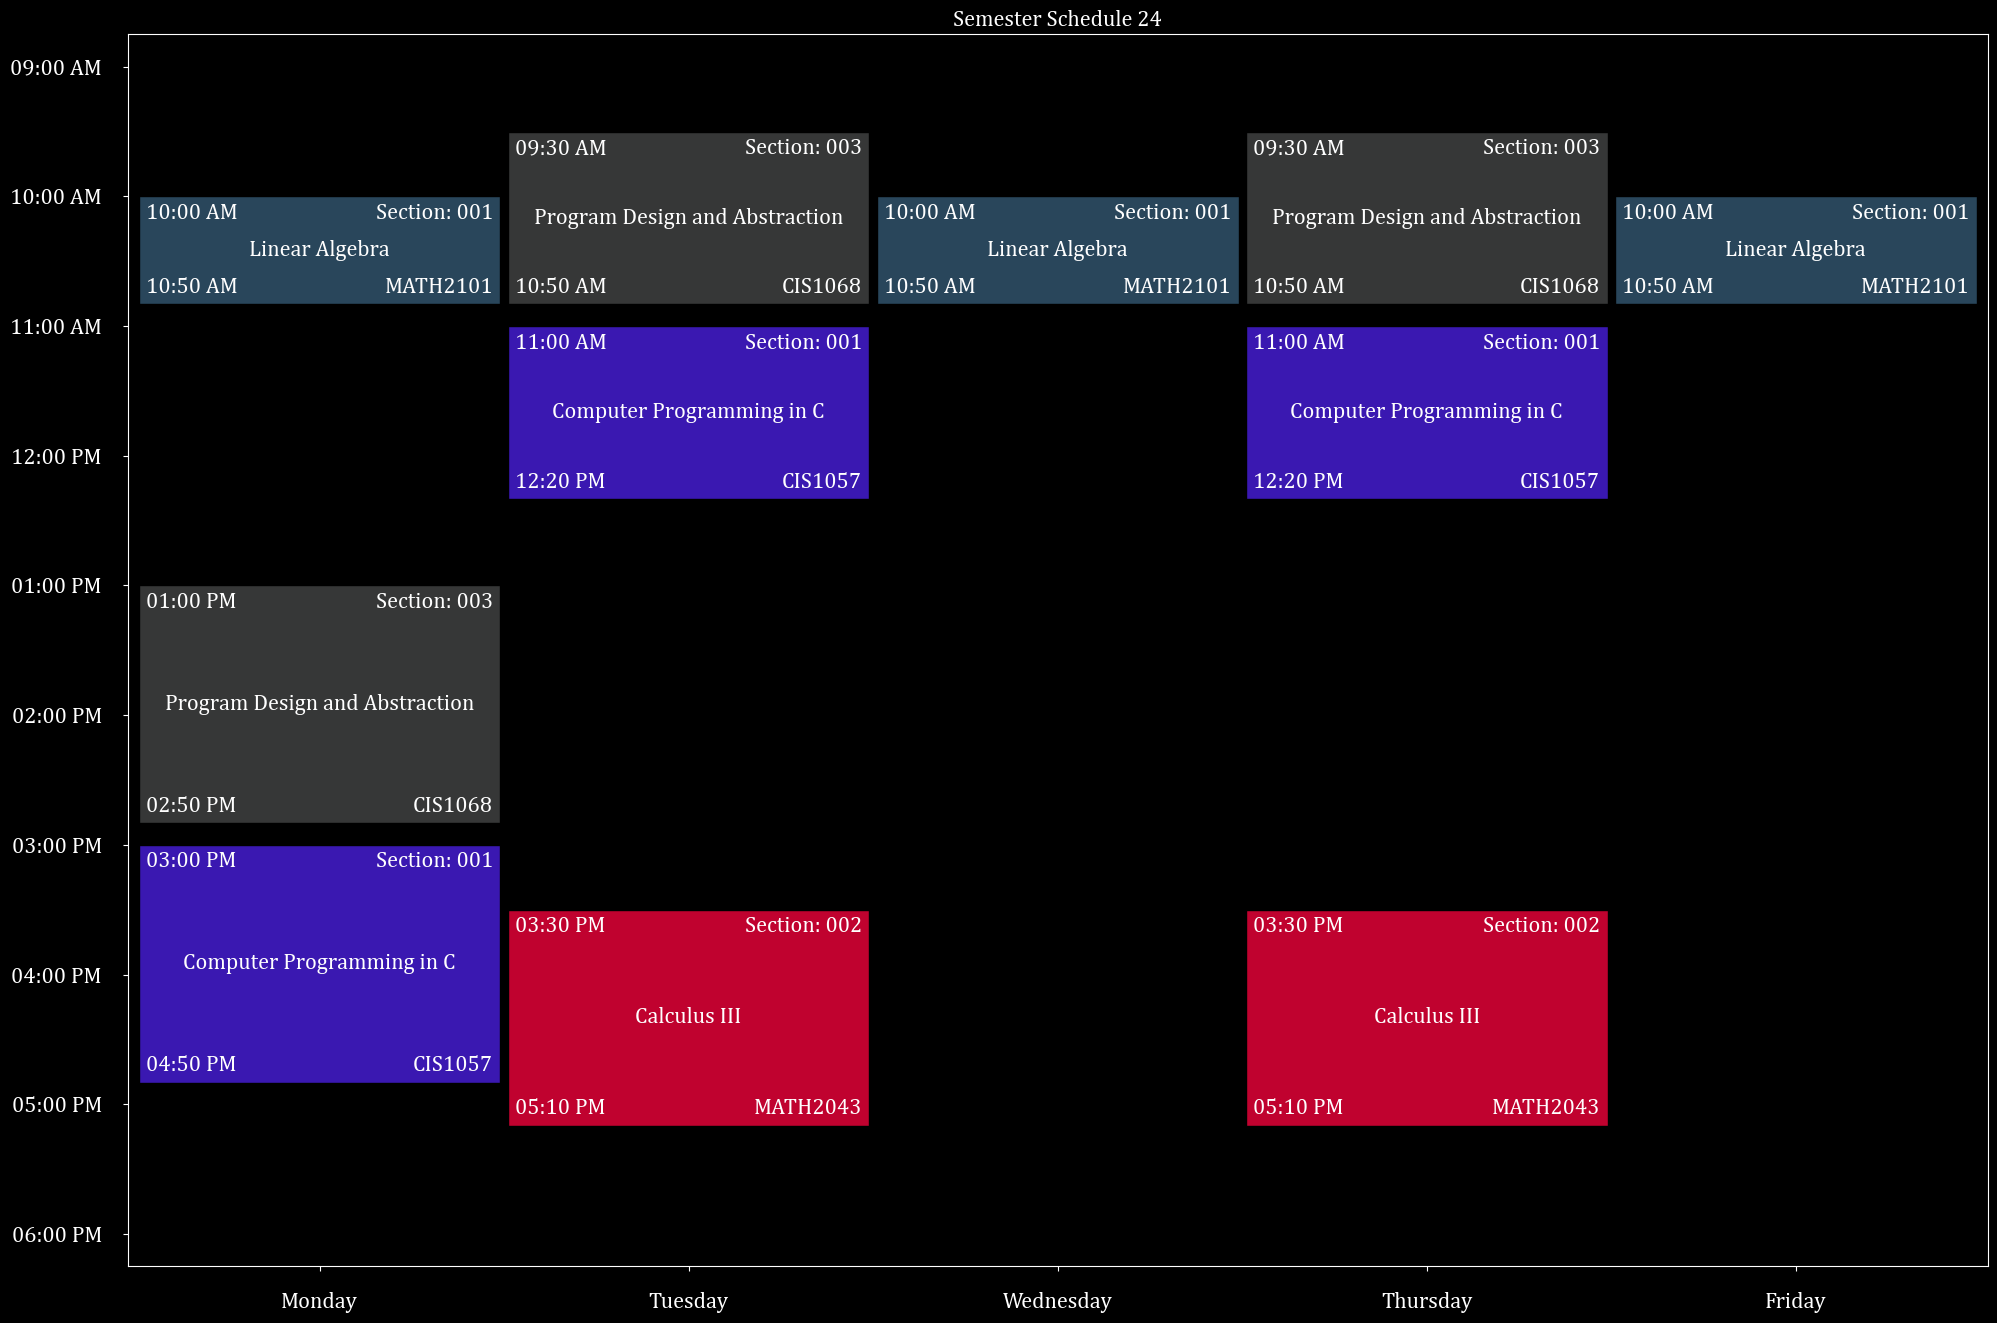

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 004 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 710 | Susan Bertolino | 4.70 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.179 avg


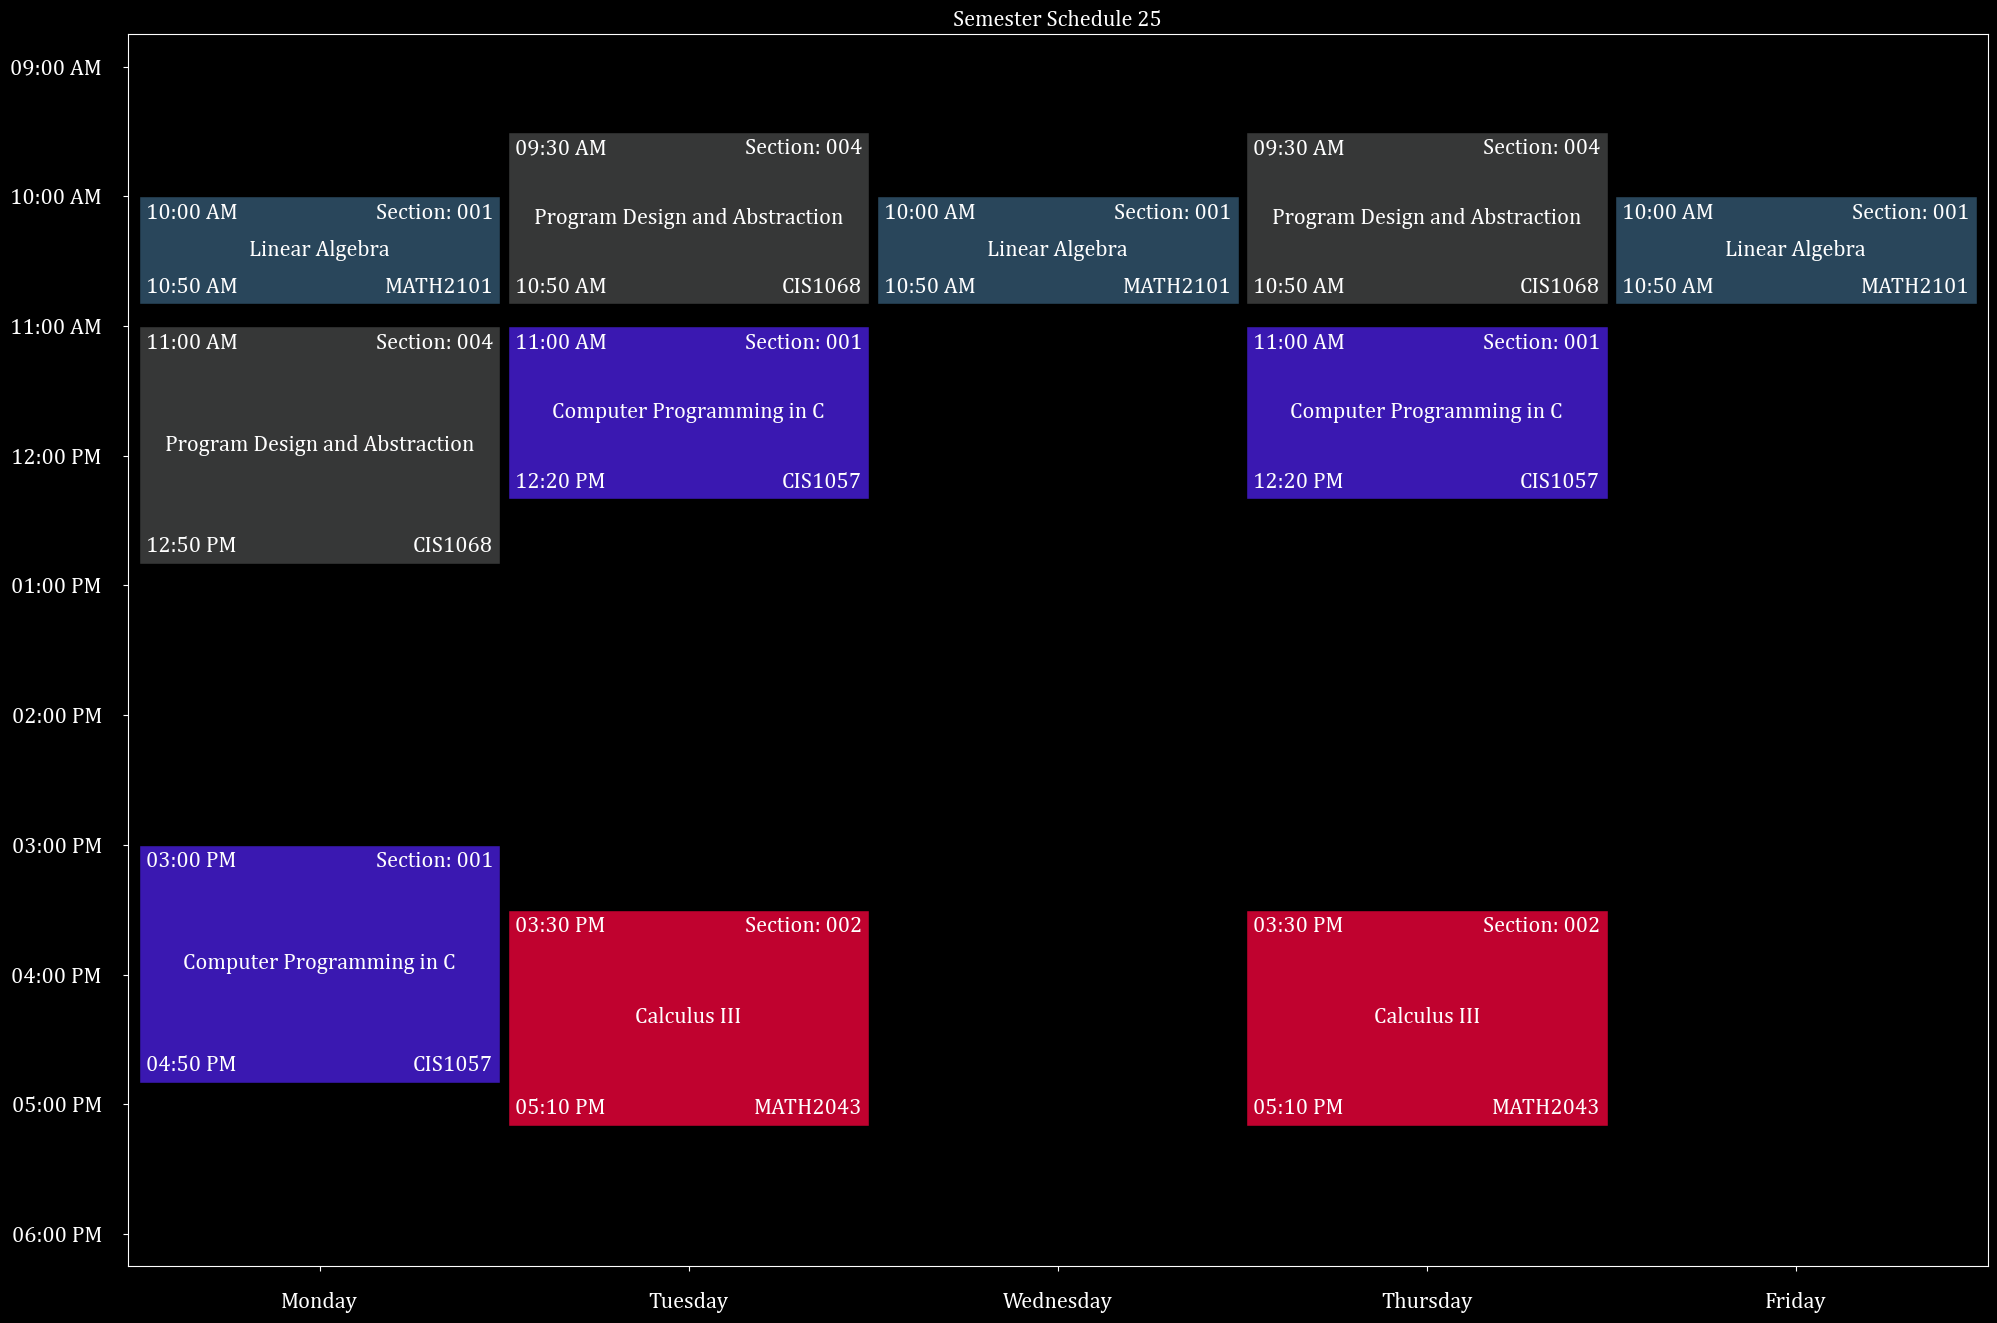

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 005 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 710 | Susan Bertolino | 4.70 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.179 avg


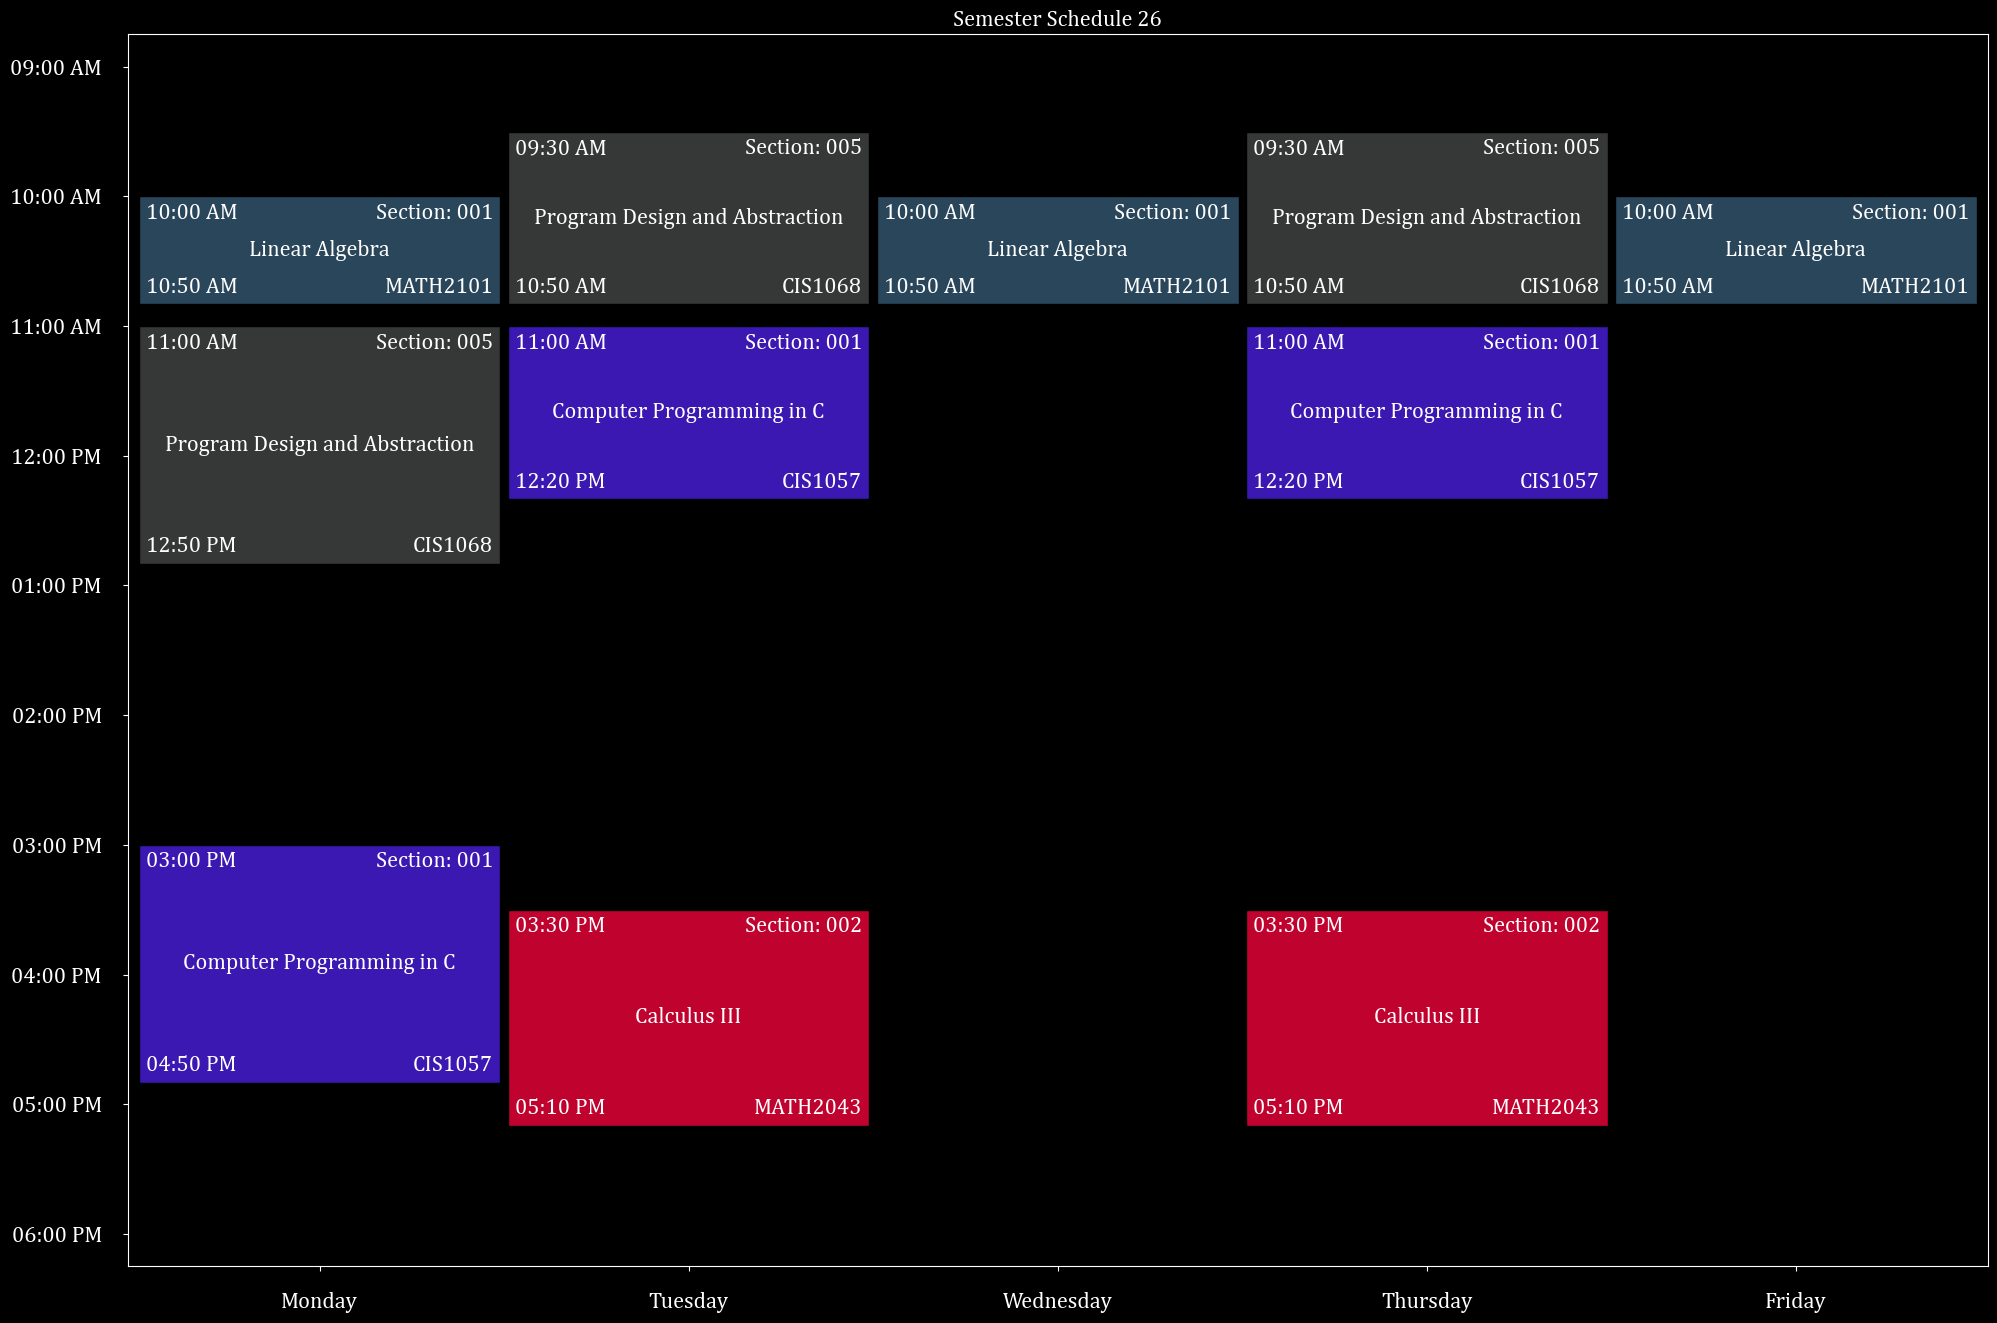

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 006 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 710 | Susan Bertolino | 4.70 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.179 avg


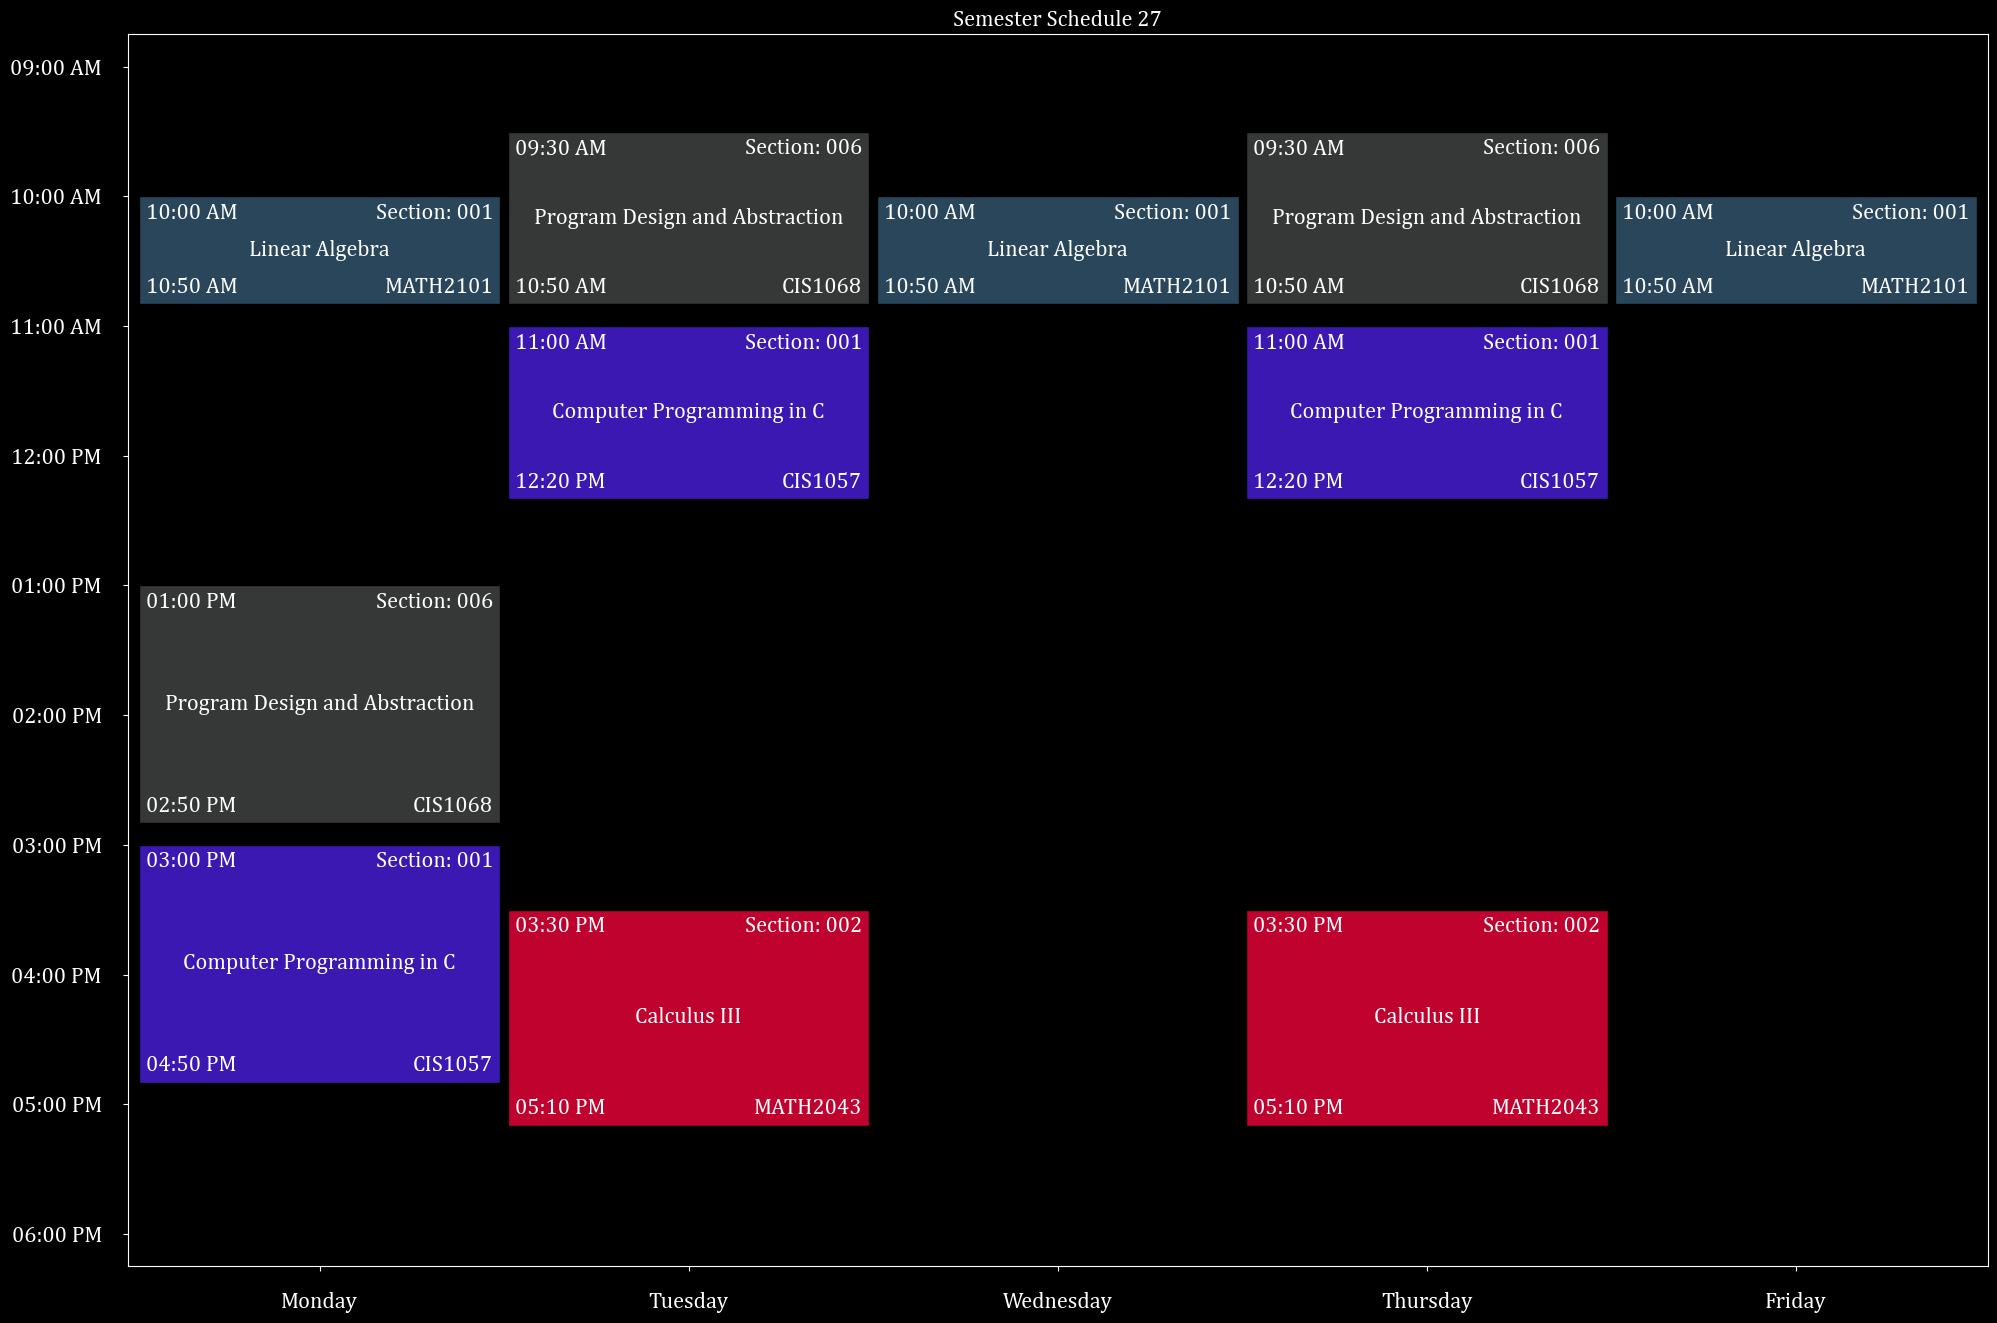

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(11 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 007 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 710 | Susan Bertolino | 4.70 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.179 avg


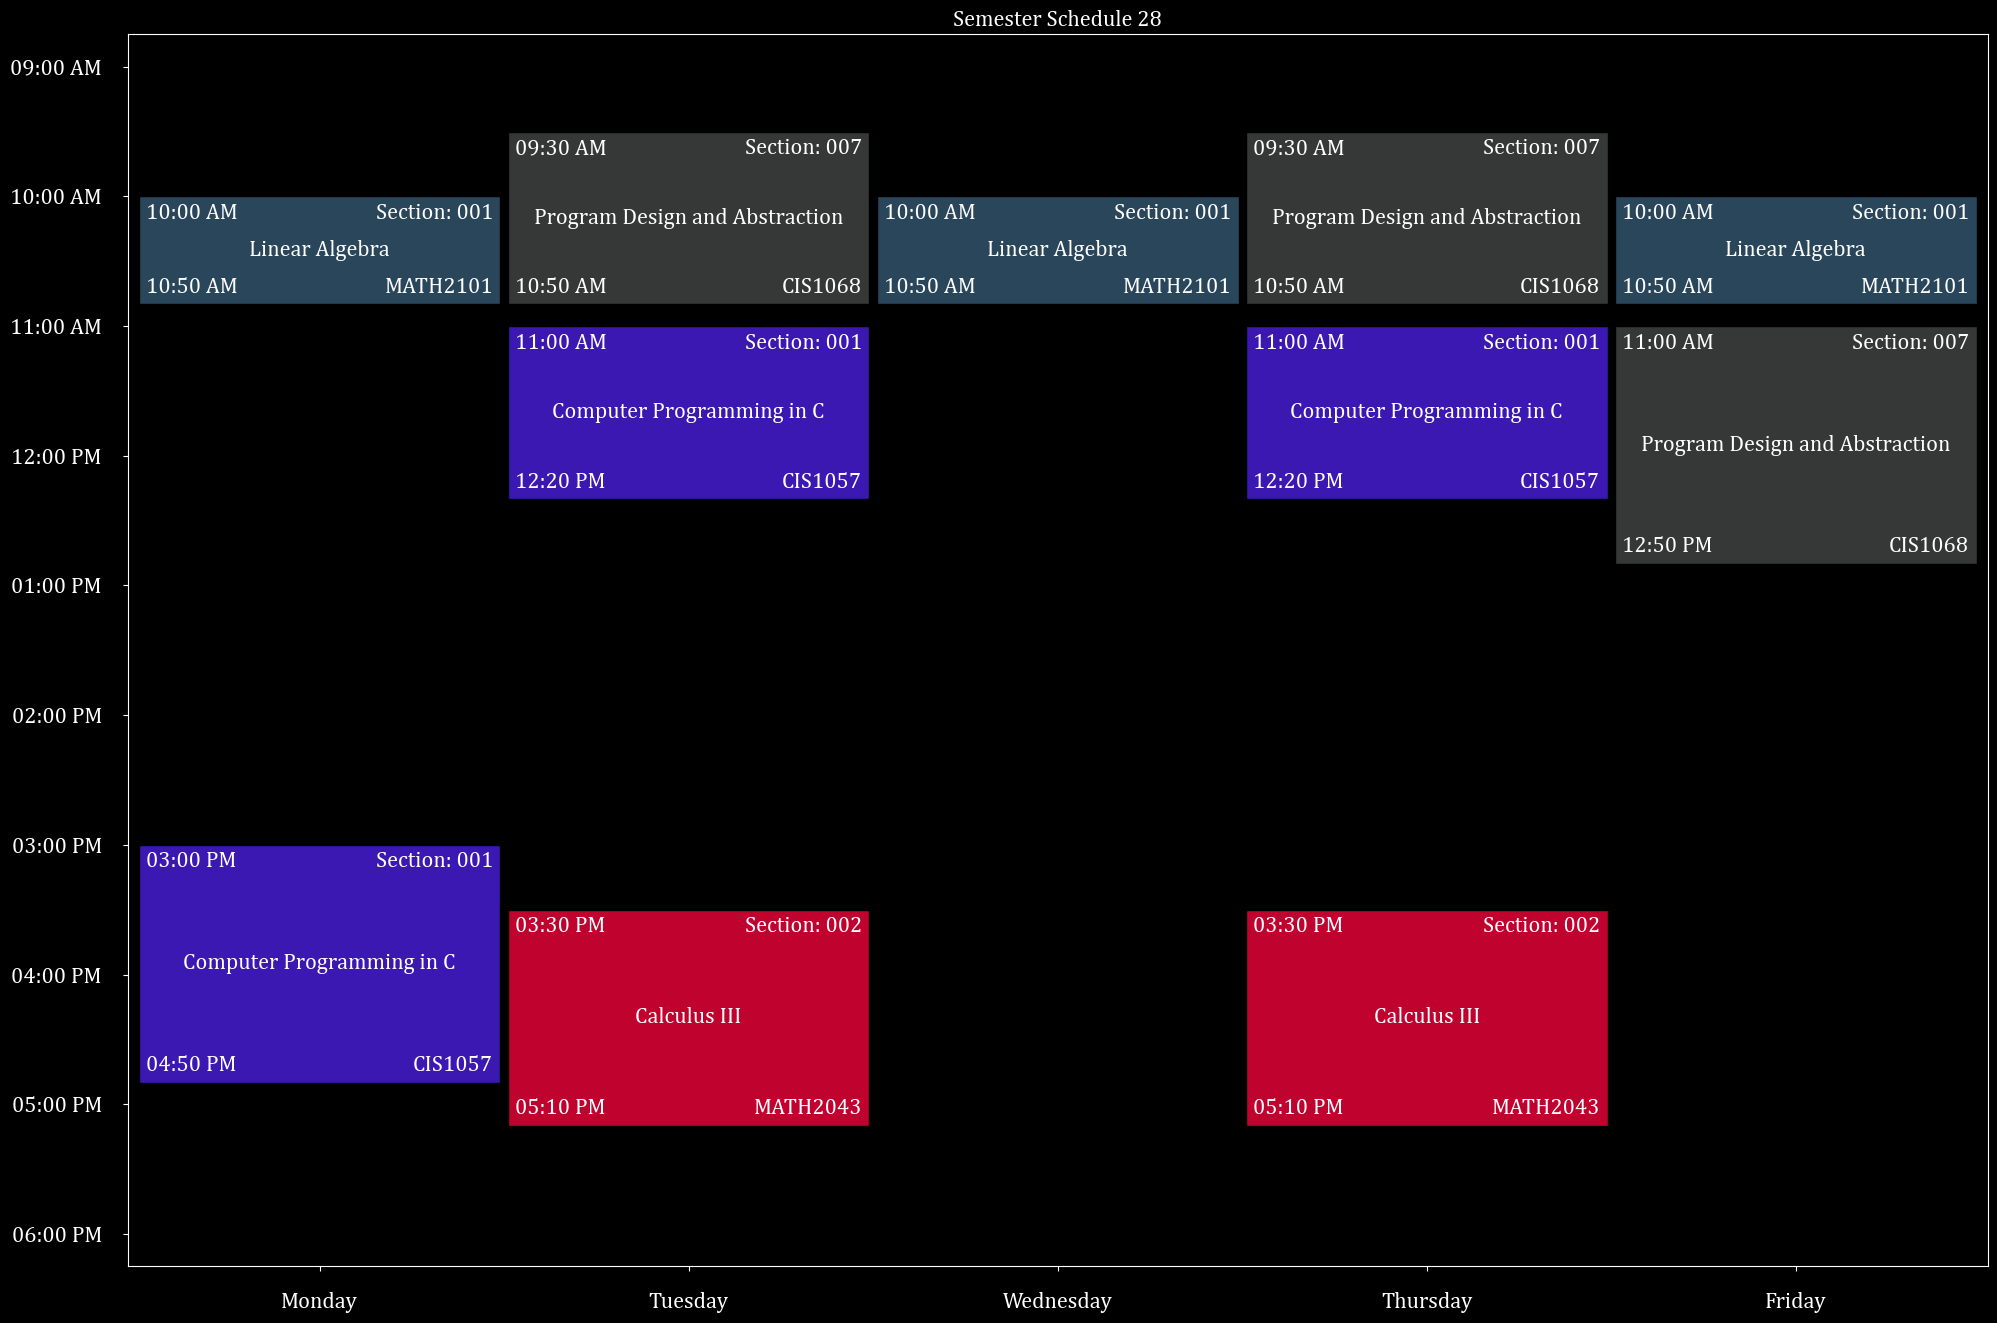

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 013 | Ariane Fischer | 4.20 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.120 avg


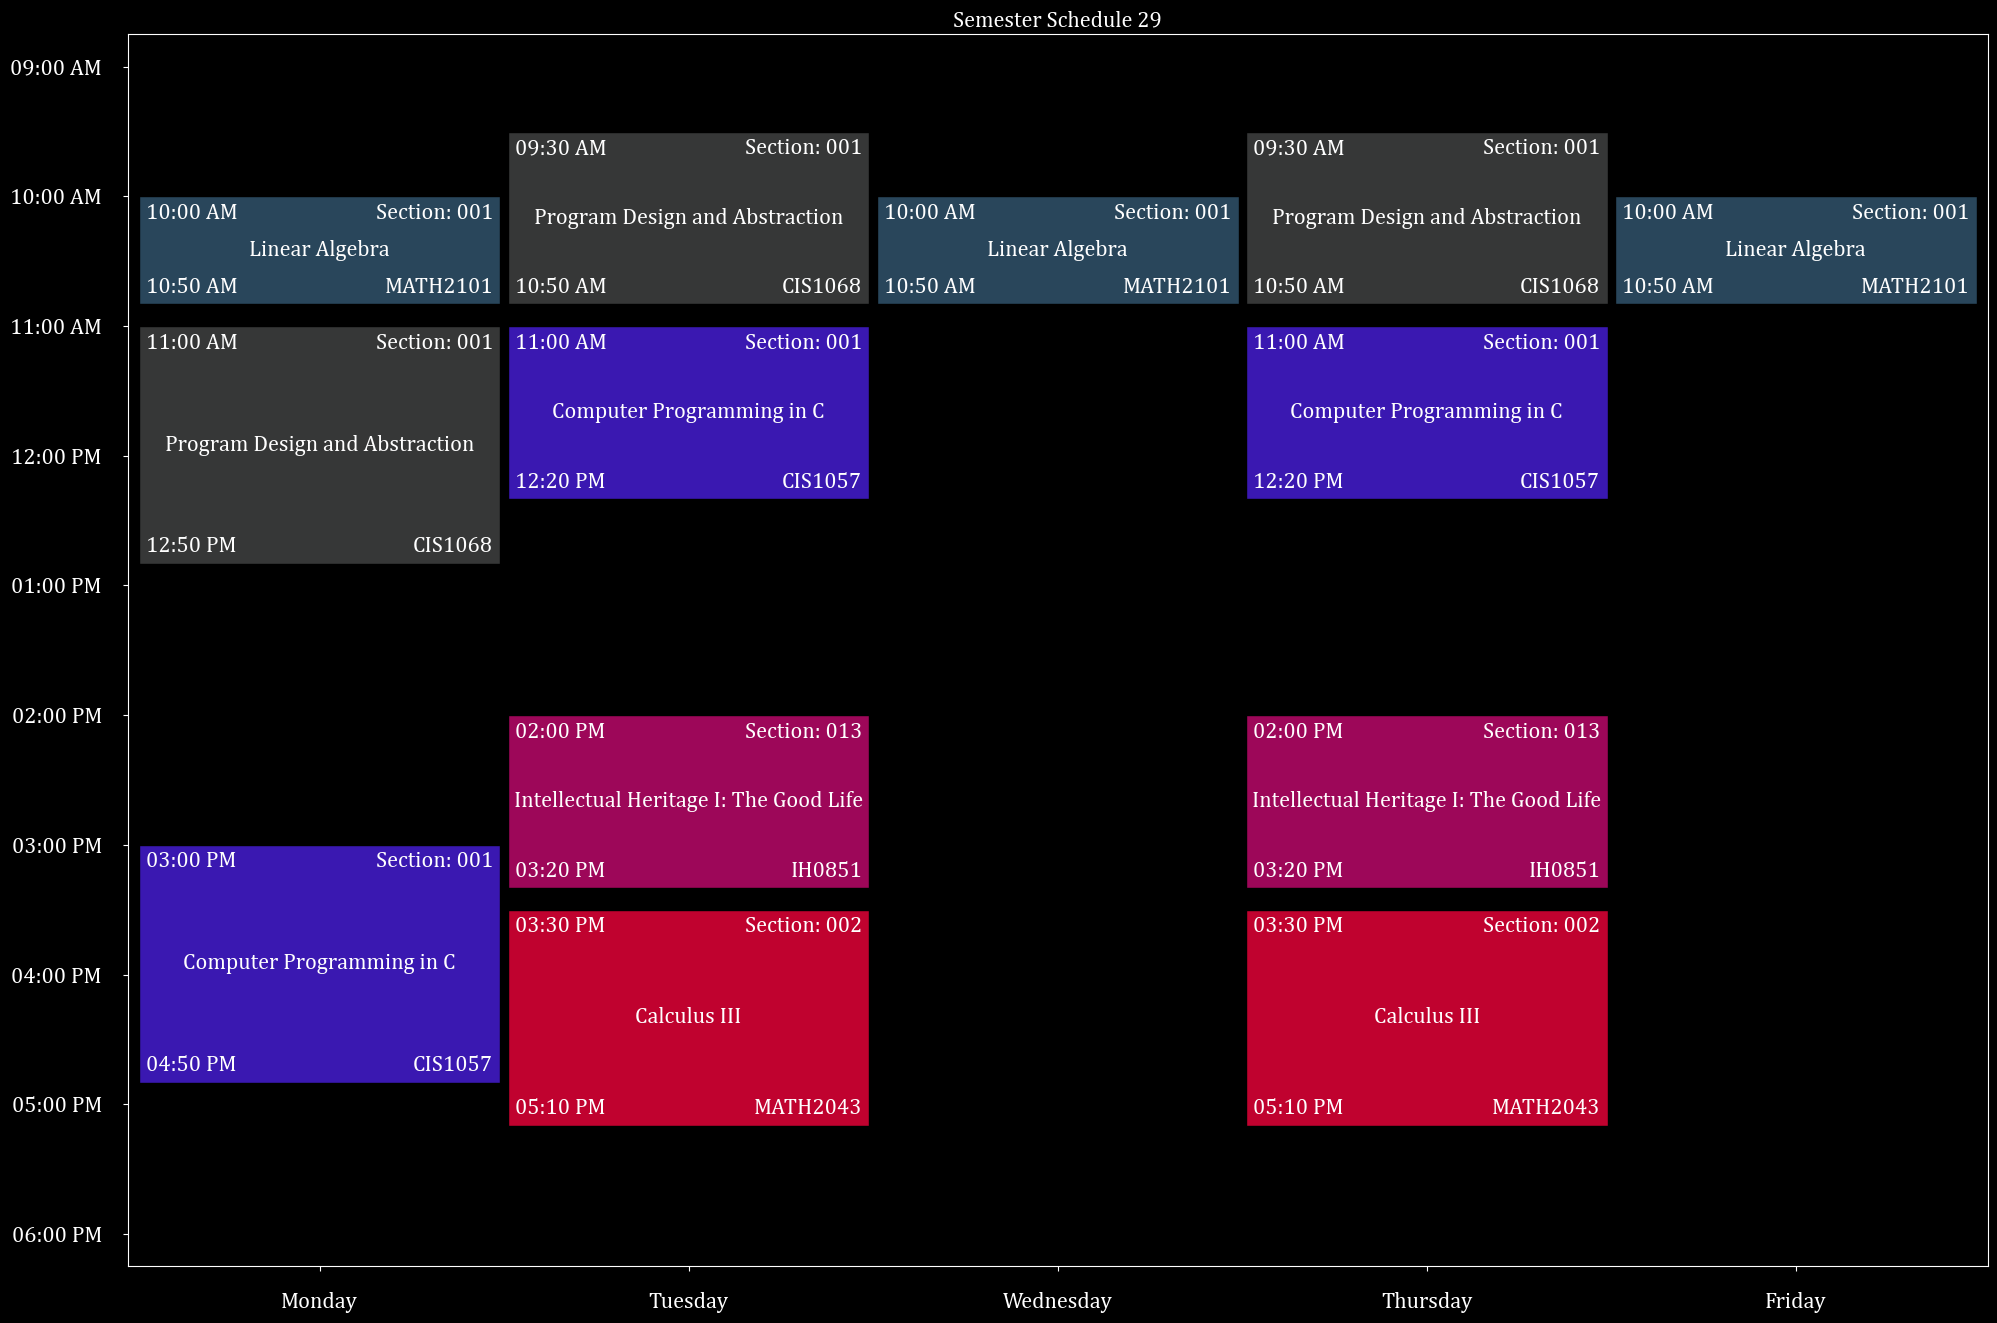

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 002 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 013 | Ariane Fischer | 4.20 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.120 avg


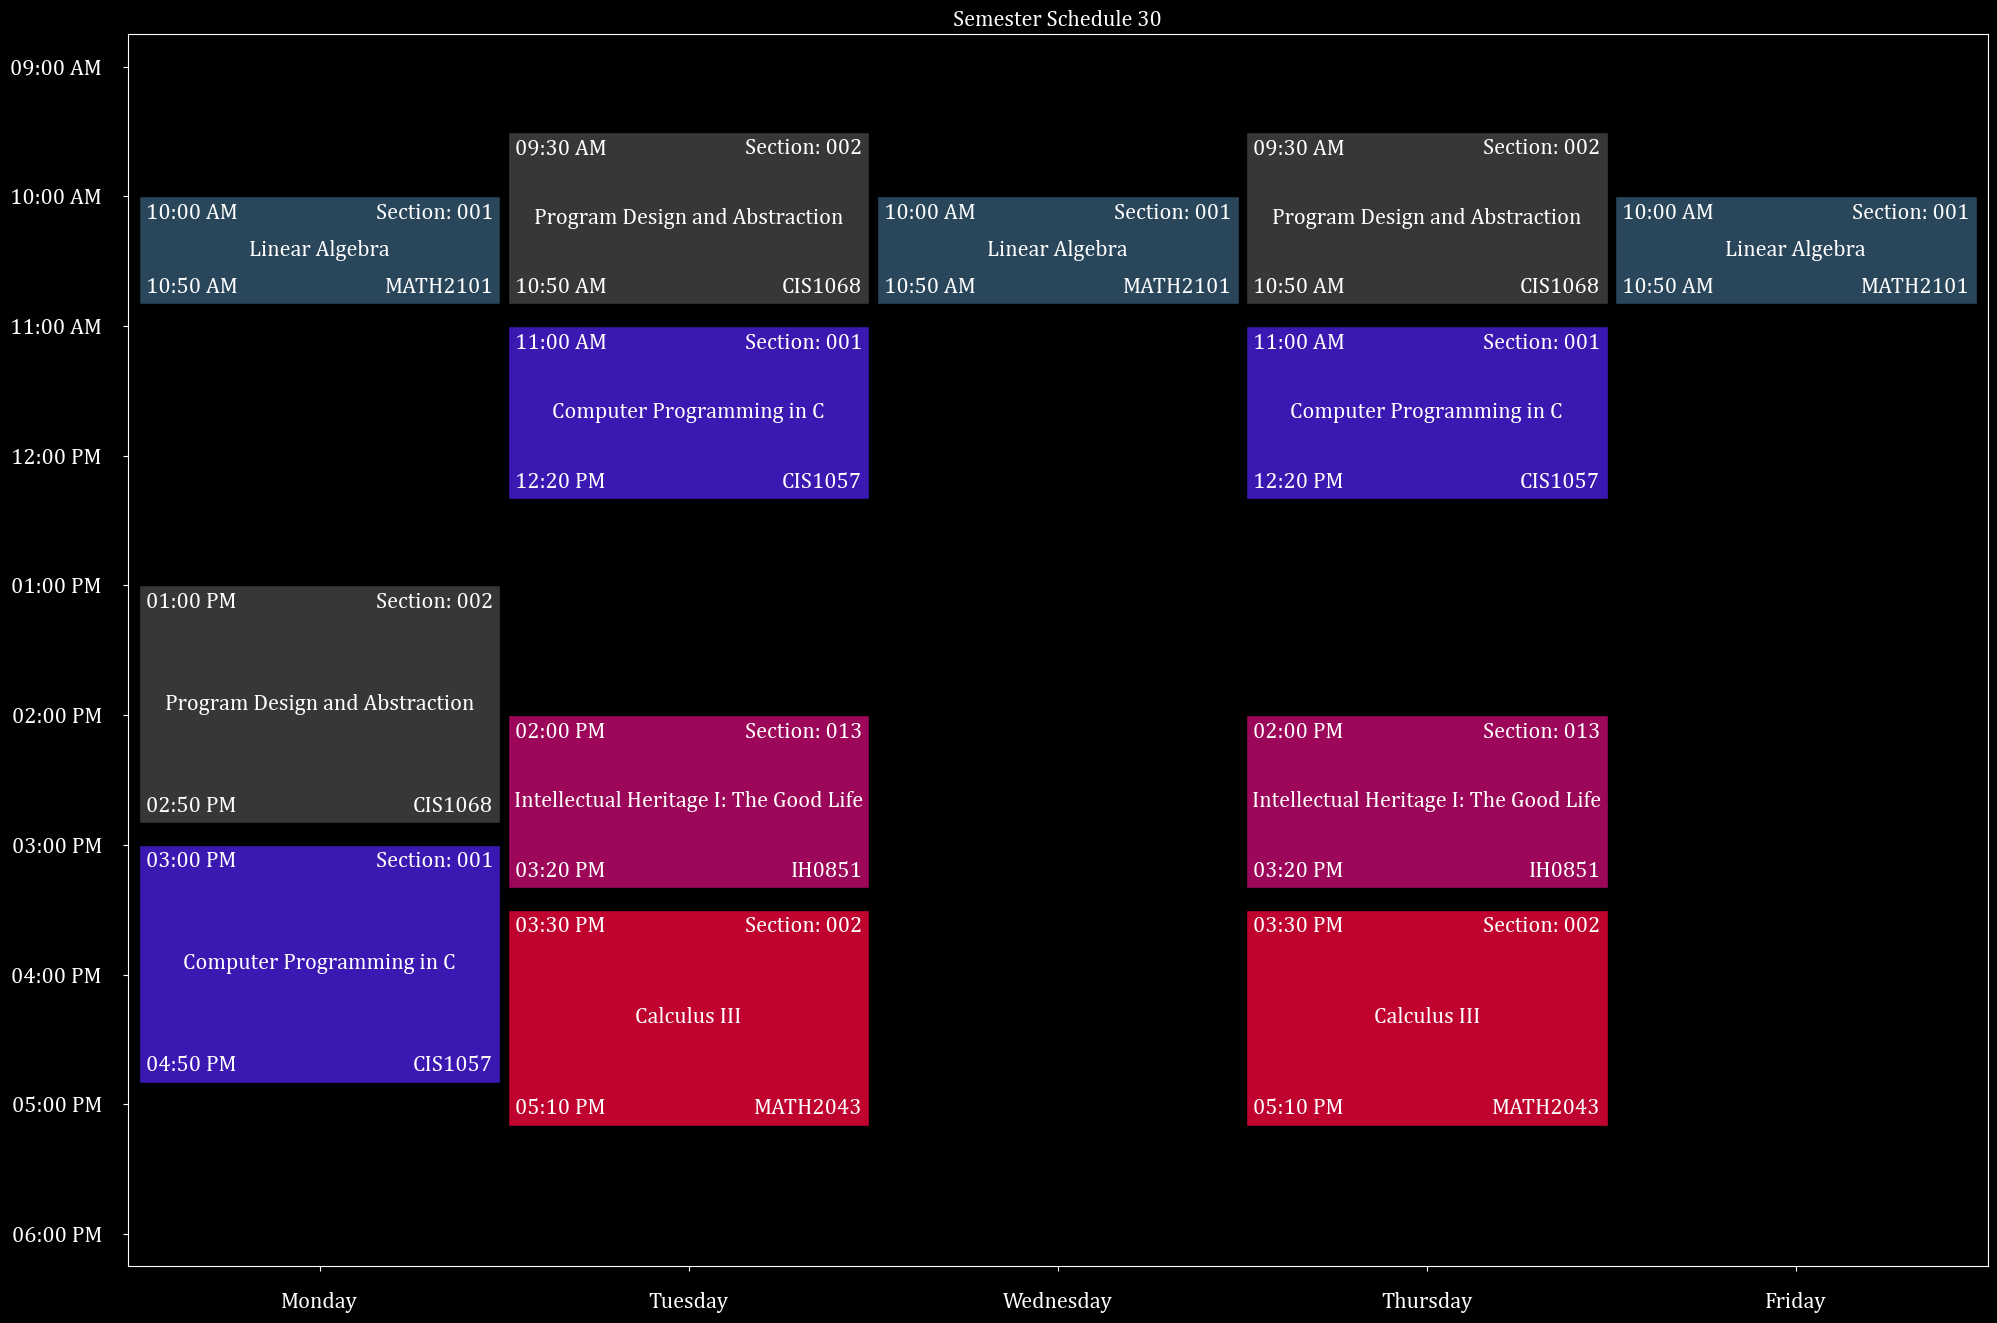

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 003 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 013 | Ariane Fischer | 4.20 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.120 avg


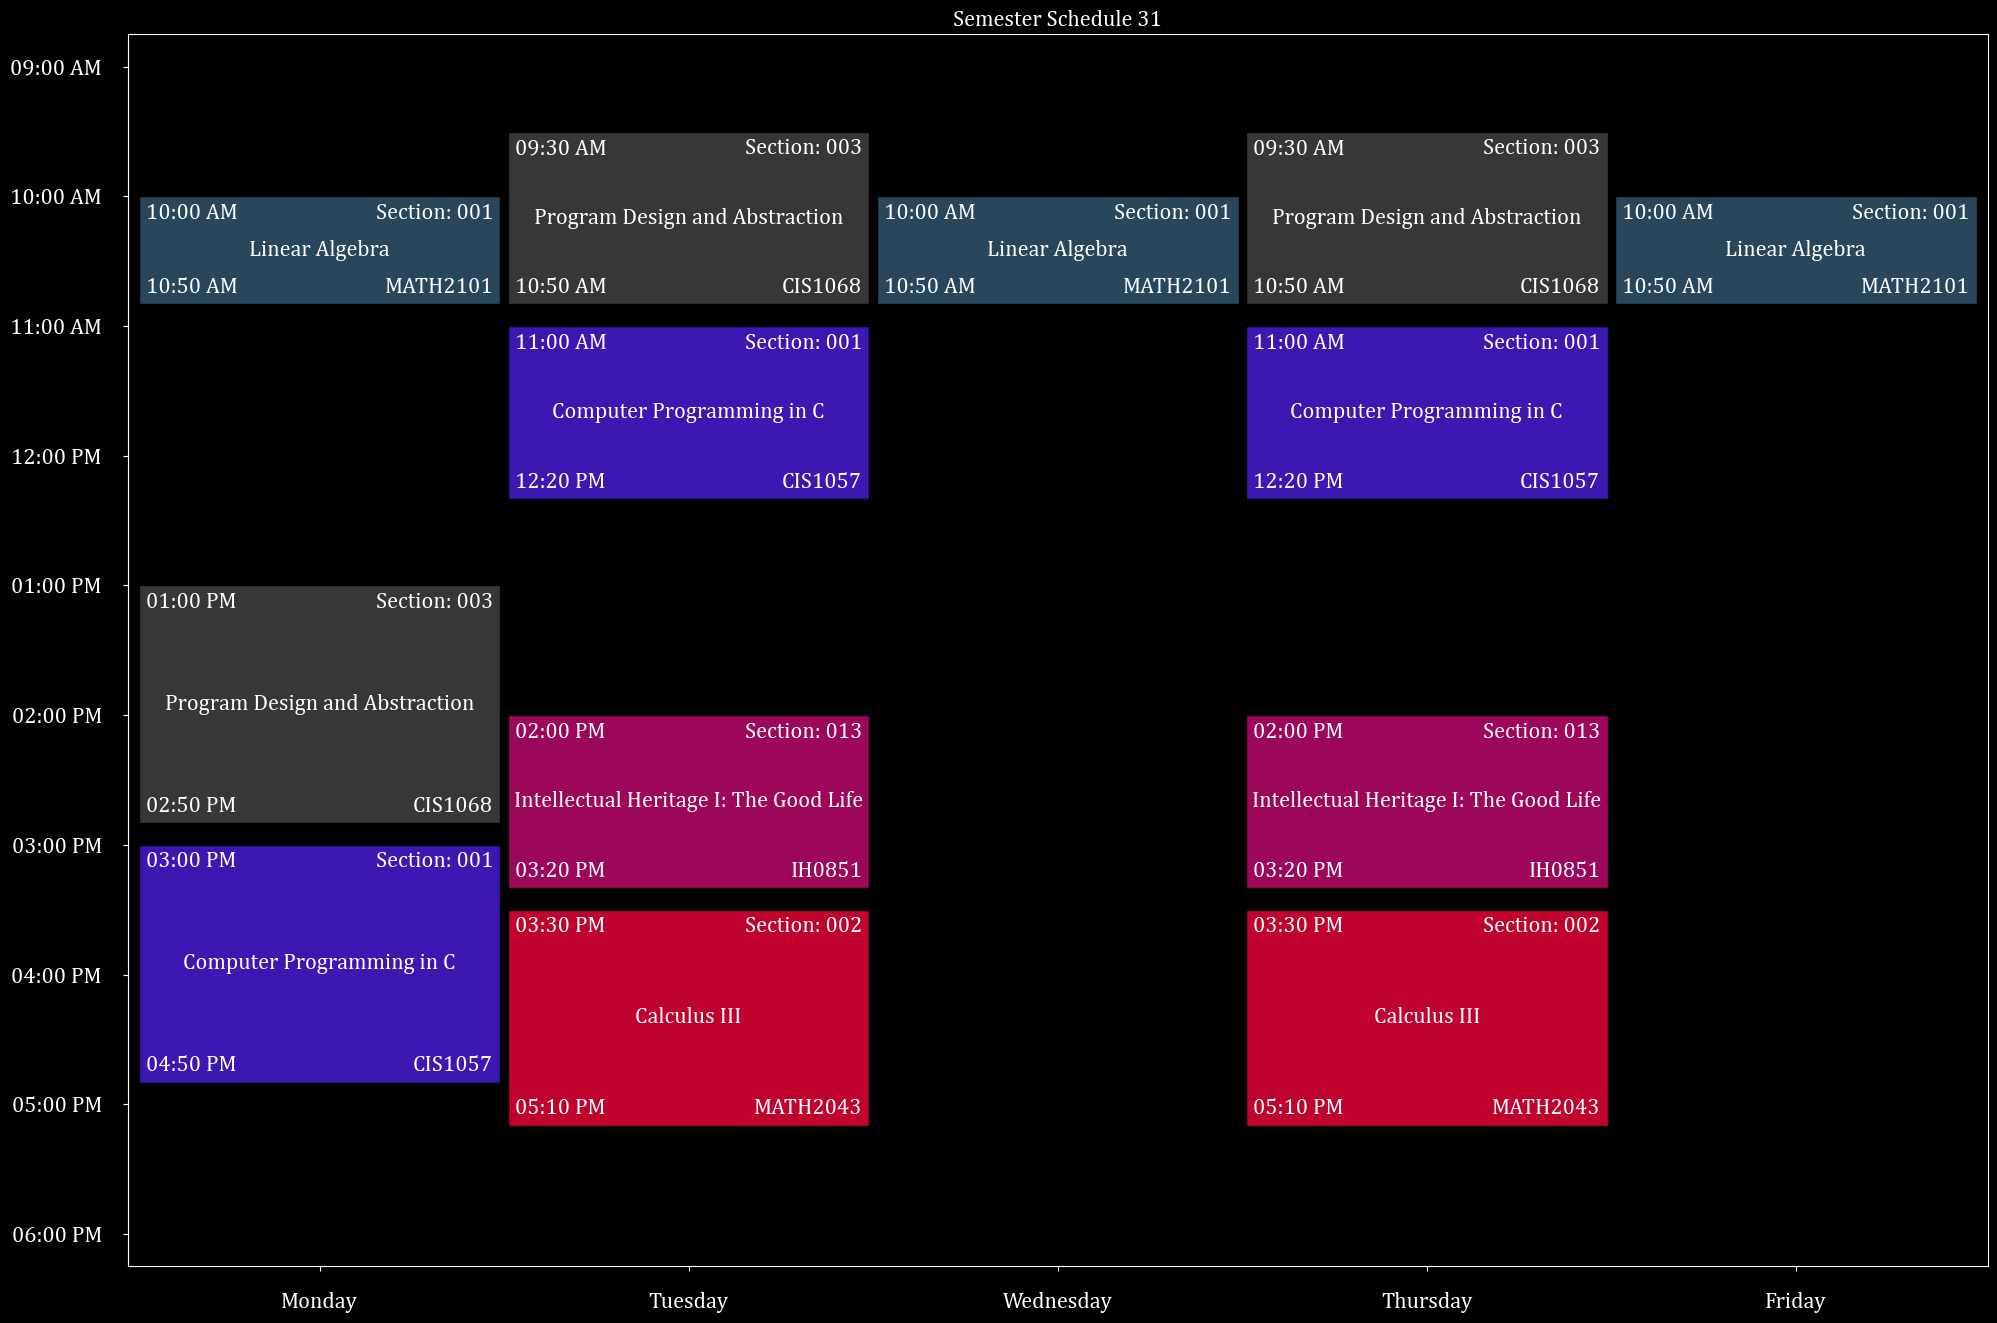

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 004 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 013 | Ariane Fischer | 4.20 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.120 avg


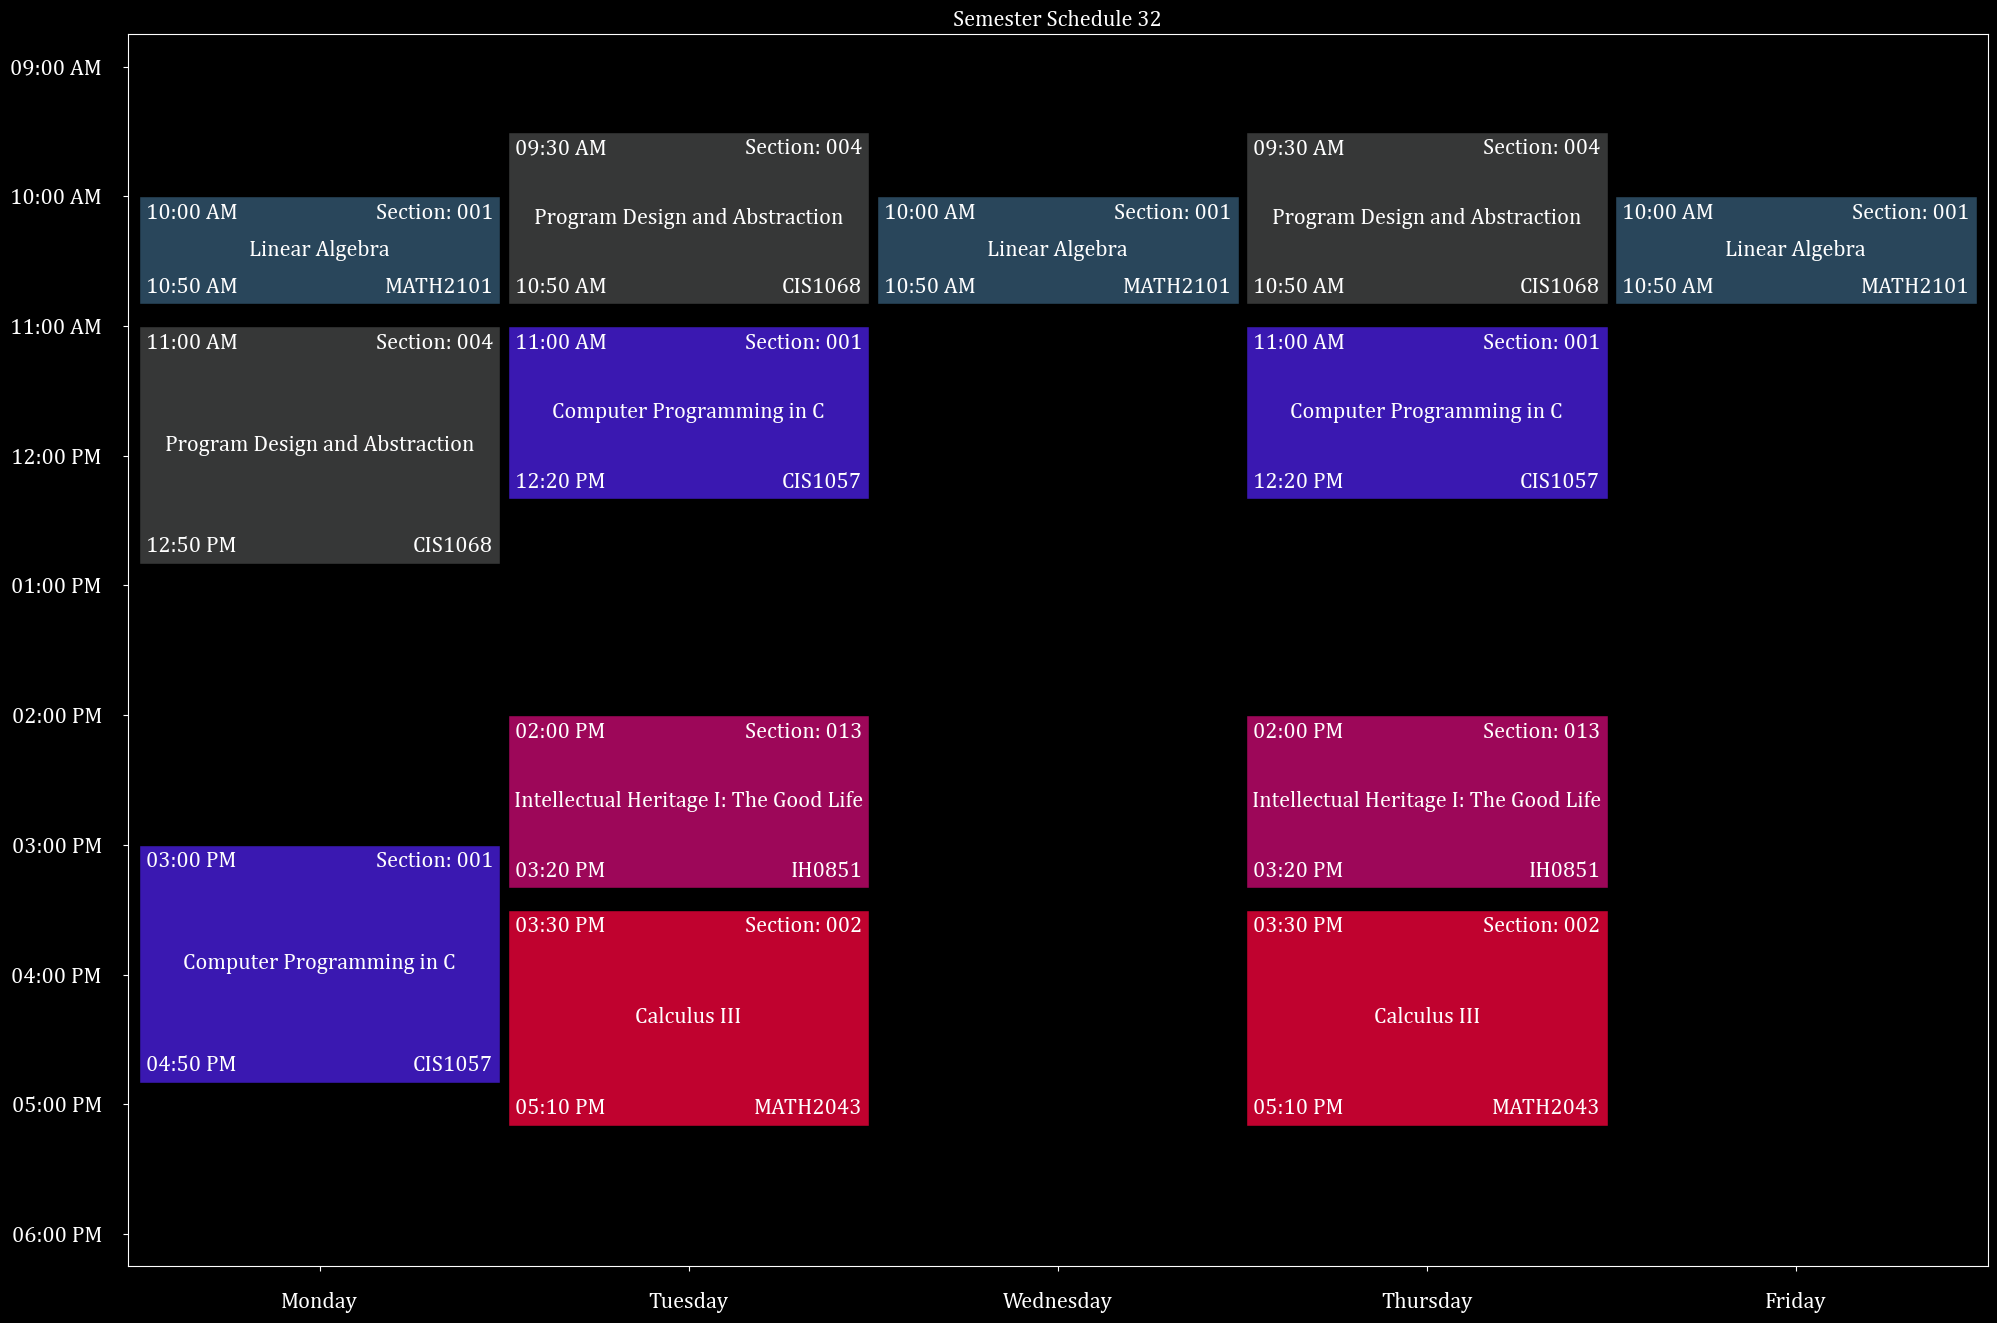

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 005 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 013 | Ariane Fischer | 4.20 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.120 avg


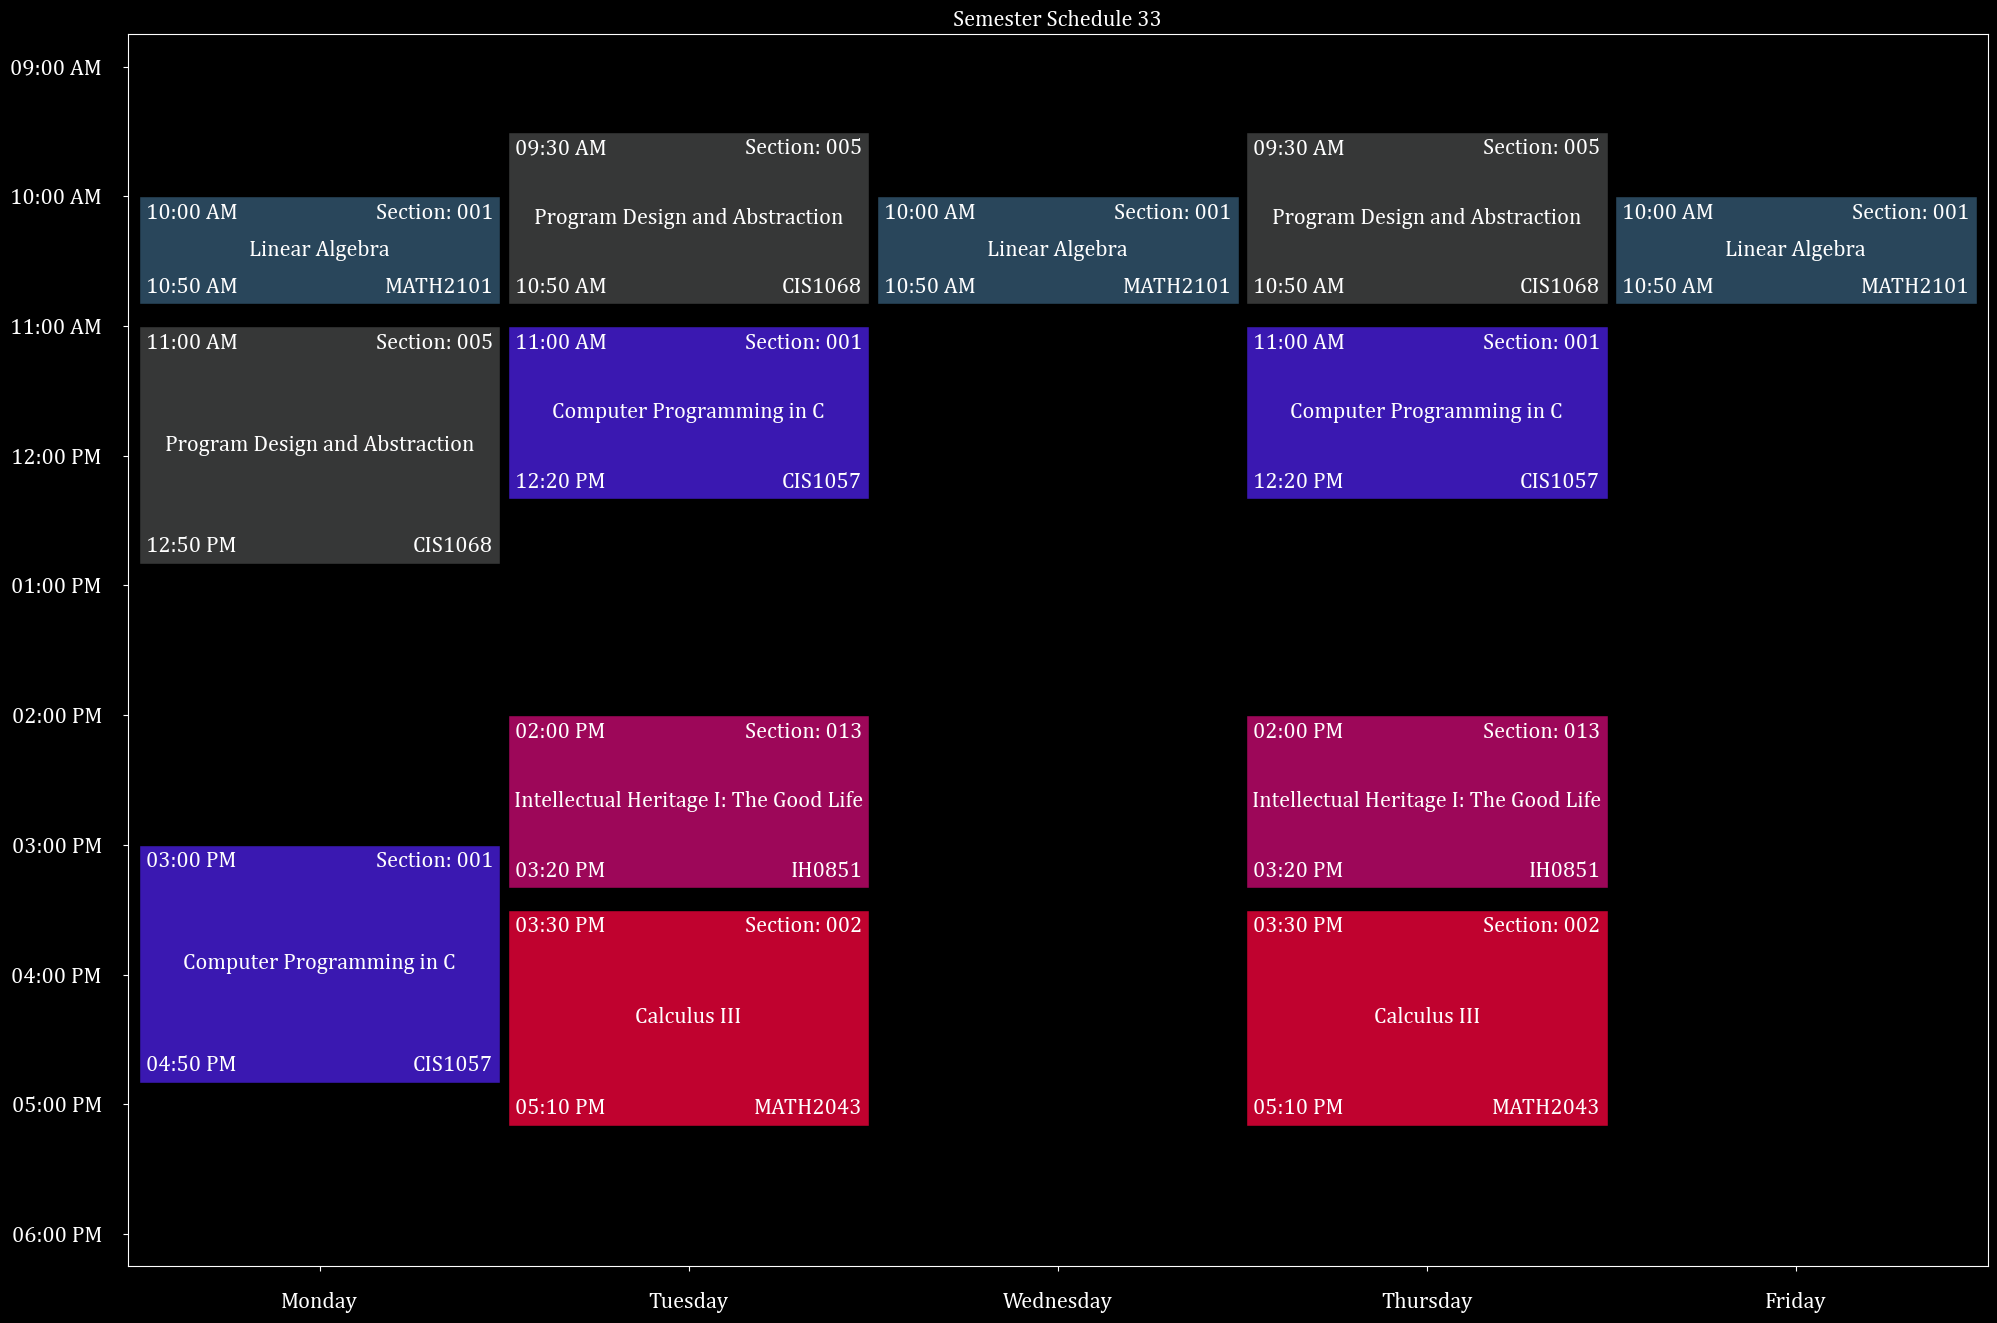

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(6 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 006 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 013 | Ariane Fischer | 4.20 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.120 avg


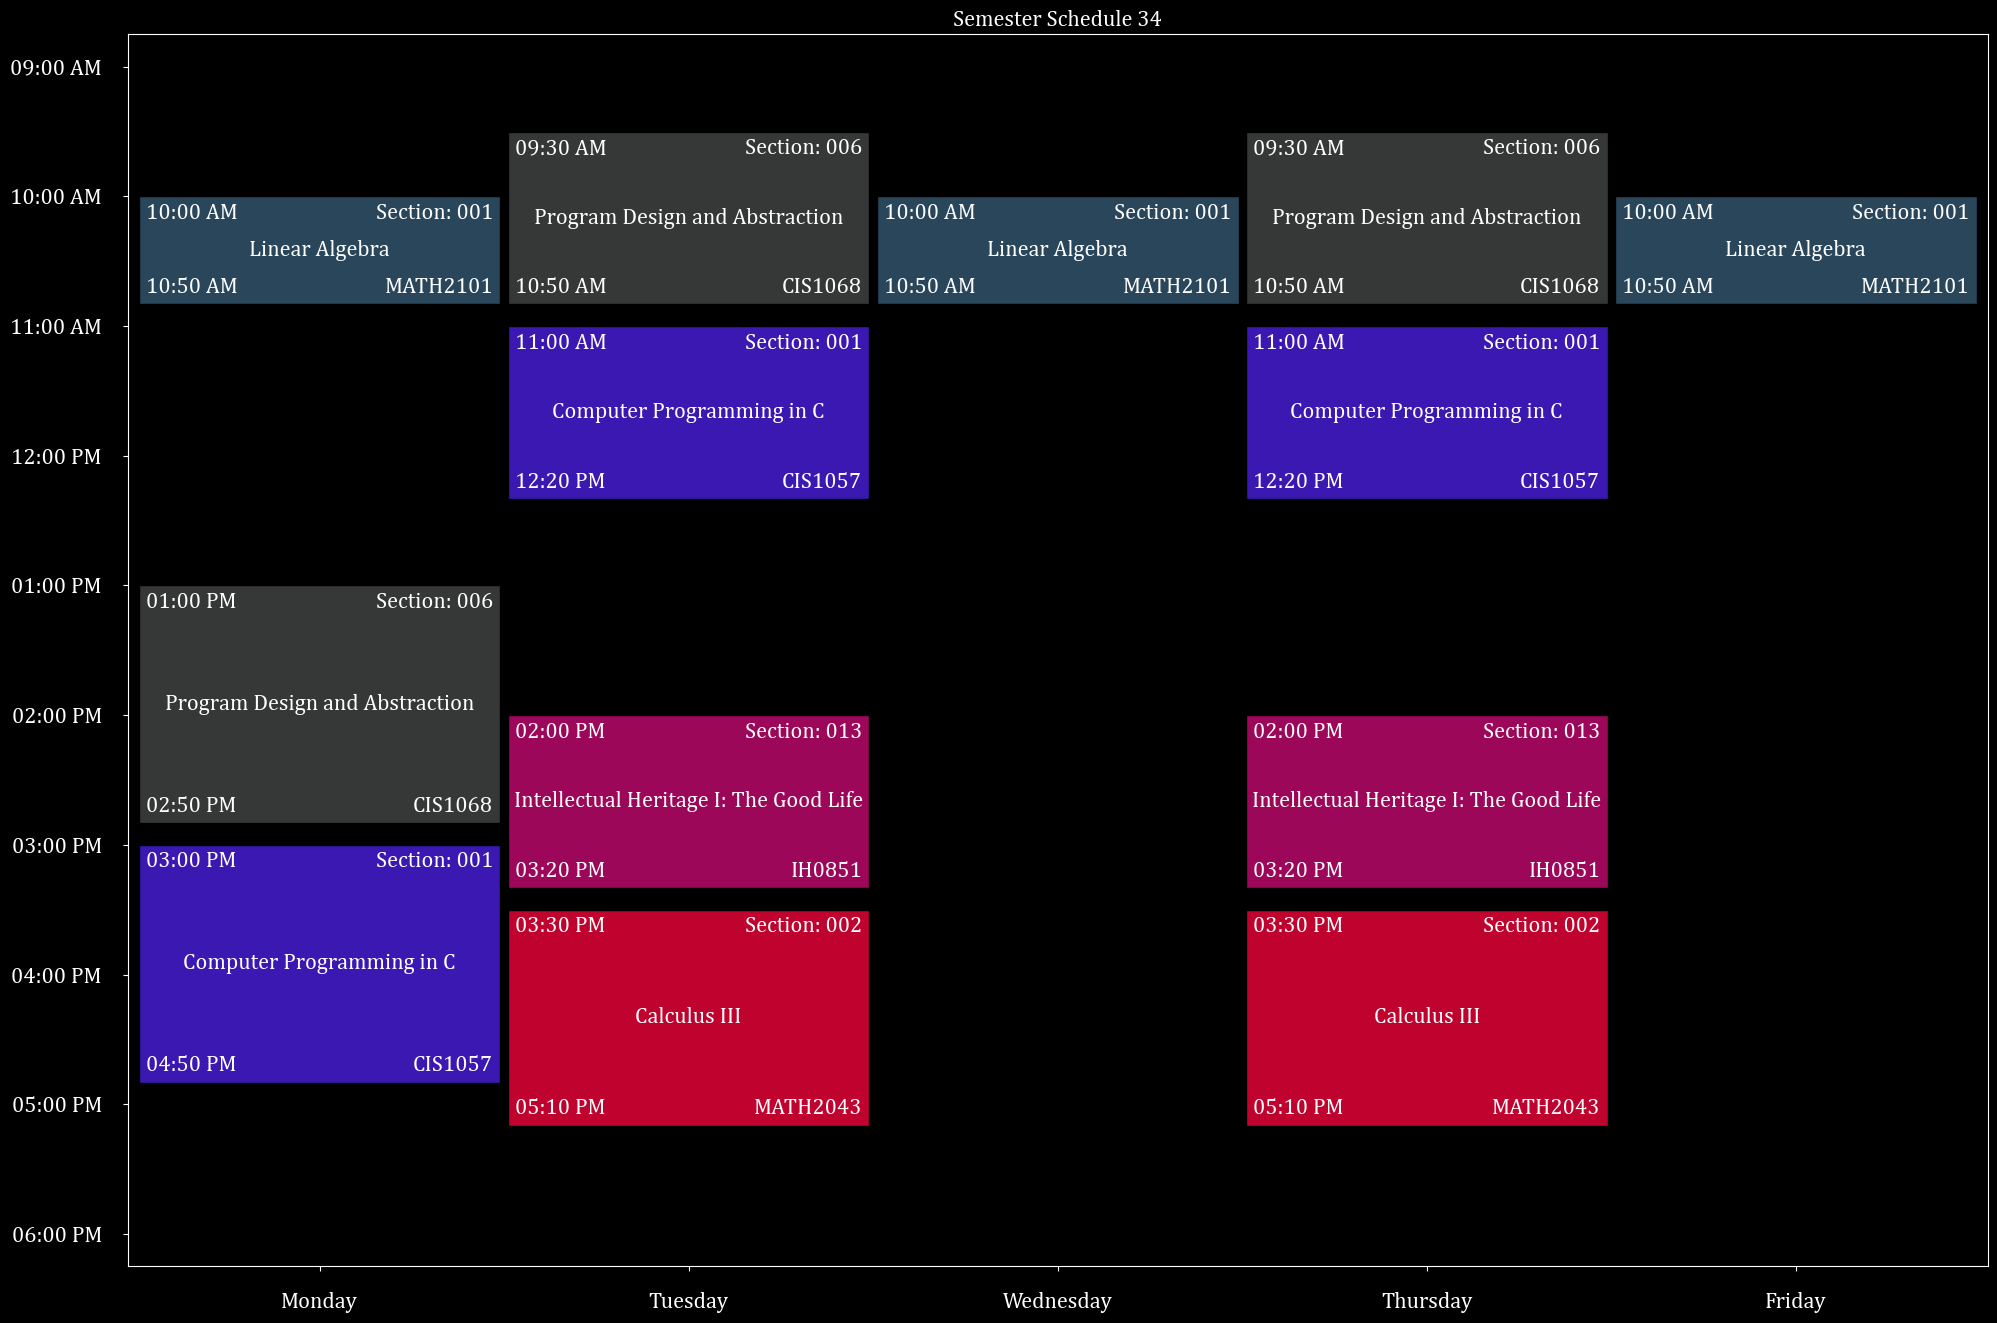

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(17 hrs 30 mins), BREAK_TOTAL(8 hrs 20 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 007 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 013 | Ariane Fischer | 4.20 | In-person | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.120 avg


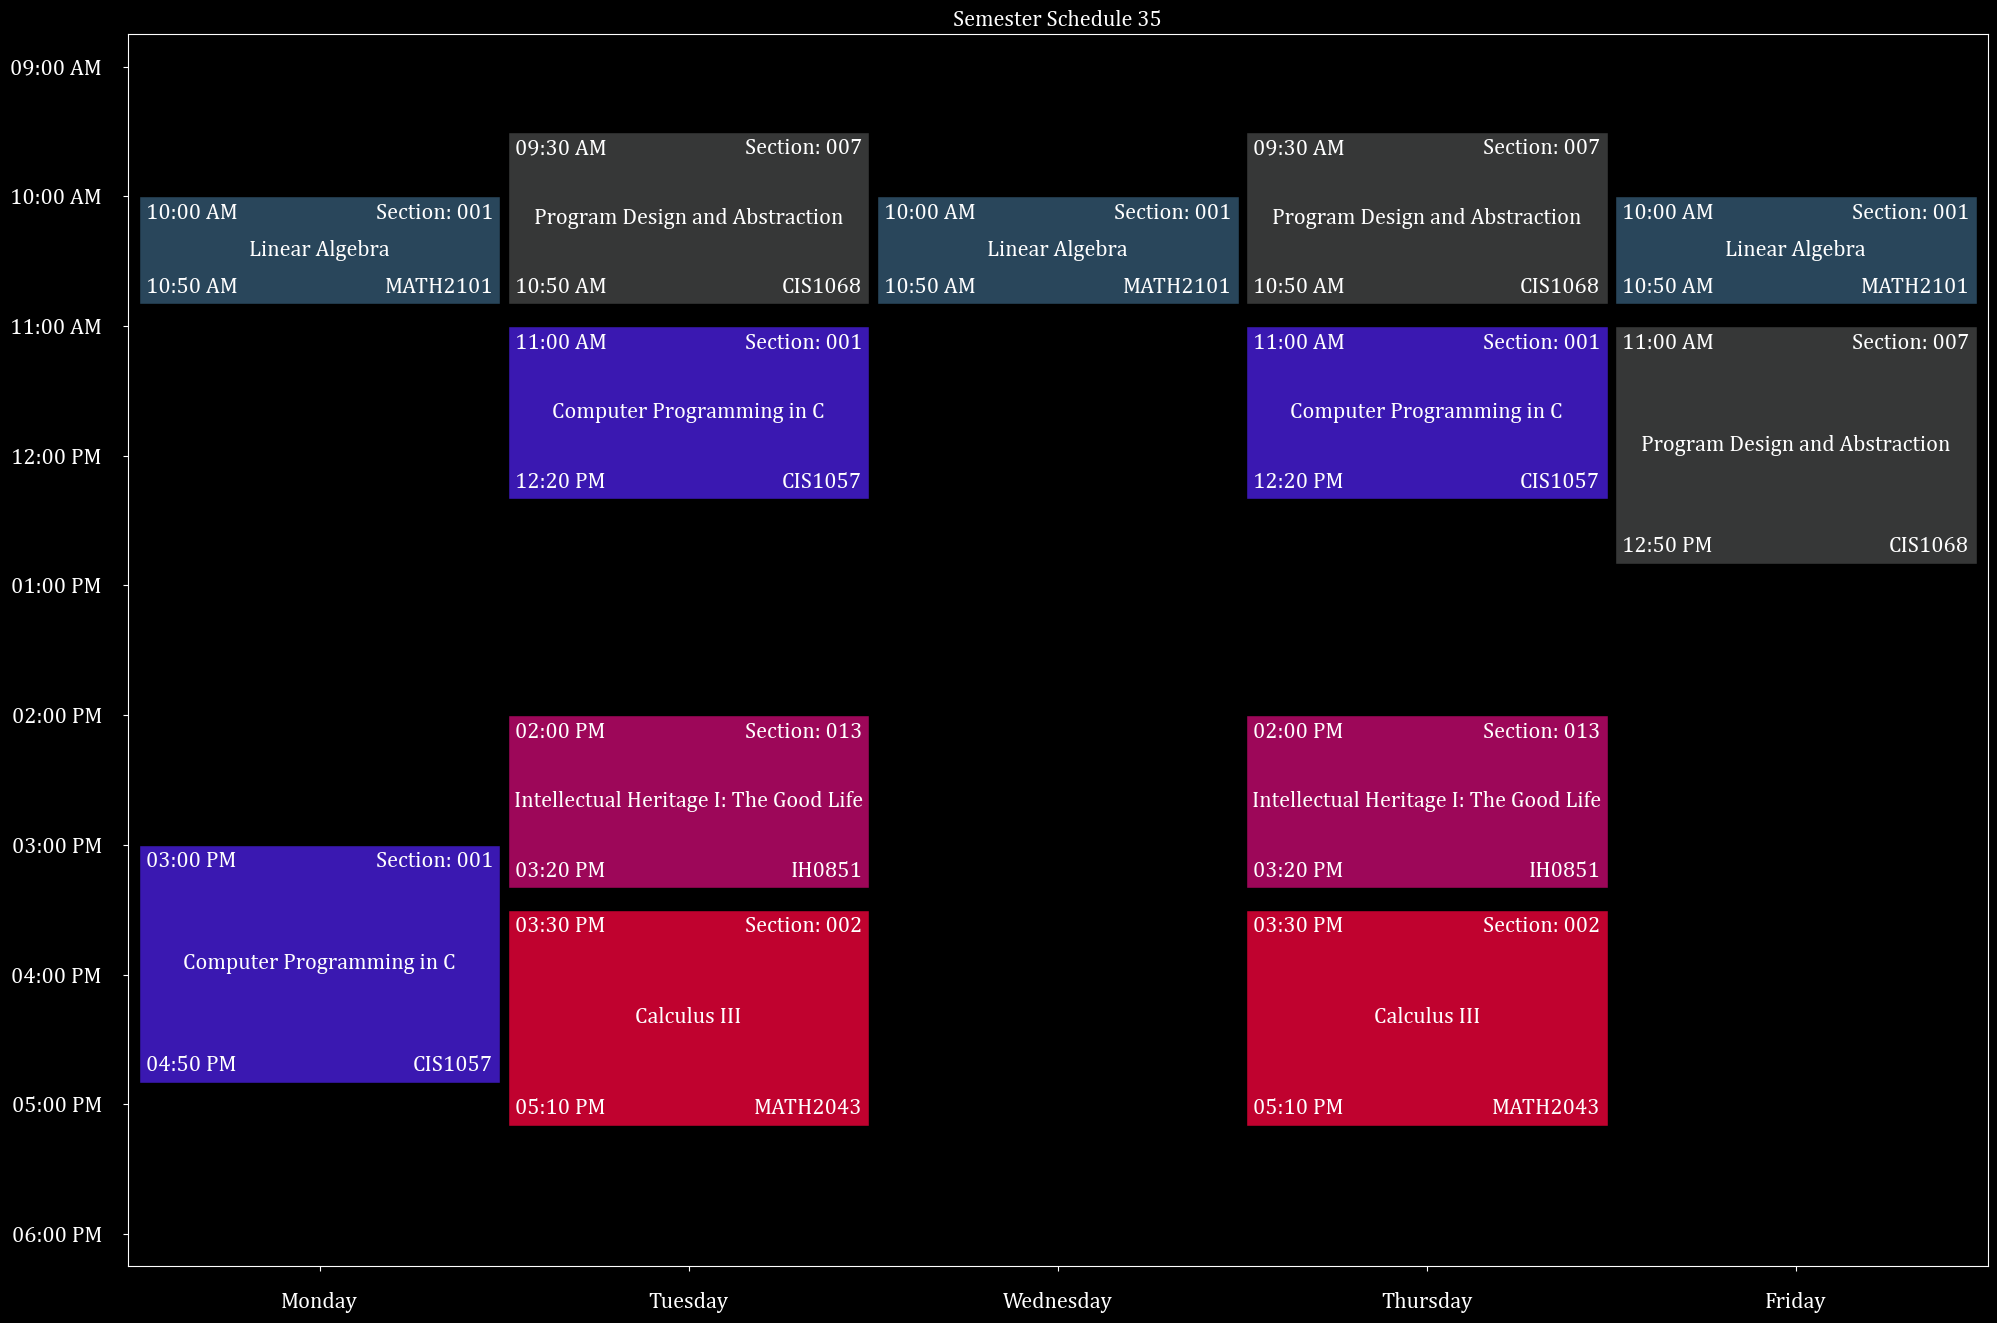

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 706 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


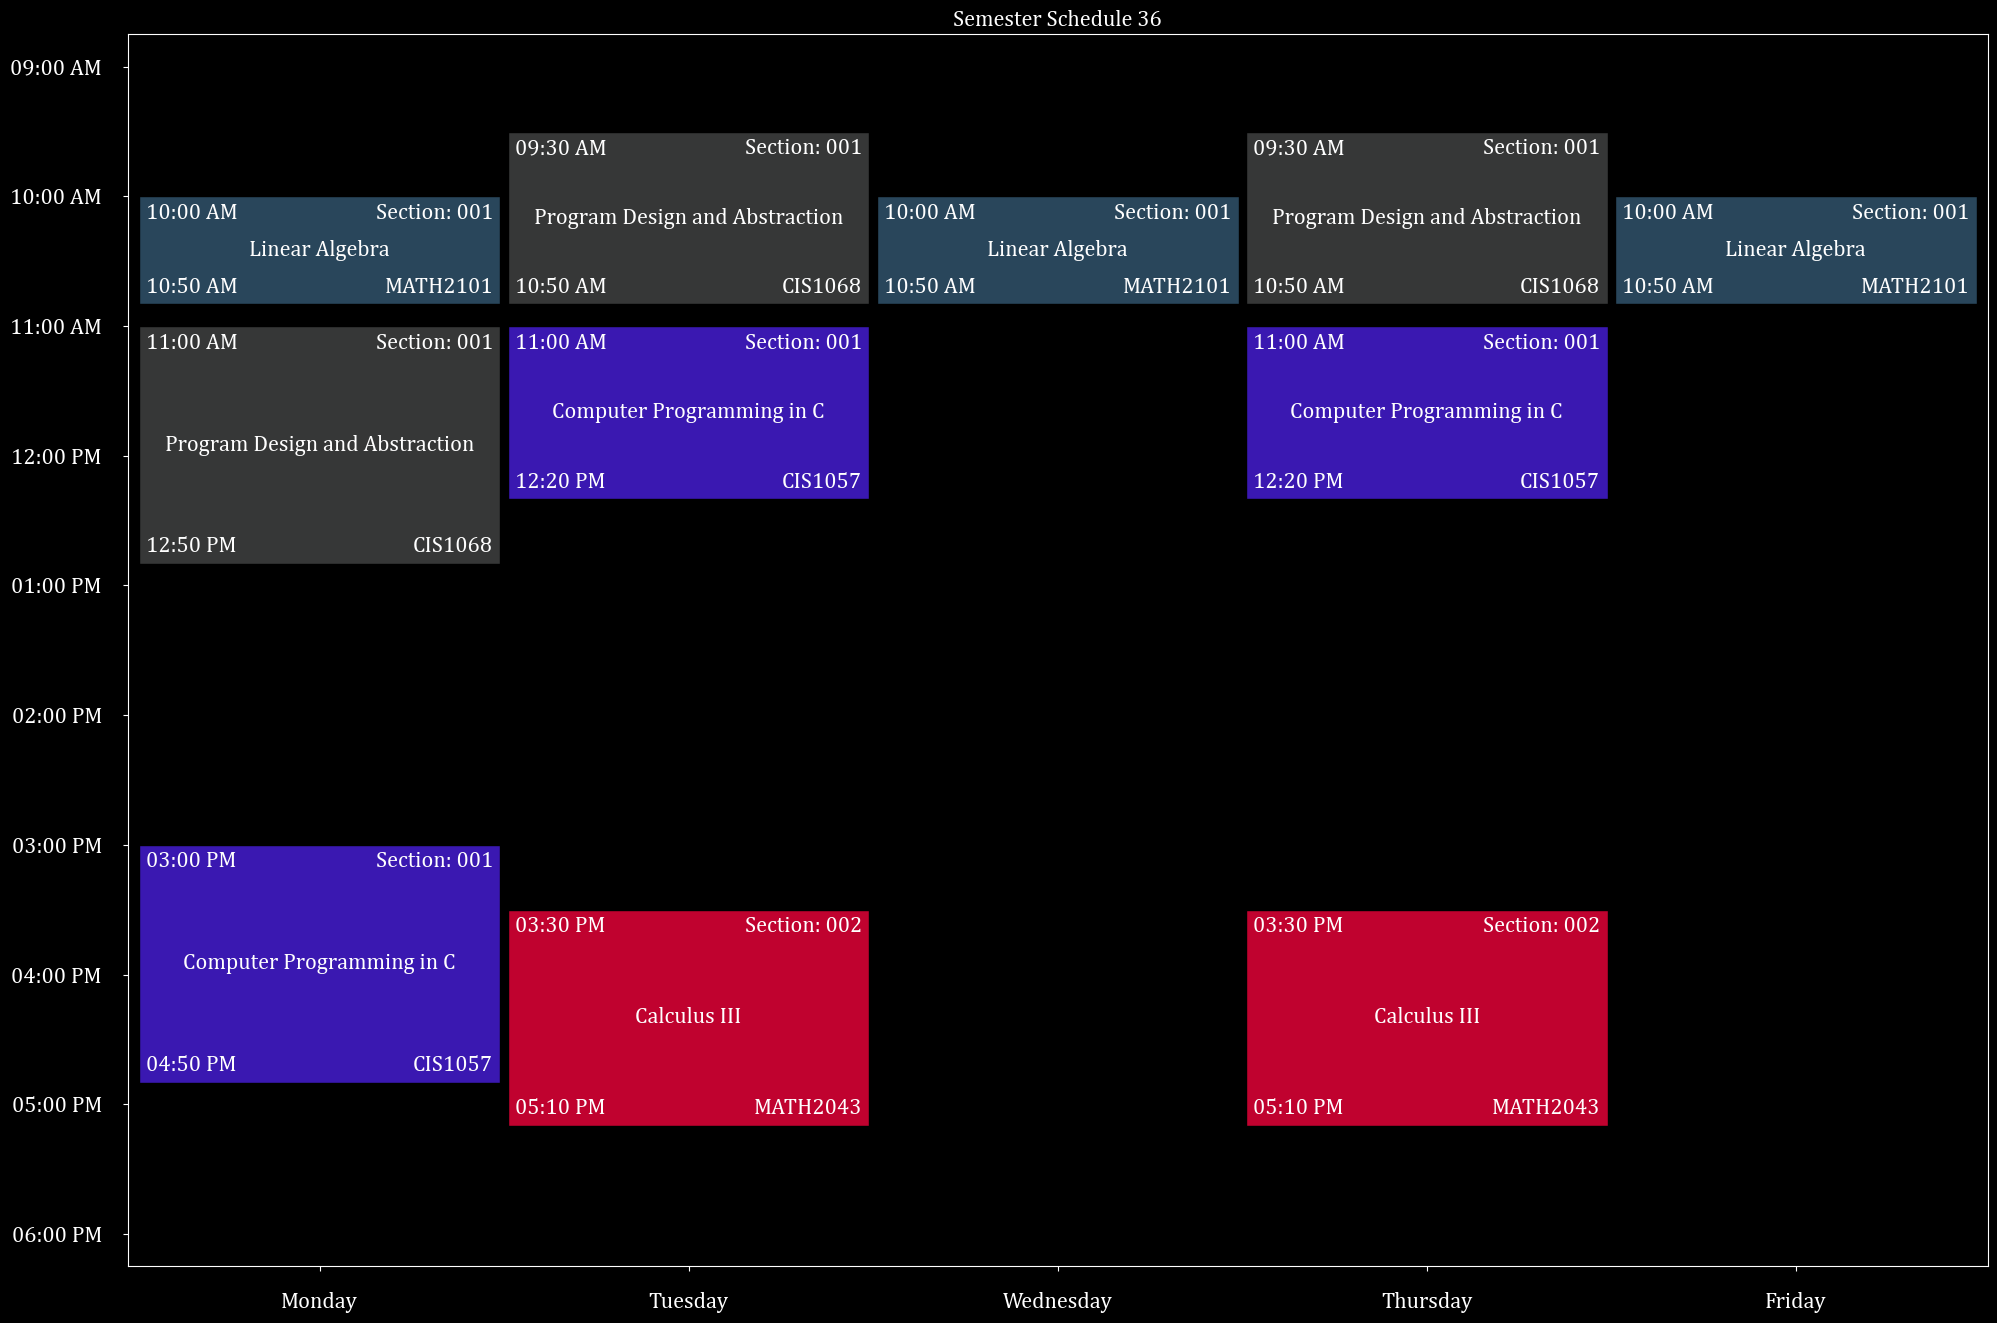

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 707 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


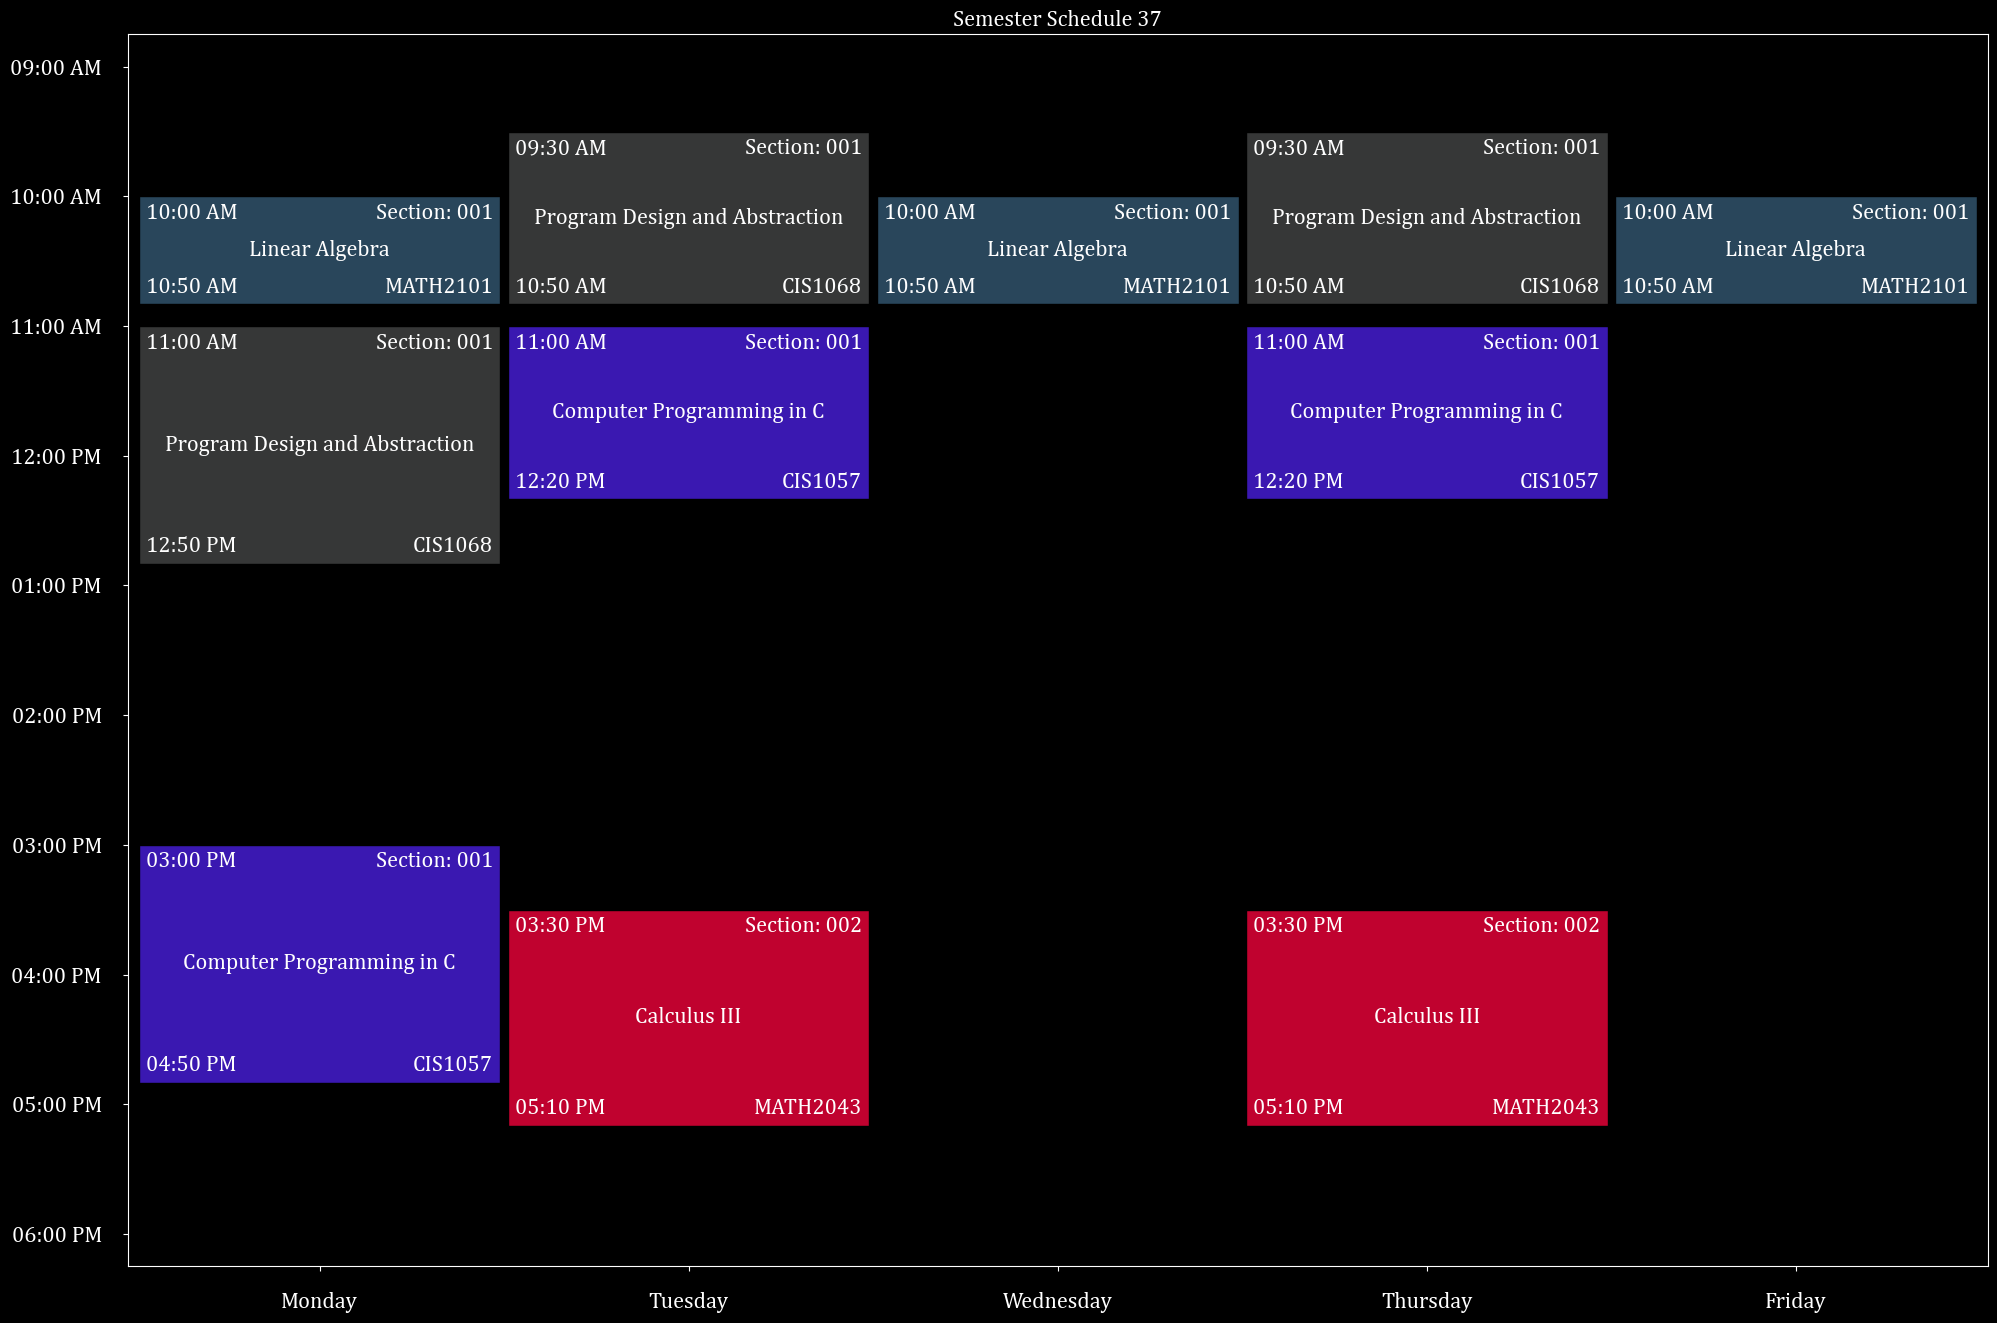

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 002 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 706 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


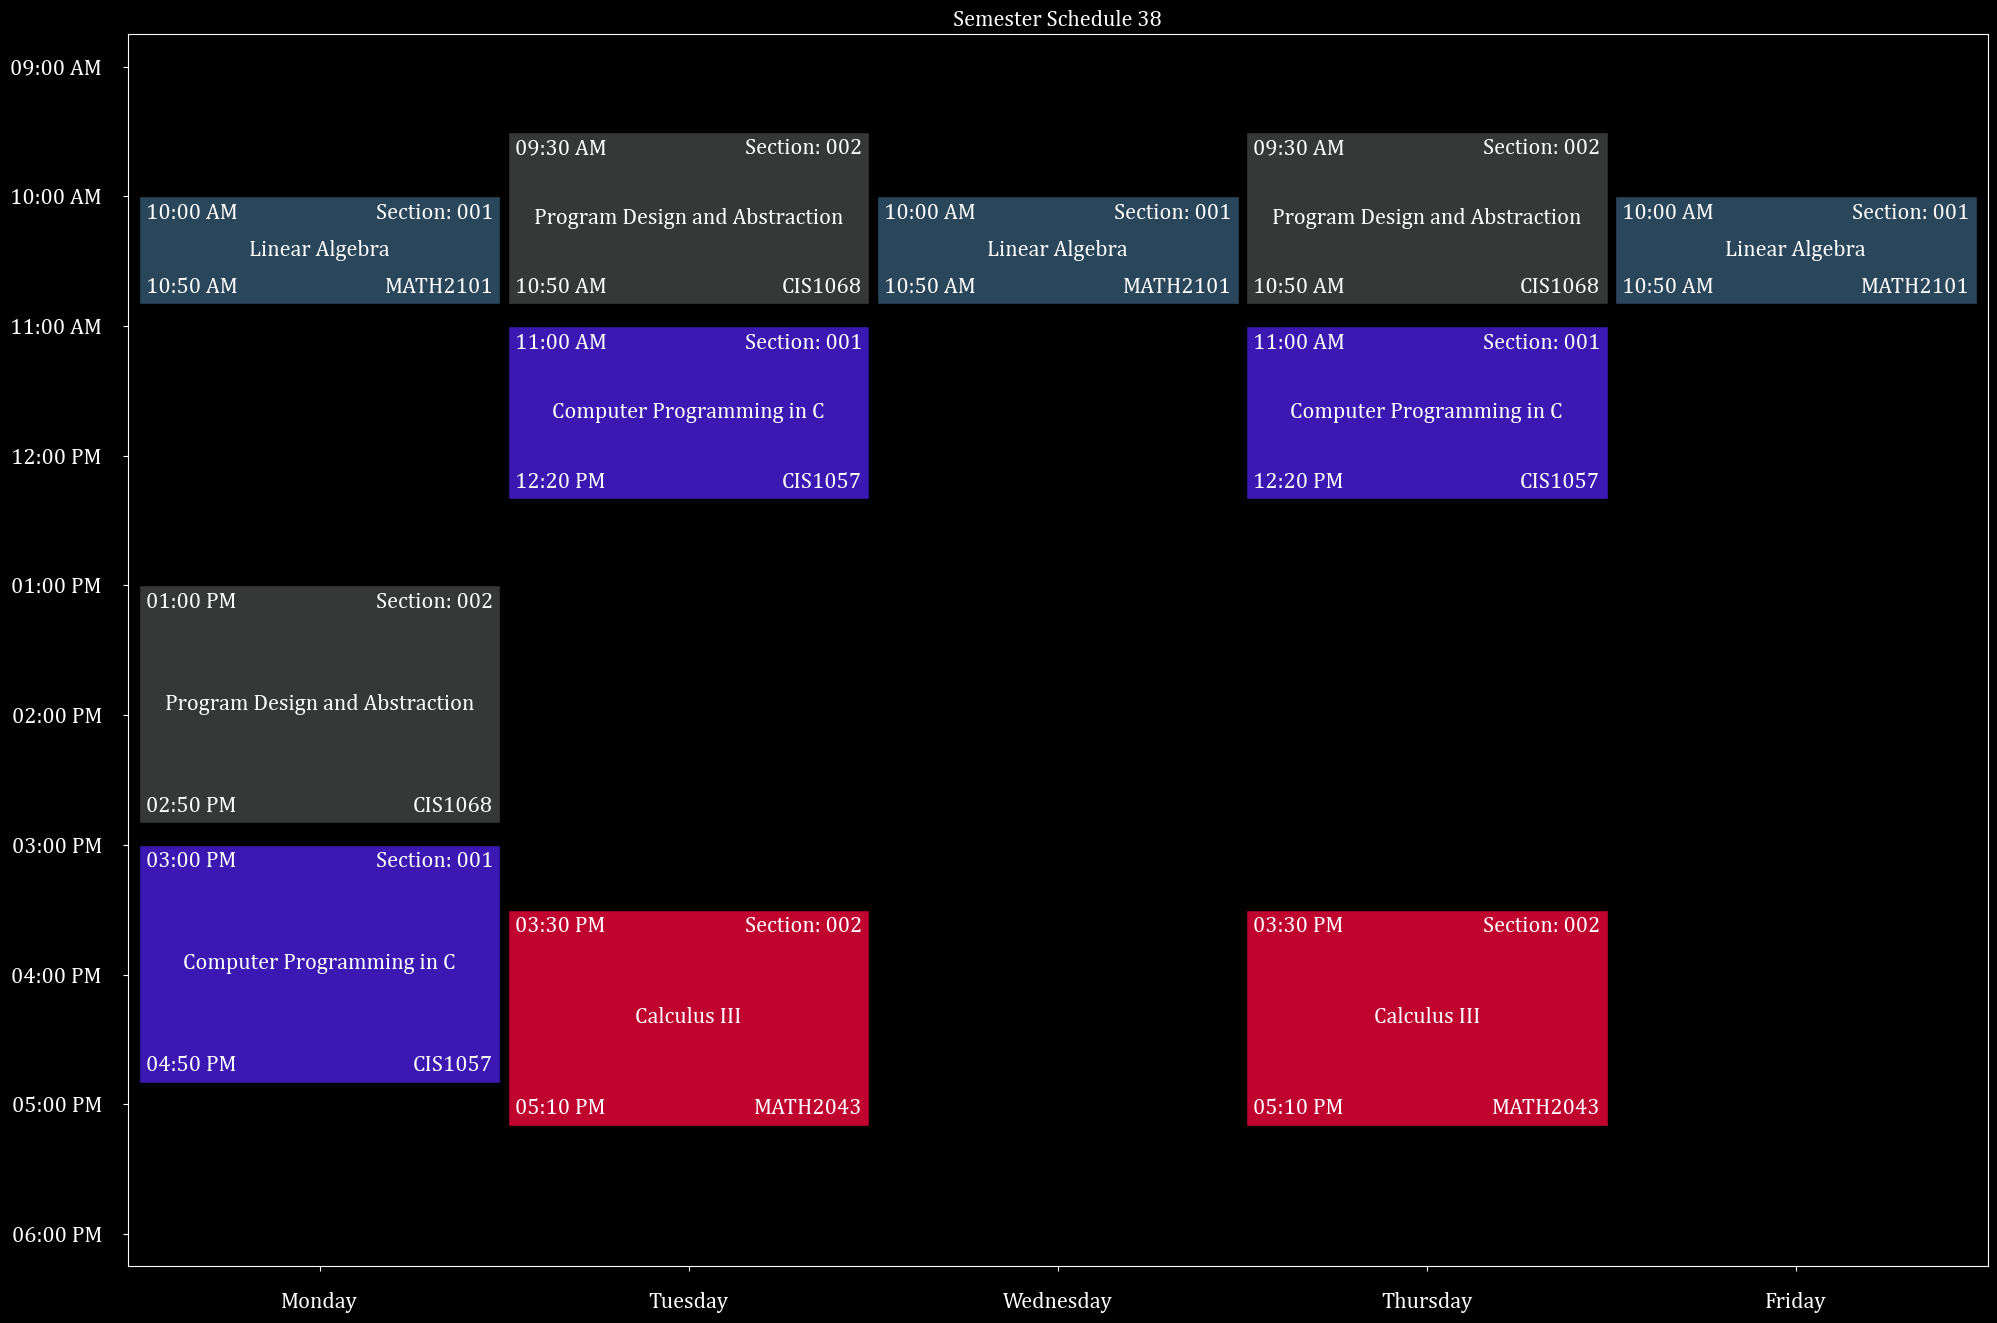

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 002 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 707 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


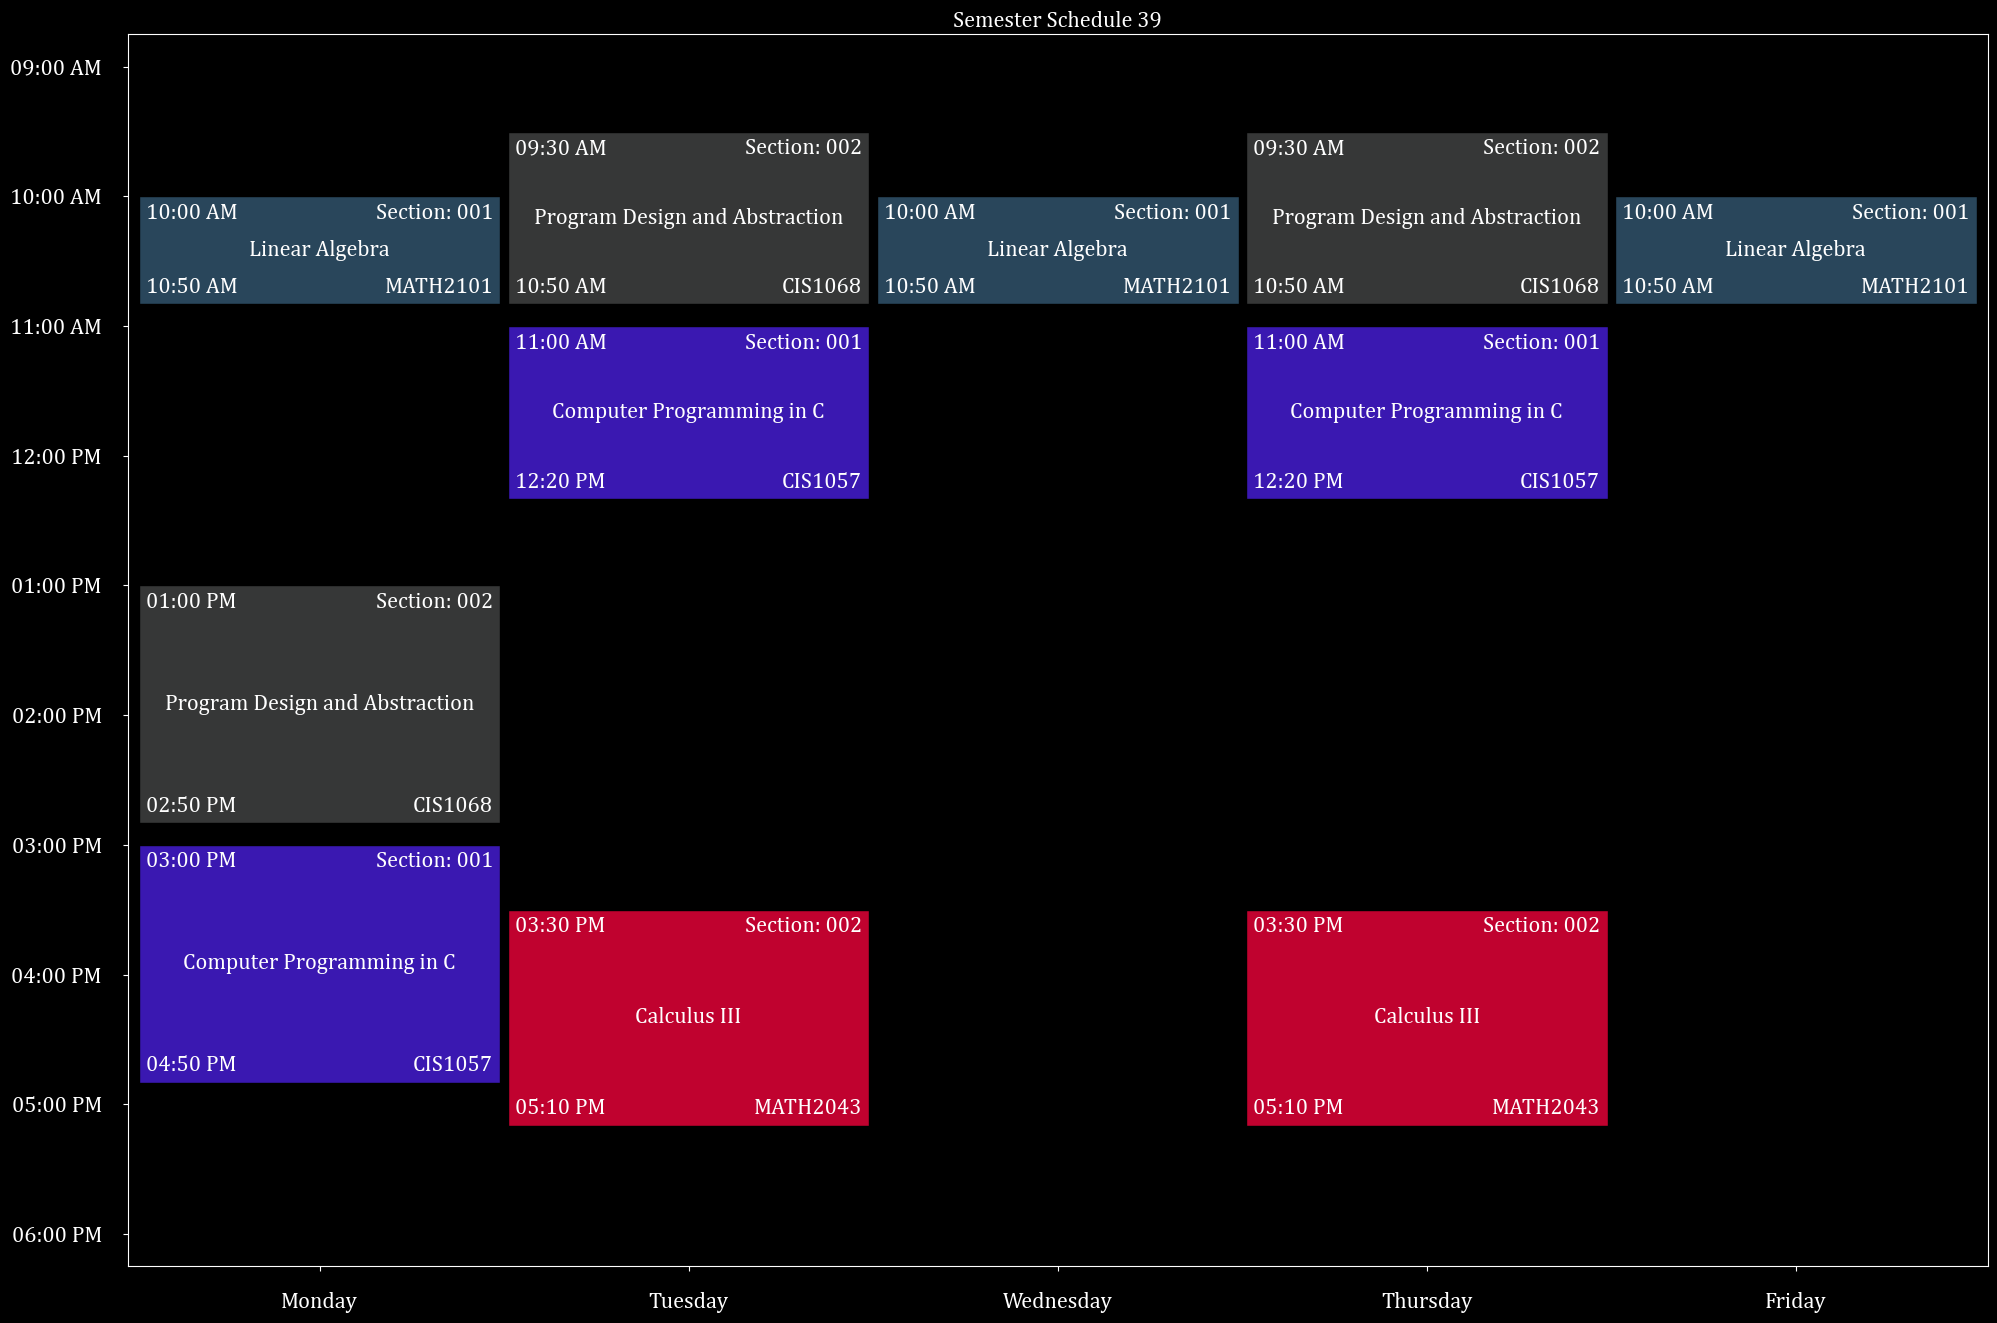

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 003 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 706 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


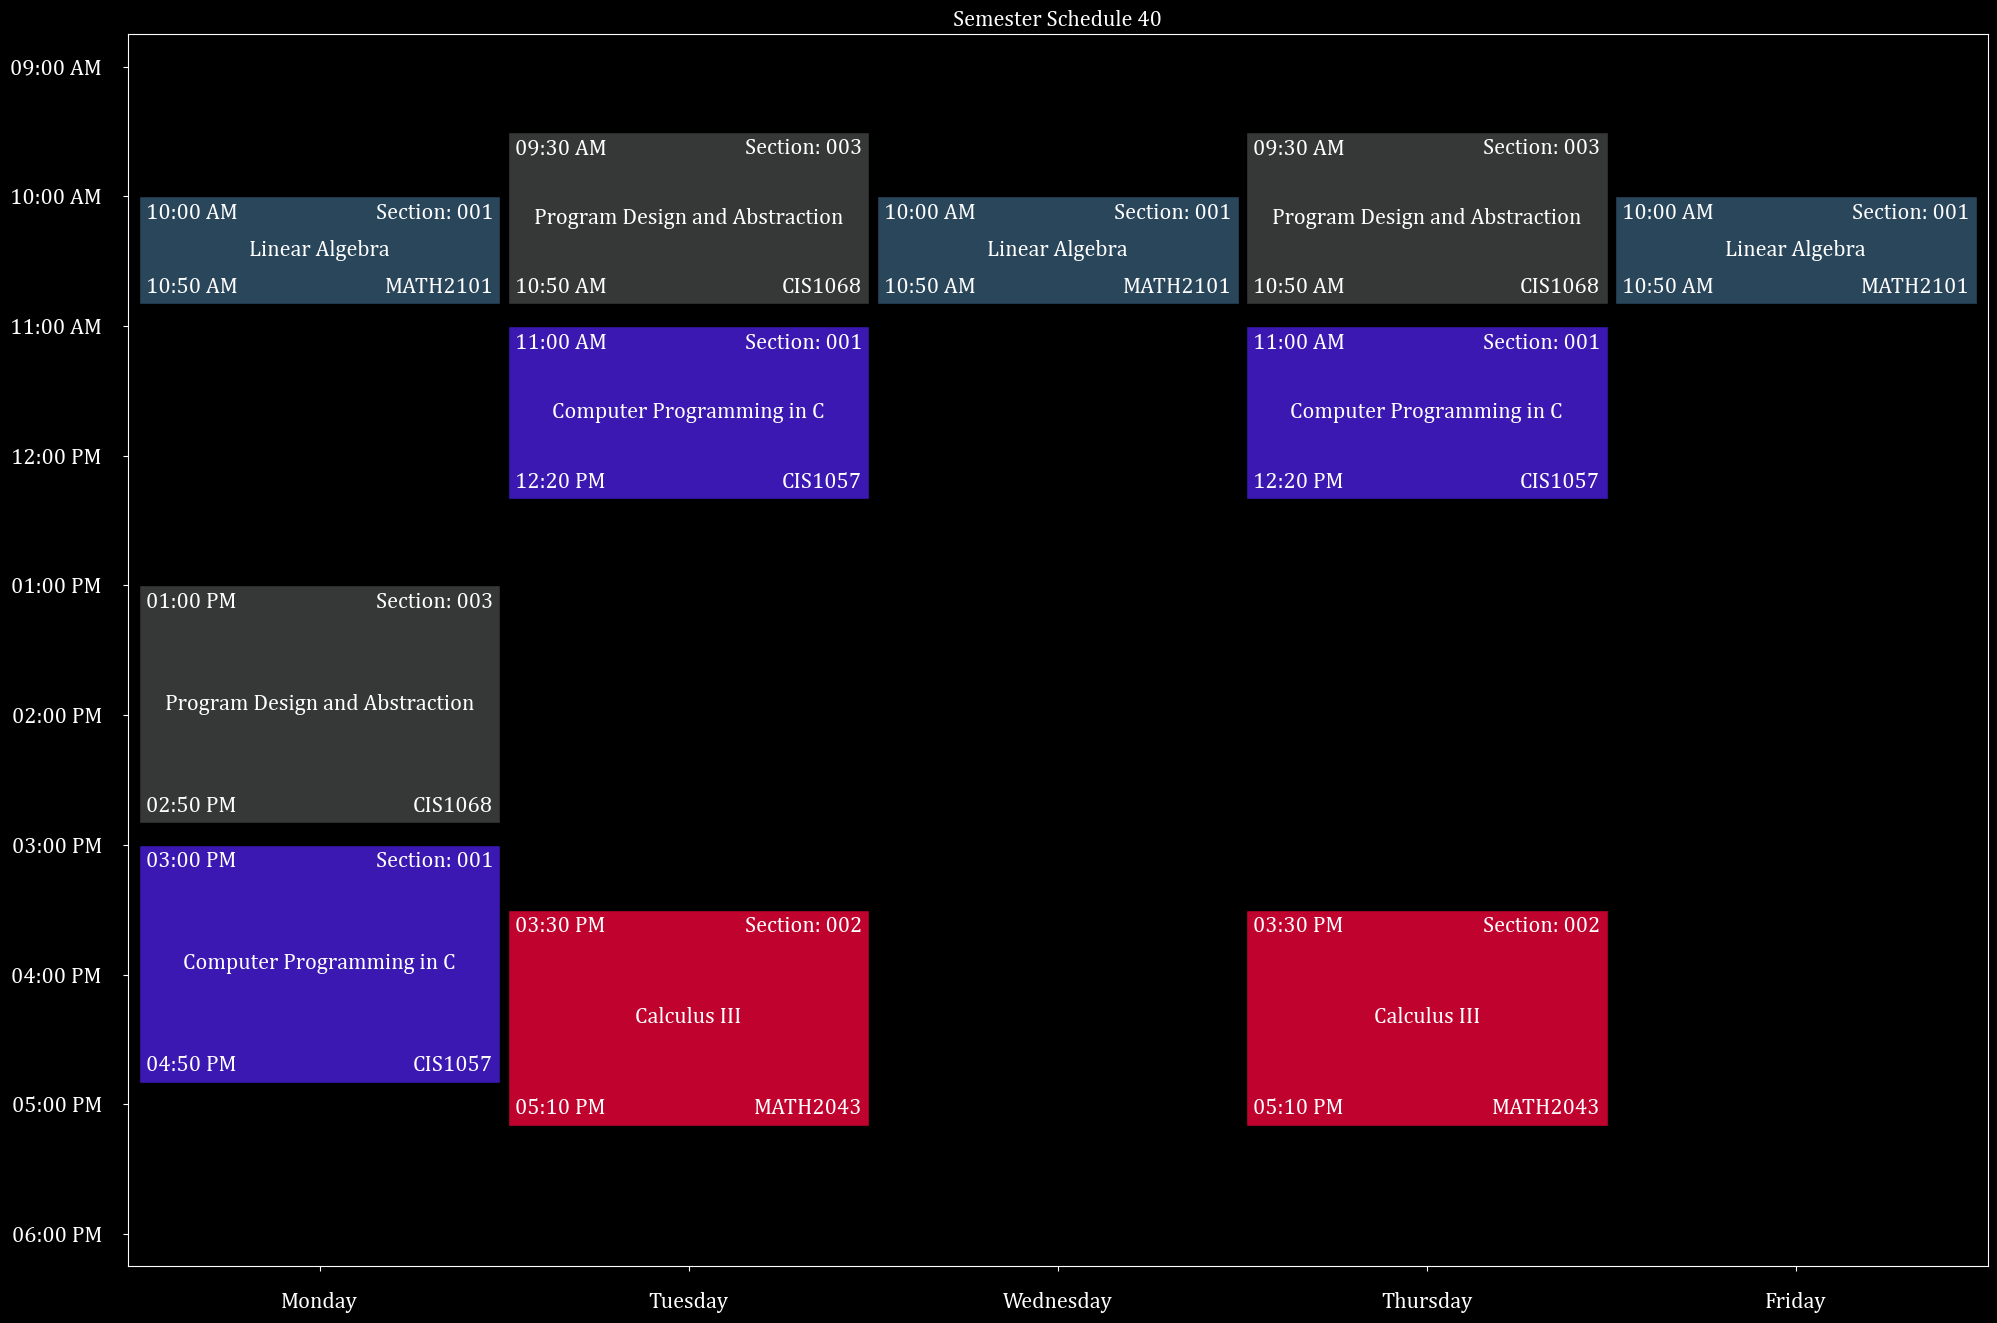

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 003 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 707 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


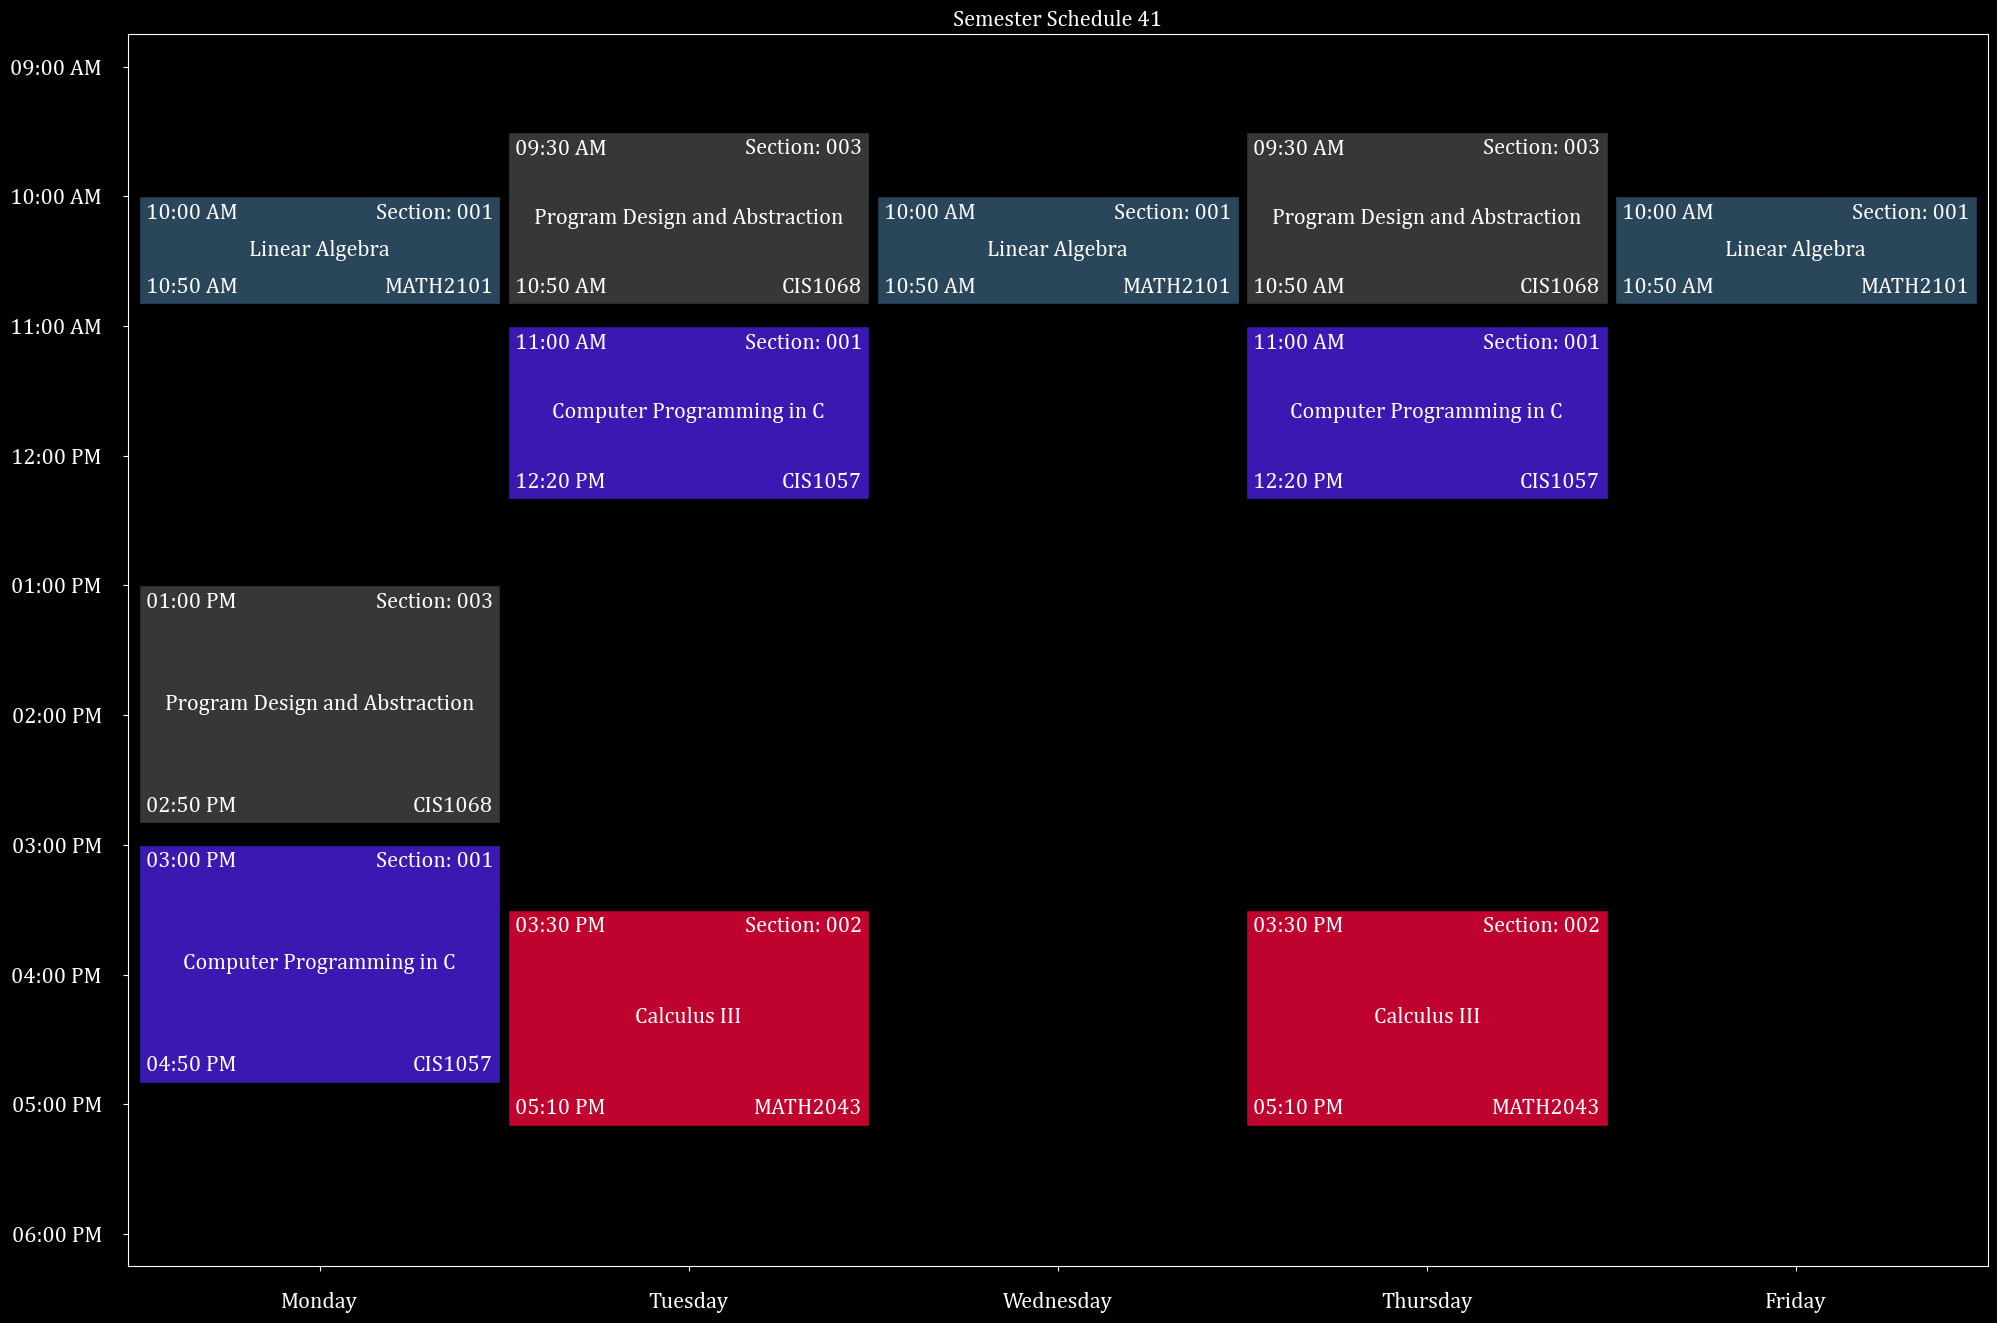

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 004 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 706 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


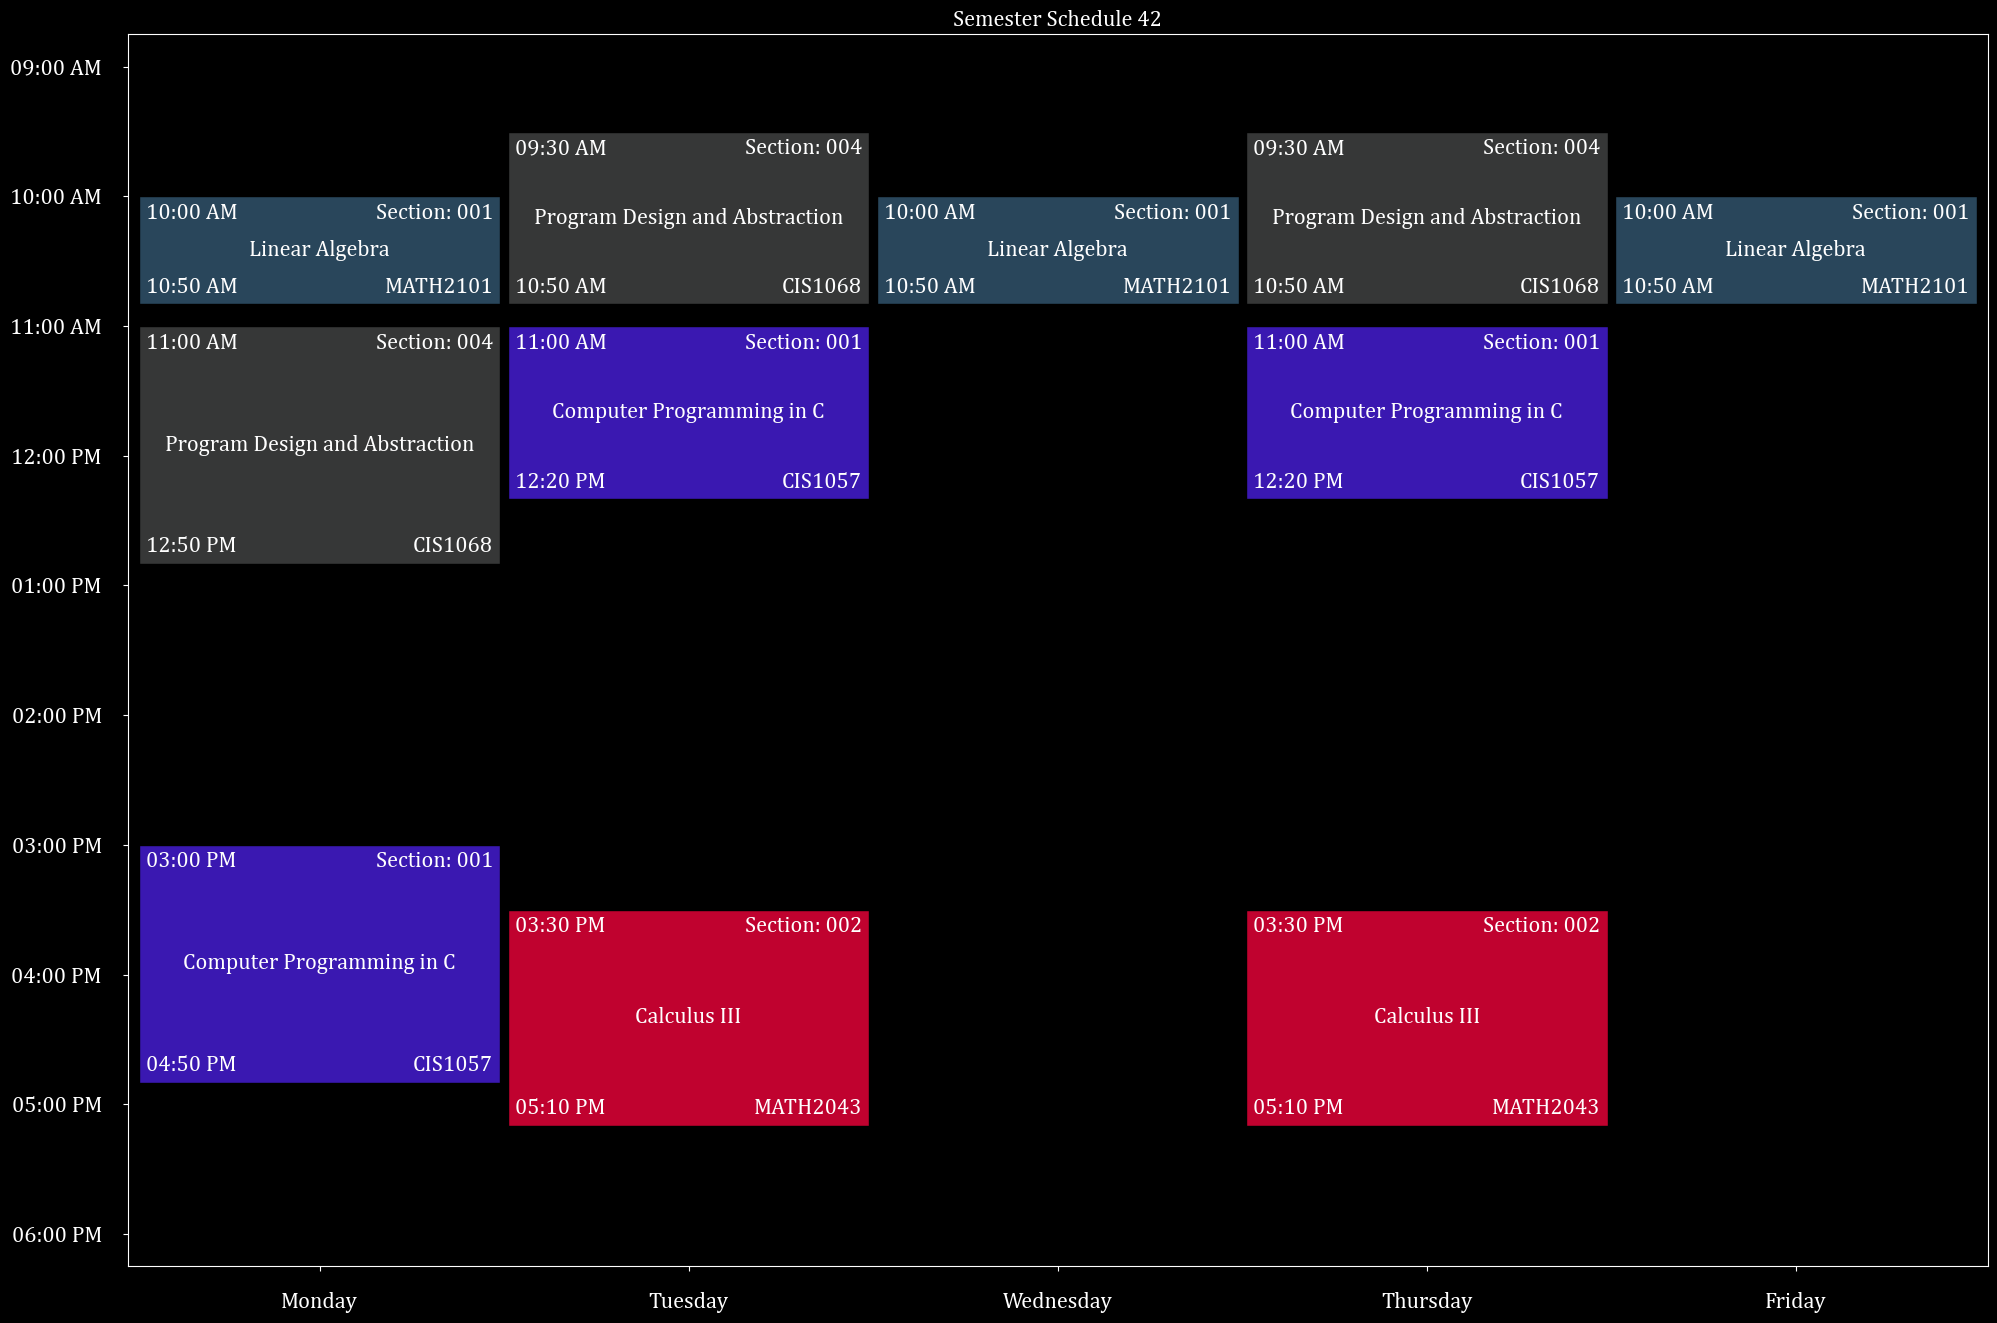

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 004 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 707 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


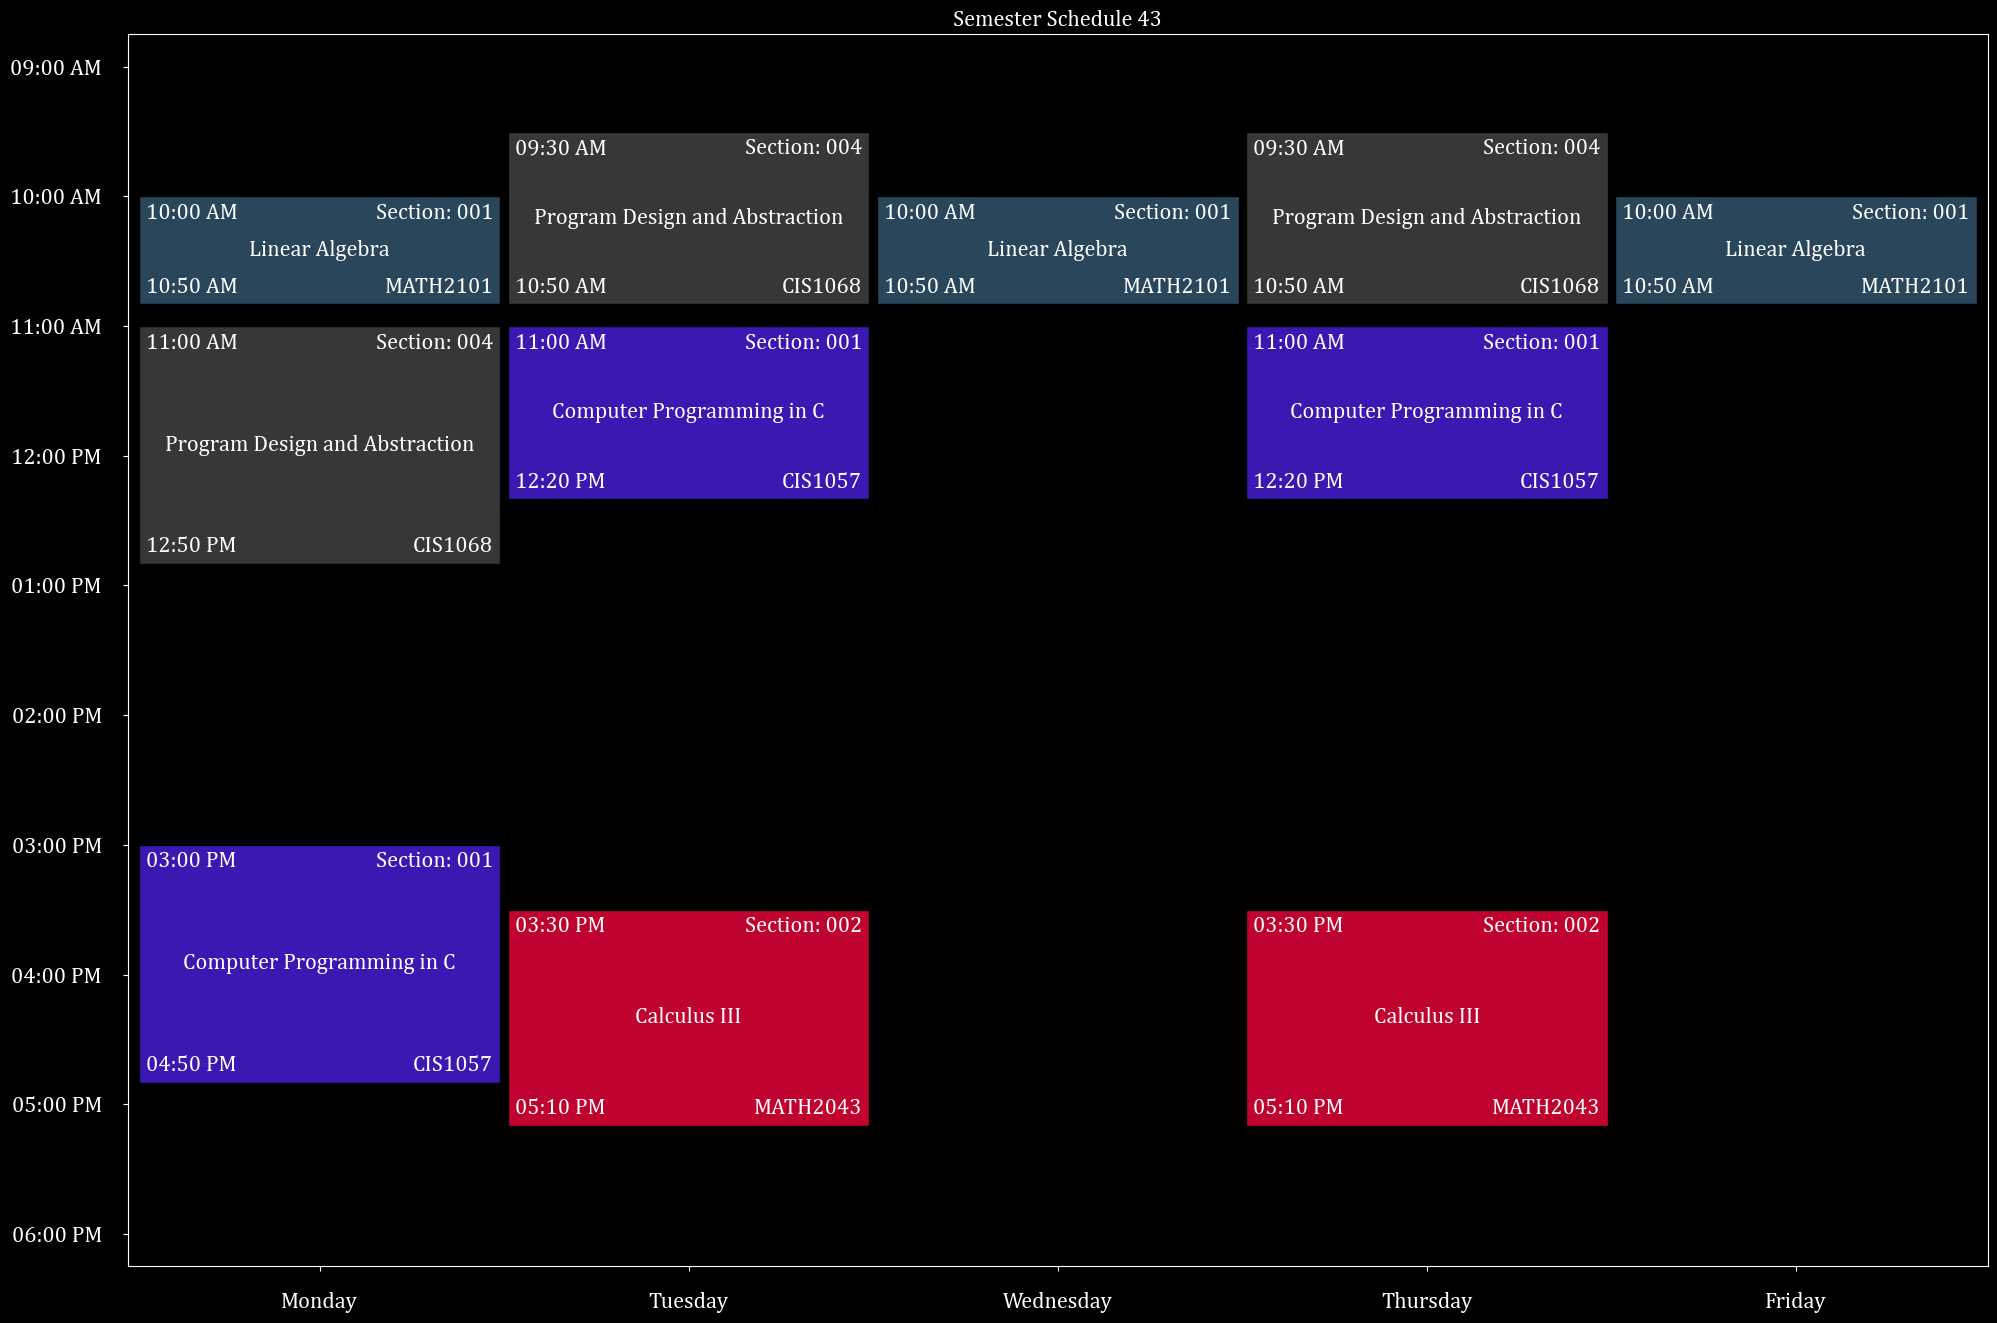

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 005 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 706 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


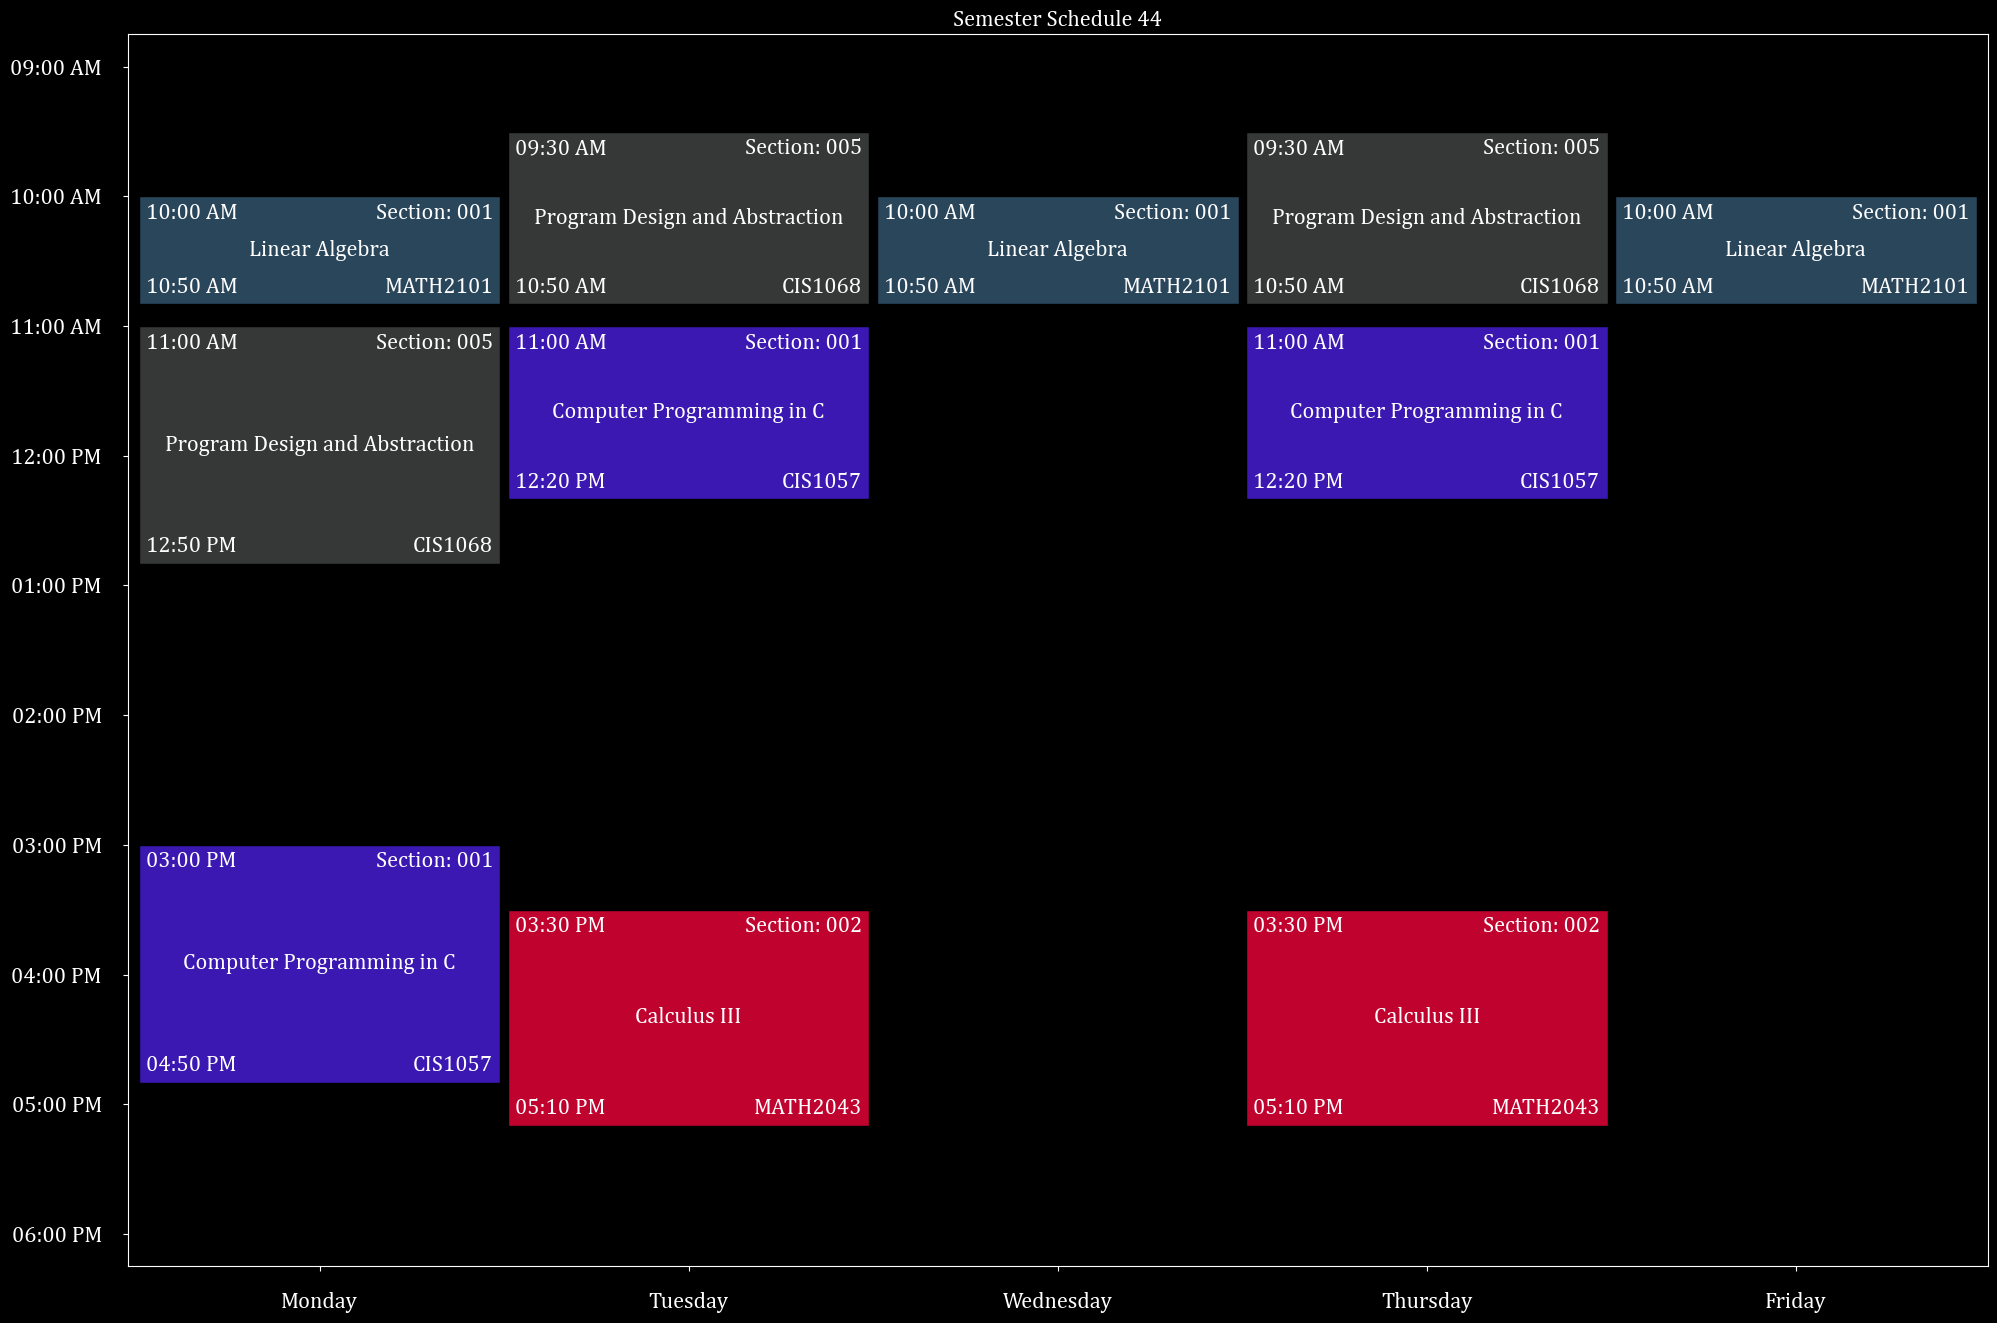

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 005 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 707 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


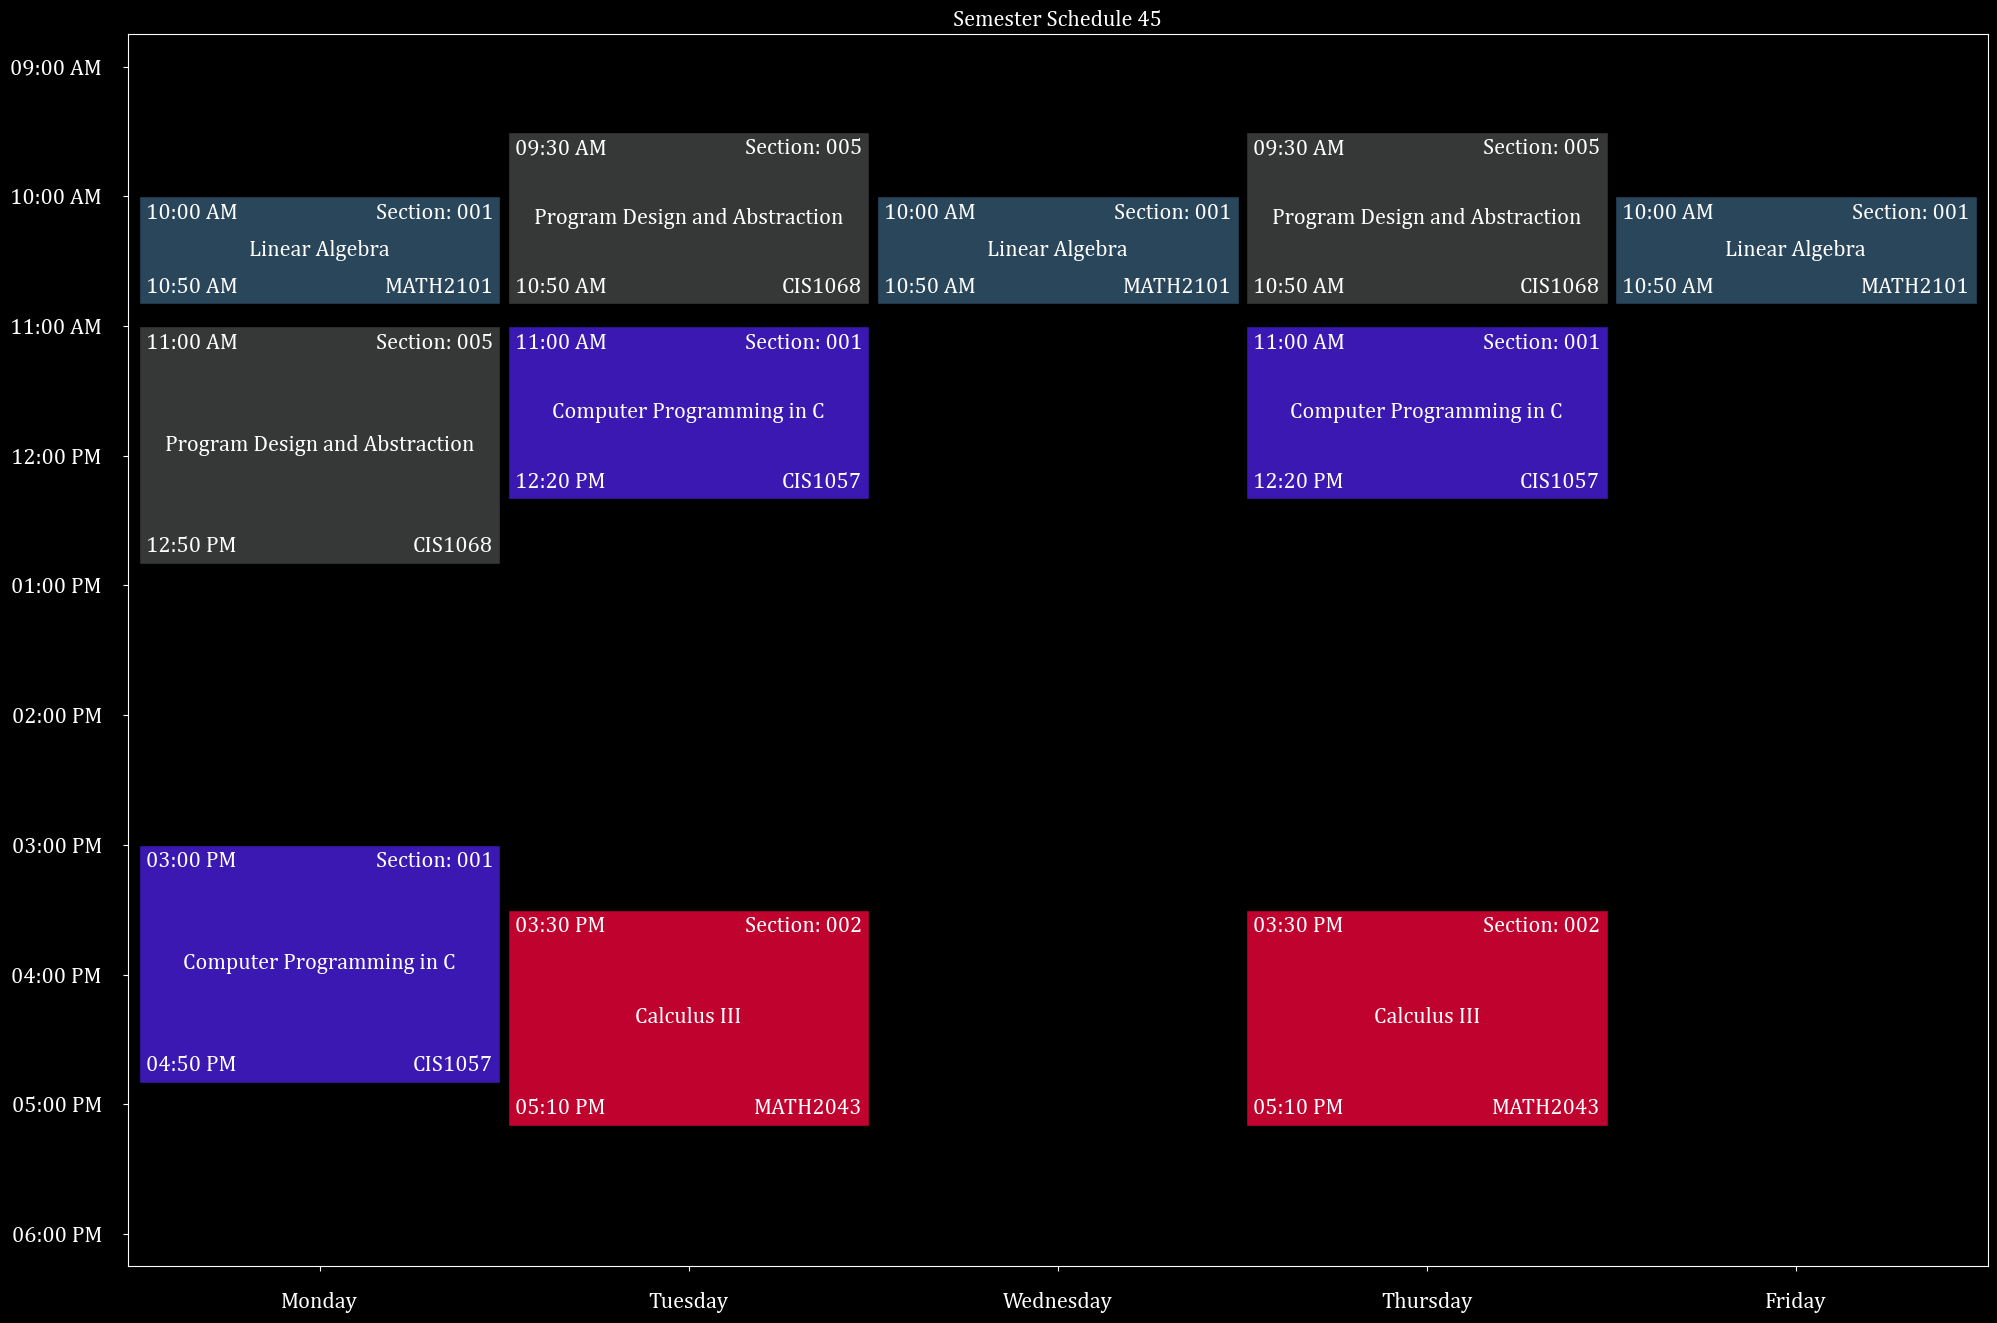

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 006 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 706 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


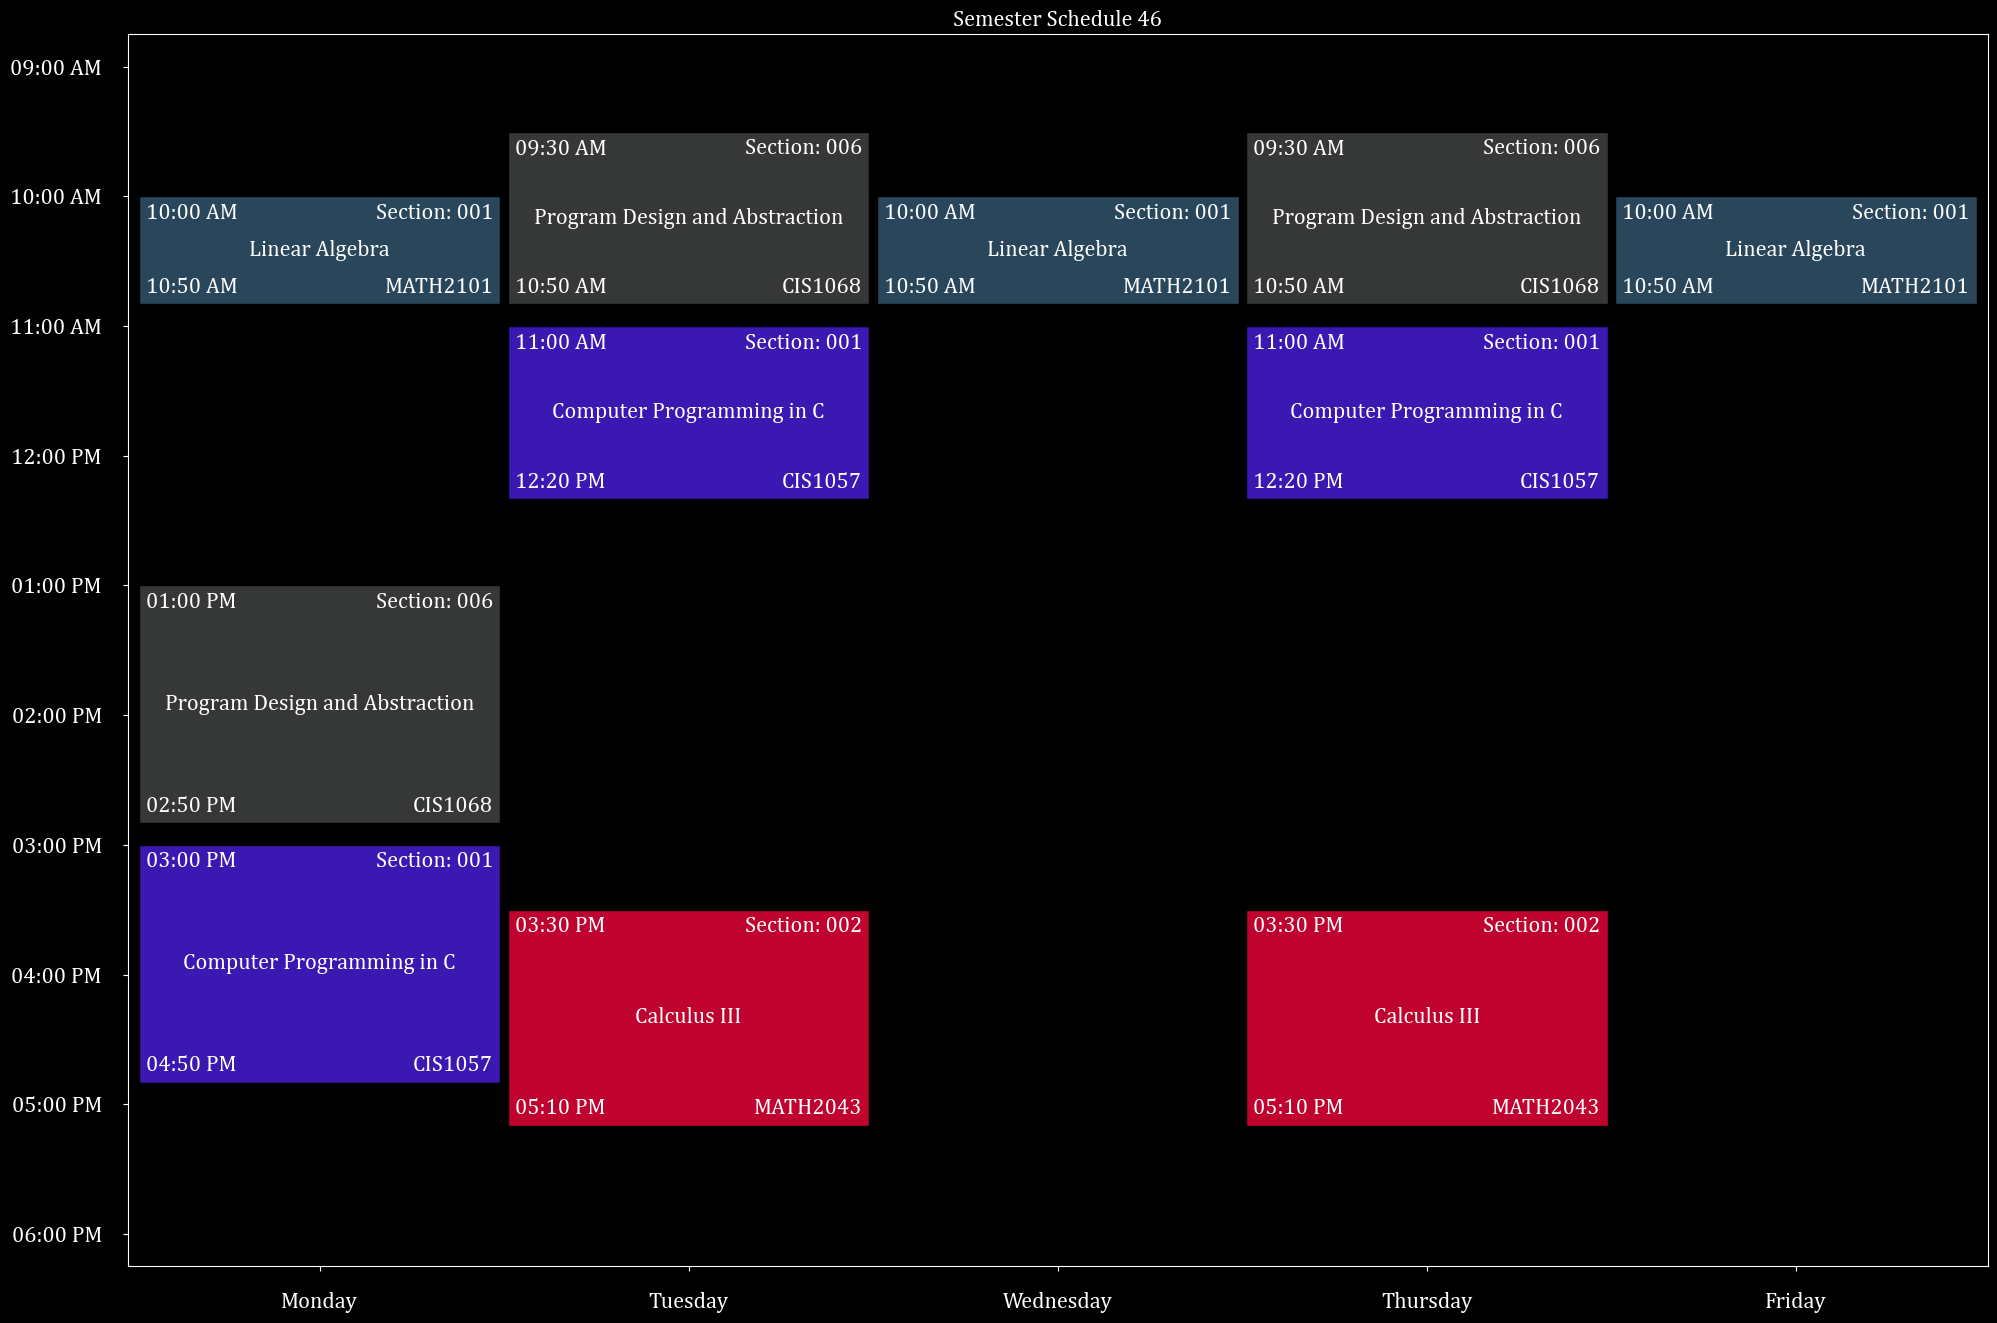

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 006 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 707 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


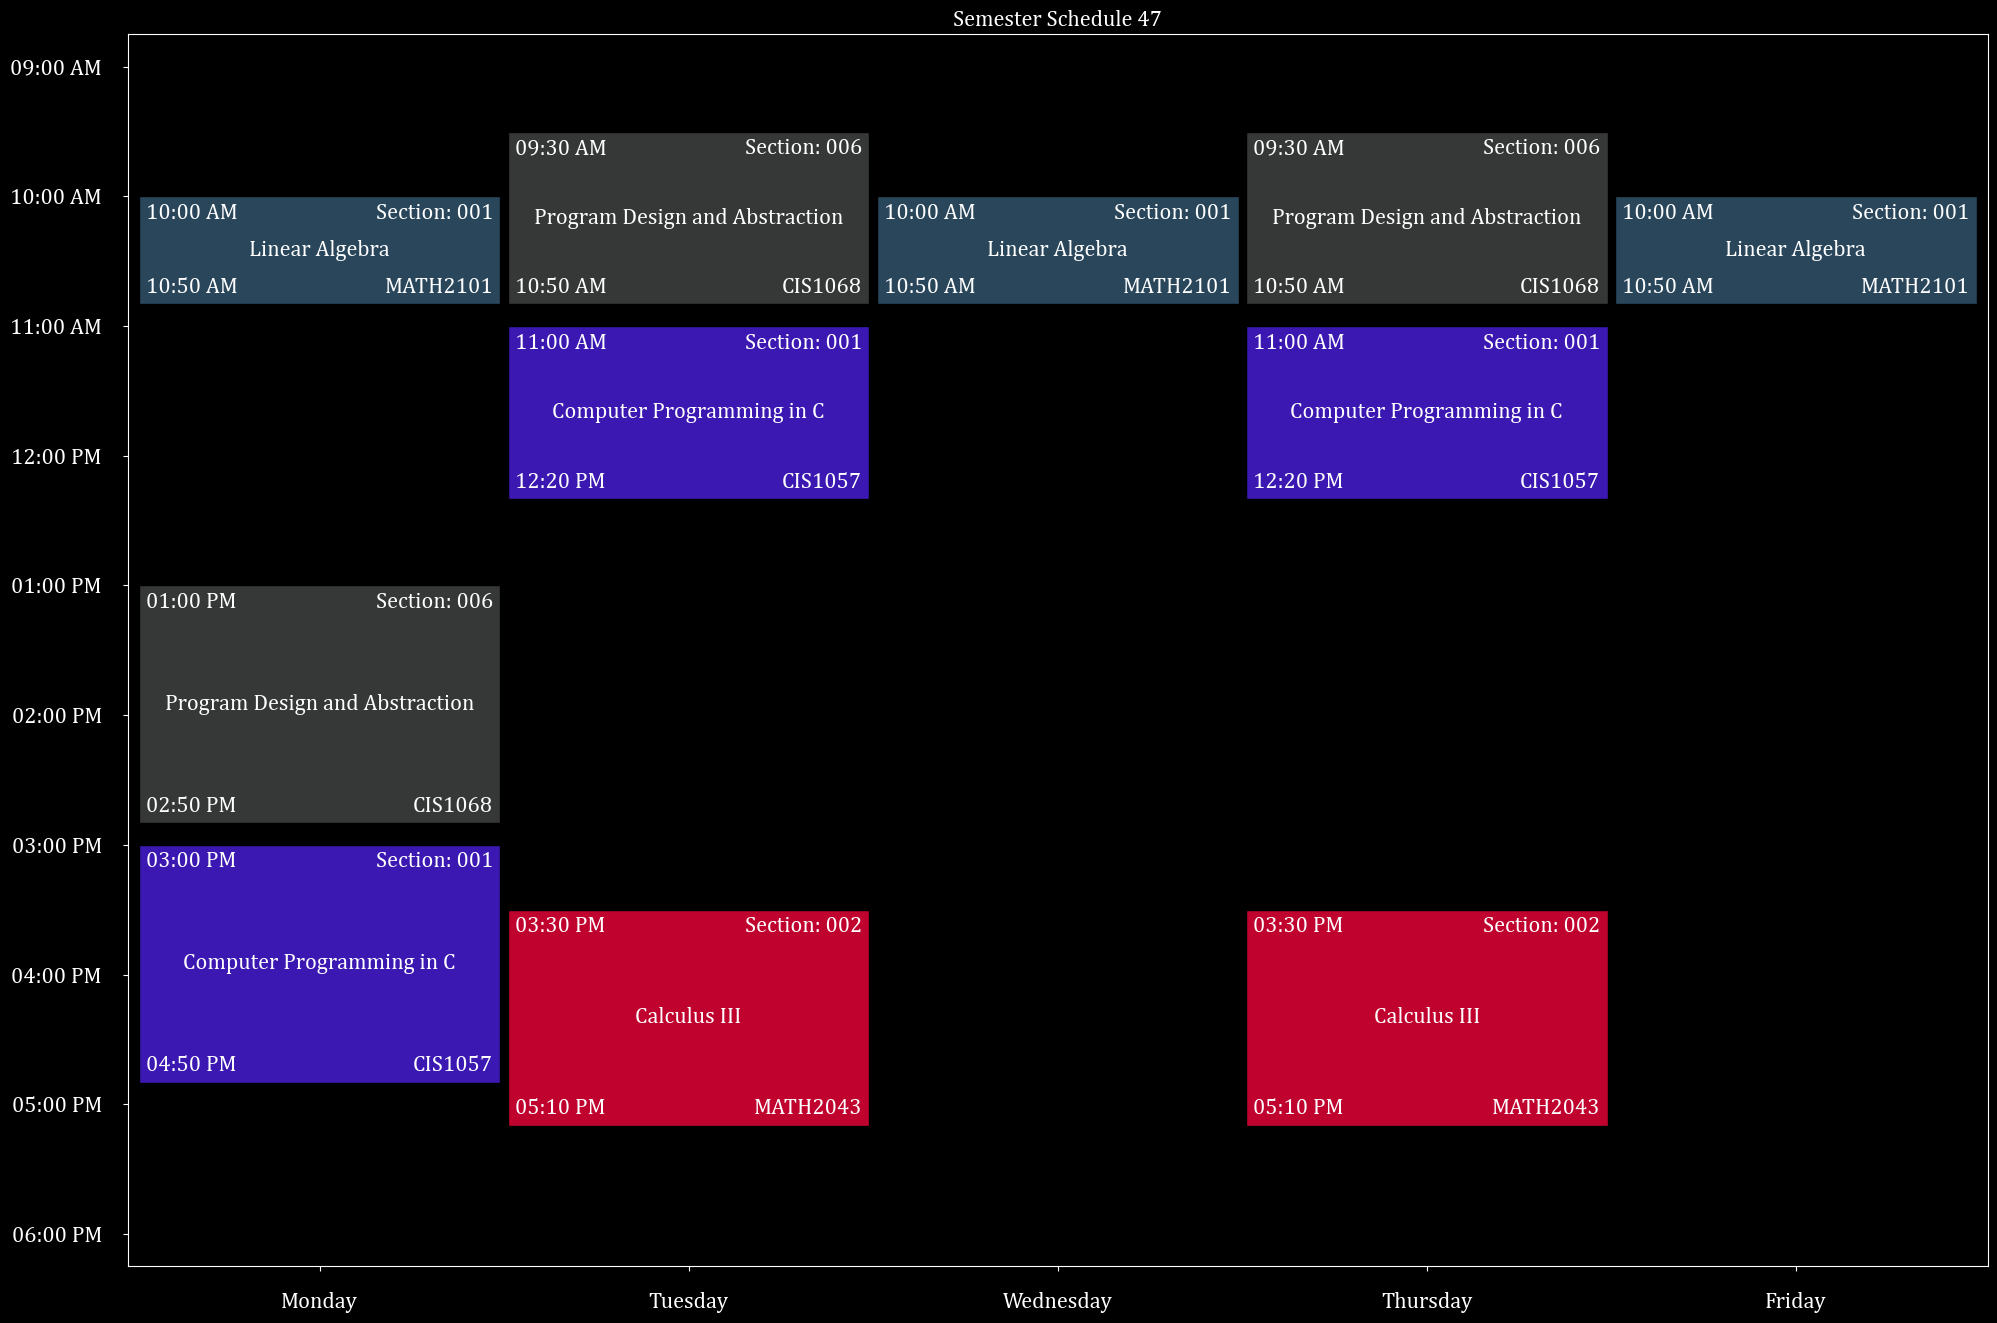

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(11 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 007 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 706 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


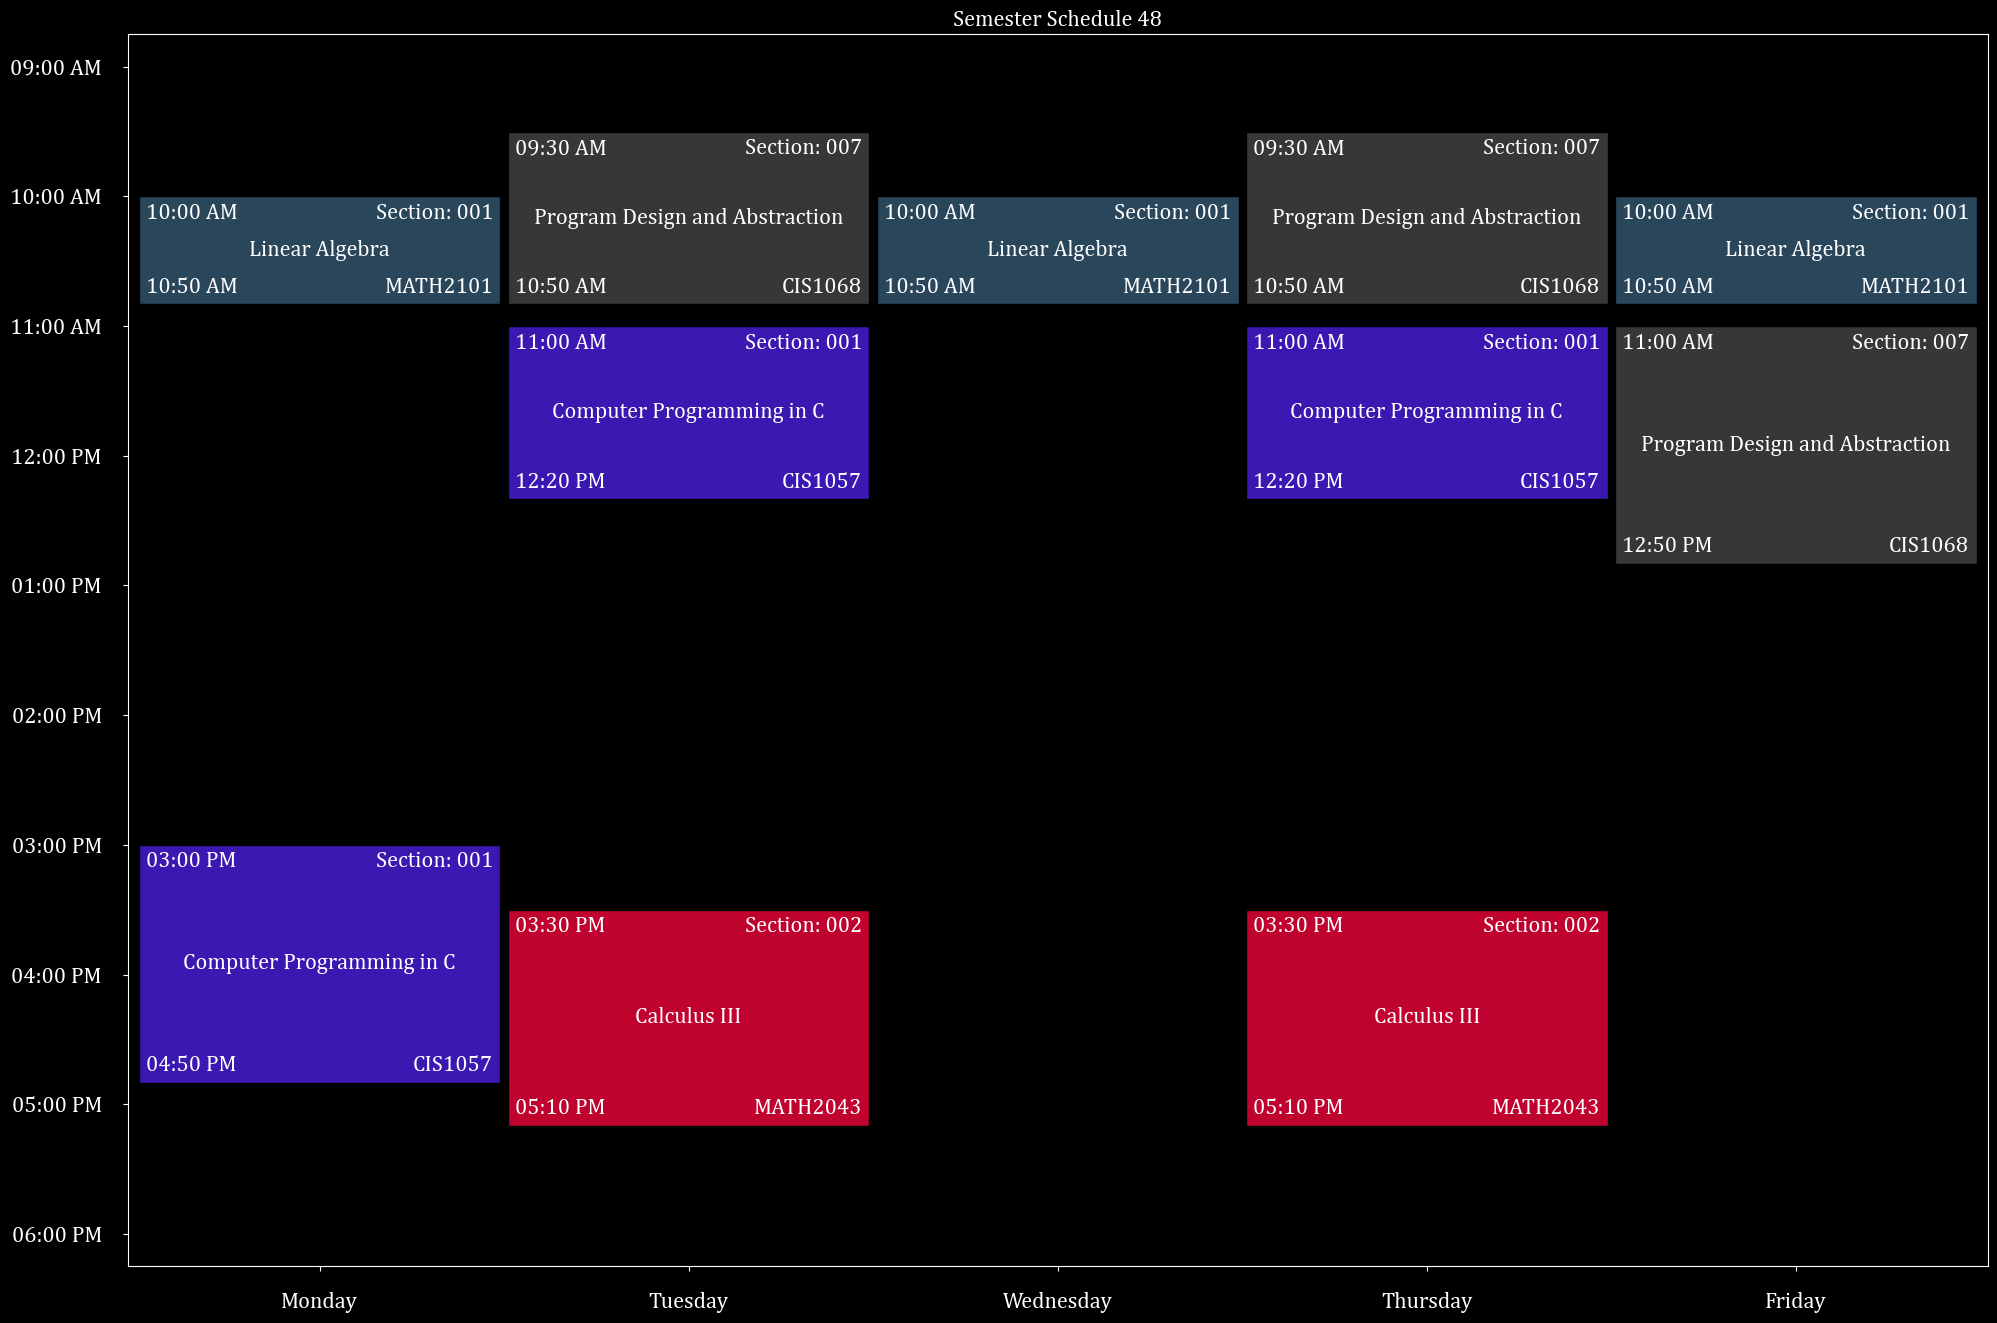

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(11 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 007 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 707 | Rebekah Zhuraw | 3.80 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.092 avg


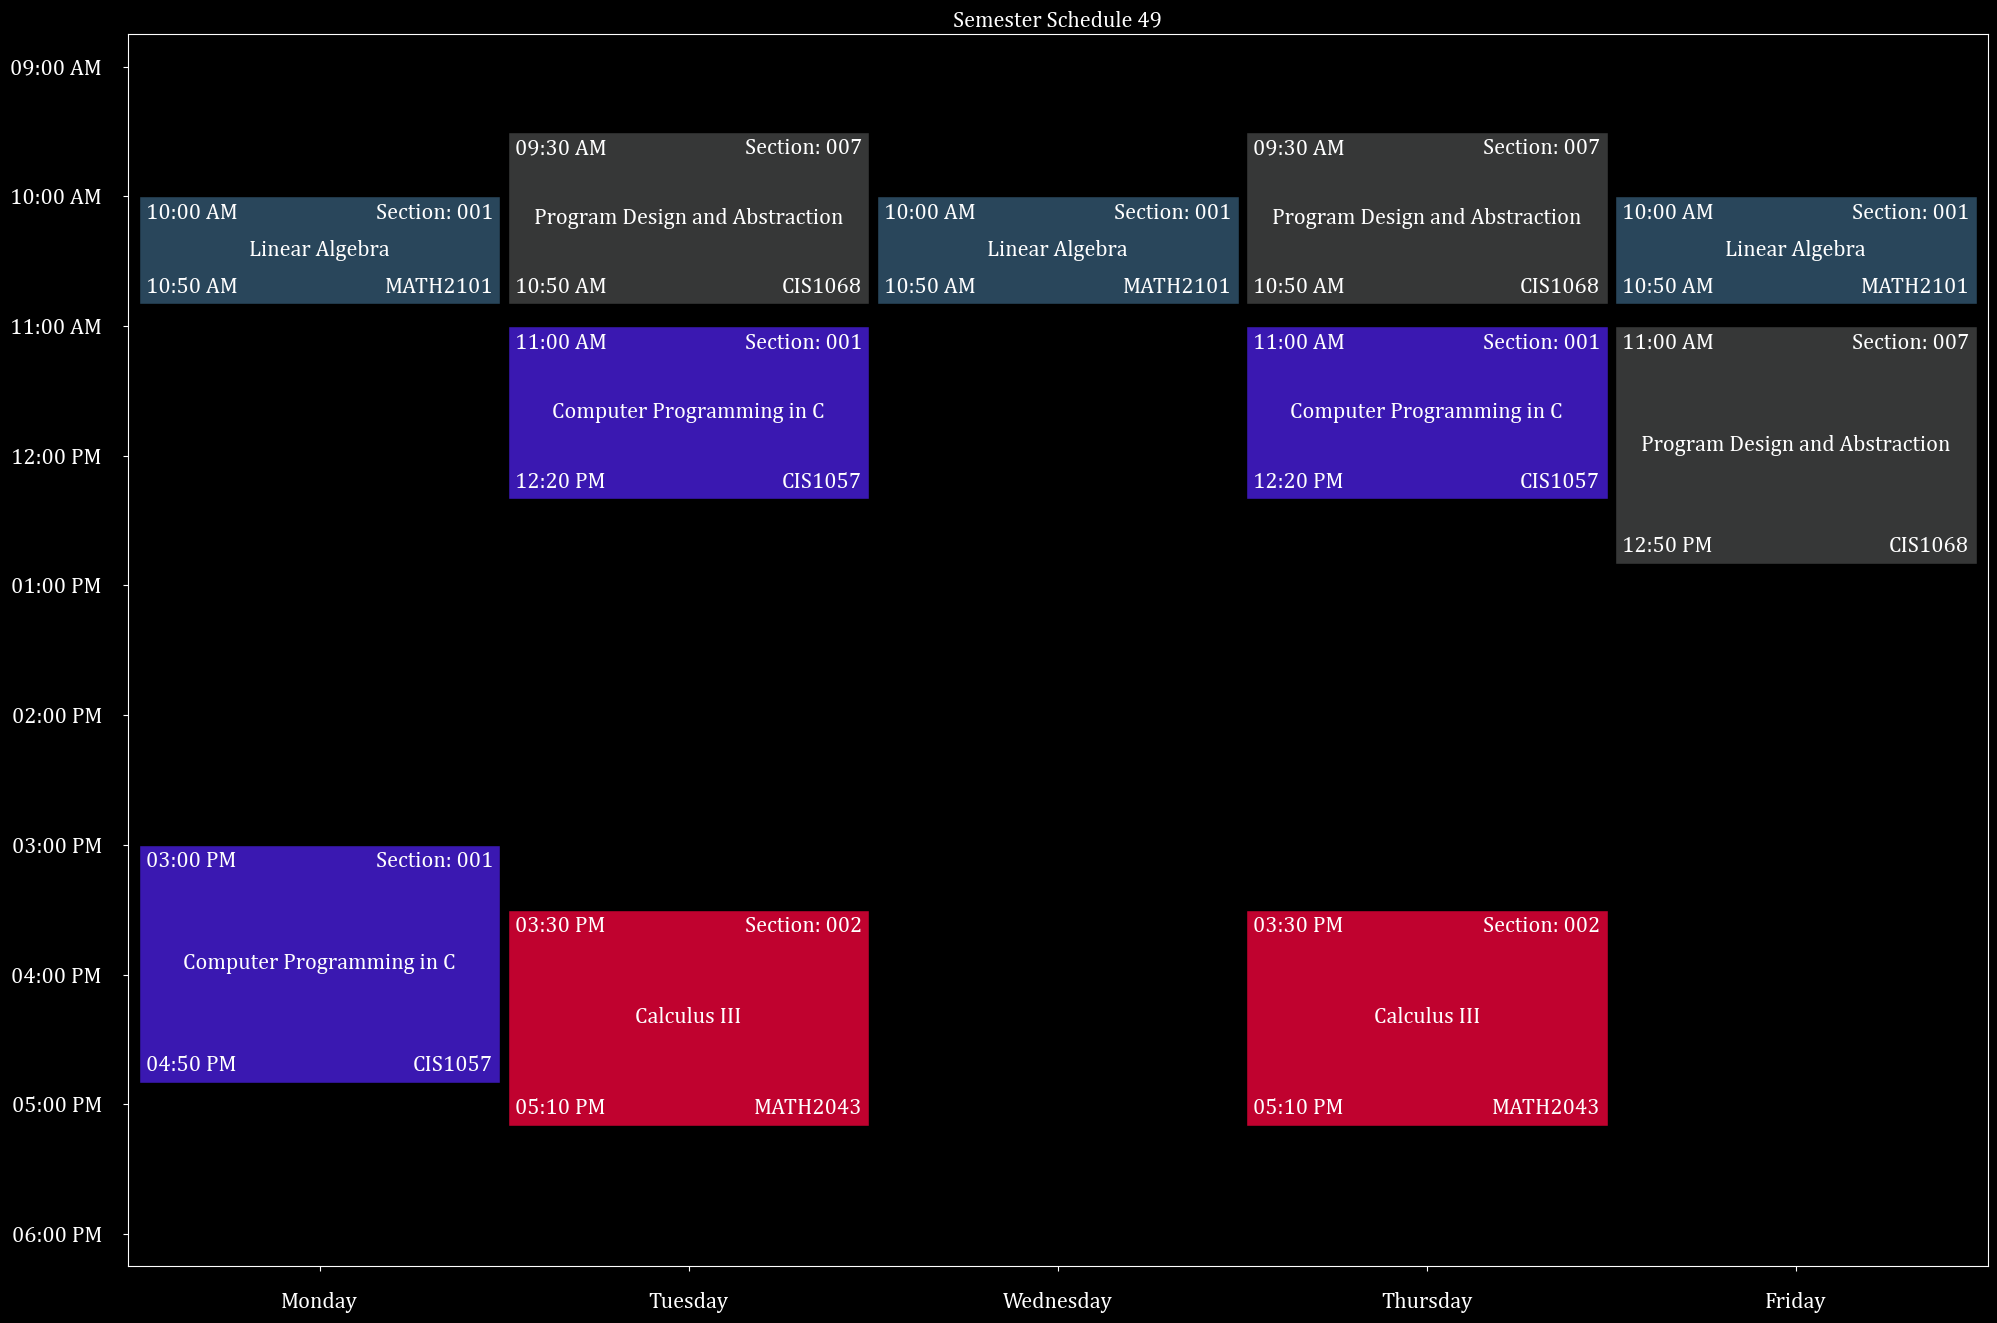

WEEK_RANGE(7 hrs 40 mins), WEEK_TOTAL(14 hrs 50 mins), BREAK_TOTAL(9 hrs 0 mins)


| Class | Section | Teachers | Ratings | Type | Credits |
| --- | --- | --- | --- | --- | --- |
| CIS1057 | 001 |  |  | In-person | 4 |
| CIS1068 | 001 | John Fiore | 4.40 | In-person | 4 |
| IH0851 | 704 | Jordan Shapiro | 4.60 | Online | 3 |
| MATH2043 | 002 |  |  | In-person | 4 |
| MATH2101 | 001 | Erik Wallace | 4.90 | In-person | 3 |


OVERALL_RATING: 2.032 avg


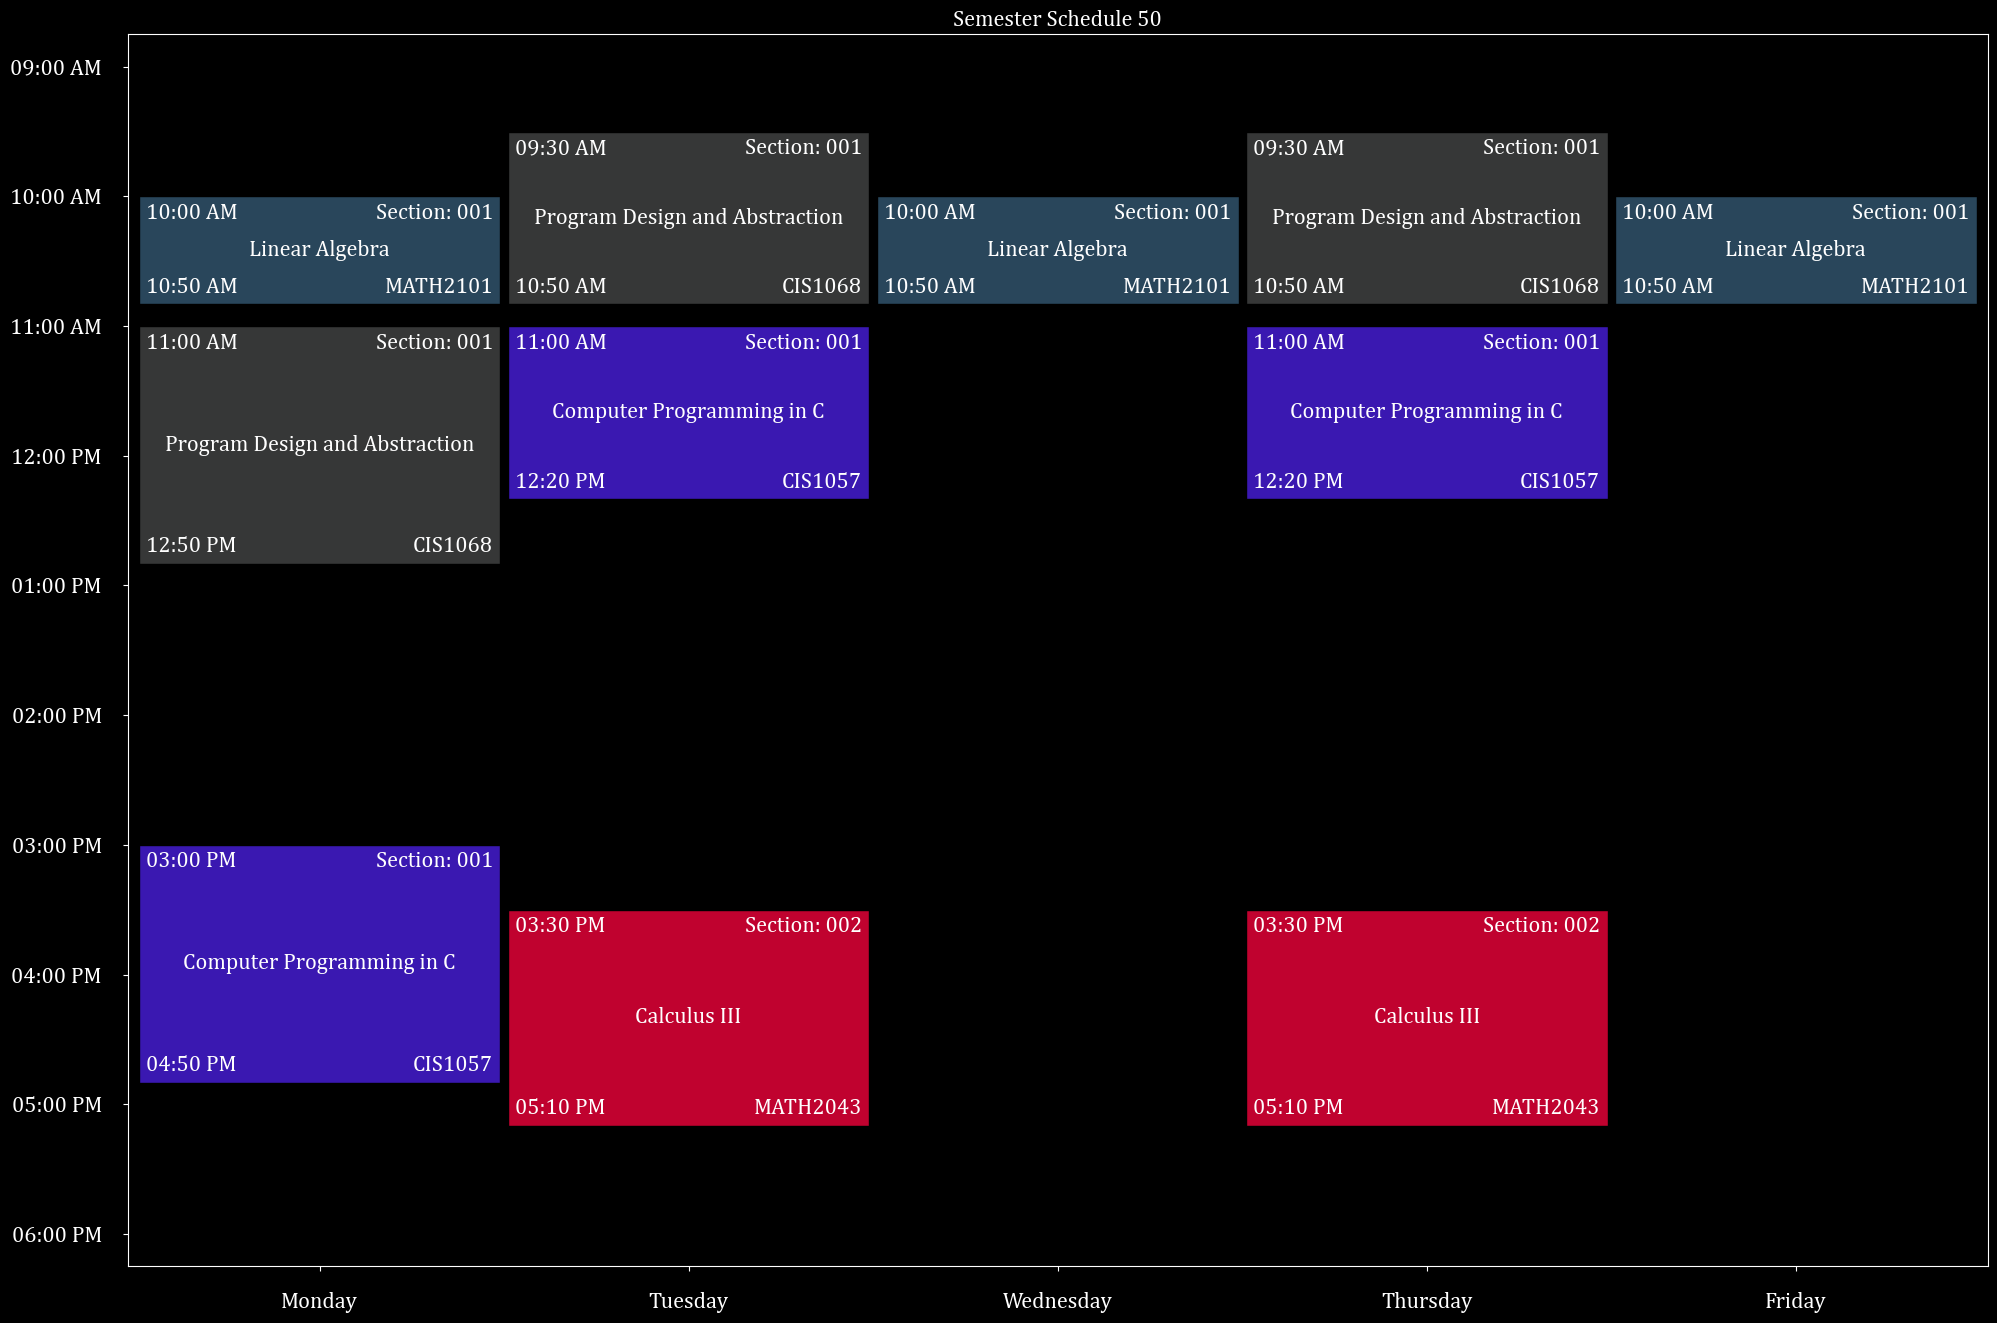

In [75]:
from school.schedule import SchedulePlot, ScheduleCompare

schedules = [SchedulePlot(course_section) for course_section in course_combos]
schedules = sorted(
    schedules,
    key=lambda s: (100000 - ScheduleCompare.teacher_rating(s), ScheduleCompare.between_total(s)),
    # schedules, key=lambda s: ScheduleCompare.week_range(s)
)
schedules = list(schedules)[:50]

# print(len(schedules))

for index, schedule in enumerate(schedules):
    schedule.print_stats()
    schedule.show(title=f"Semester Schedule {index + 1}")